In [1]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import torch

In [2]:
def distance(point, rectangle):
    image = np.zeros((100, 100), dtype='uint8')
    (x0, y0) = point
    (x1,y1) = rectangle[:2]
    (x2,y2) = rectangle[2:]
    
    #minimum distance is in some corner point
    if x0>=x2 and y0<=y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<=x1 and y0<=y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<=x1 and y0>=y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>=x2 and y0>=y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]   
    # point is inside rectangle  - distance is the distance between two centers  
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        print(d_coord)     
        
    #draw distance
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(255,0,0), thickness=1)
    cv2.circle(image, (x0,y0), radius=0, color=(255, 0, 0), thickness=-1)
    cv2.line(image, d_coord[:2], d_coord[2:], color = (255, 255, 255), thickness=1)
    plt.imshow(image)
    plt.axis("off")
    return d

[50, 50, 70, 60]
22.360679774997898


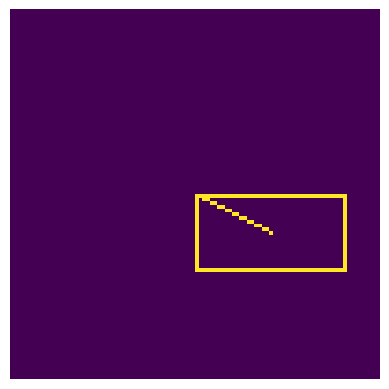

In [4]:
d = distance([50,50], [50, 50, 90, 70])
print(d)

In [8]:
def get_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = rect2[:2]
    (x2,y2) = rect2[2:]
    
    #d=0
    
    #minimum distance is in some corner point
    if x0>x2 and y0<y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<x1 and y0<y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<x1 and y0>y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>x2 and y0>y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]      
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        
    
    return d, d_coord

In [12]:
def get_circular_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = int((rect2[0]+rect2[2])/2), int((rect2[1]+rect2[3])/2)
    
    d=np.sqrt((x1-x0)**2+(y1-y0)**2)
    d_coord = [x0,y0, x1,y1]
    
    
    return d, d_coord

In [11]:
model = YOLO('yolov8n.pt')

In [16]:
cap = cv2.VideoCapture("videos/traffic2.mp4")


while True:
    _, frame = cap.read()
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = model.predict(img)
    people_boxes = []
    cars_boxes = []
    
    for r in results:
        boxes = r.boxes
        for box in boxes: 
            b = box.xyxy[0].numpy().astype("int") # get box coordinates in (top, left, bottom, right) format
            c = box.cls
            if model.names[int(c)]=="person":
                people_boxes.append(b)
            if model.names[int(c)] in ["car", "truck"]:
                cars_boxes.append(b)  
            
                           
            # print(b)
            # print(model.names[int(c)])
            if model.names[int(c)] in ['person', 'car', "truck"]:
                cv2.rectangle(frame, b[:2], b[2:], color = (255, 0, 0), thickness=2)
                
    # print(cars_boxes)            
    # d = get_distance(cars_boxes[0], cars_boxes[1])
    # print(d)
                
    for person in people_boxes:
        for car in cars_boxes:
            d, d_coord = get_circular_distance(person, car)
            # print(d)
            if d<150:
                print(d)
                cv2.rectangle(frame, person[:2], person[2:], color = (0, 0, 255), thickness=3) 
                cv2.rectangle(frame, car[:2], car[2:], color = (0, 0, 255), thickness=3)
                cv2.line(frame, d_coord[:2], d_coord[2:], color=(0, 0, 255), thickness=3)
                cv2.putText(frame, "ALARM!", (20, 50), cv2.FONT_HERSHEY_SIMPLEX , fontScale = 1, color=(0, 0, 255), thickness=5) 
                            
    imS = cv2.resize(frame, (960, 540))        
    cv2.imshow('YOLO V8 Detection', imS)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 6 persons, 5 cars, 1 truck, 2 traffic lights, 95.8ms
Speed: 3.0ms preprocess, 95.8ms inference, 15.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 cars, 1 truck, 1 traffic light, 95.5ms
Speed: 4.1ms preprocess, 95.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1073.2124673148369
221.20578654275752
434.0875487732861
383.0156654759698
382.7584094438684
388.7415593938986
432.78285548297777
857.962703152066
1065.476419260417
288.7784618007375
288.44410203711914
1030.328103081732
323.878063474512
968.3439471592725
1175.041275870767
396.86899601757756
396.60811892849597
1141.1581836012044
996.5746334319372
314.8205838251368
508.0354318352215
360.17356926904006
359.5385931996731
491.5648482143531
887.6237941830988
421.68353062456686
618.0008090609591
280.0
279.20064469839605
598.5824922264266
1176.609110962515
154.8418548067673
328.7369769283644
519.4121677434982
518.9412298131649
323.8579935712565
1071.2628062245044
221.92341021172146
434.4801491437785
381.6084380618437
382.5728688759829
389.6793553679743
435.12986567230706
854.4003745317531
1062.1096930166864
284.29737951659
283.3513719747974
1026.498904042279
323.6108774438832
968.1415185808323
1174.5454439909936
399.17038968340324
398.20848810641894
1141.0985934615817
996.5746334319372
313.8486

0: 384x640 6 persons, 4 cars, 1 truck, 1 traffic light, 84.9ms
Speed: 11.3ms preprocess, 84.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 1 truck, 1 traffic light, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1065.269918846862
226.29626598775332
378.02116342871597
439.84088031923545
378.02116342871597
996.7567406343435
311.66969695496545
363.6261816756324
506.0355718721758
363.6261816756324
323.79777639755343
966.1930448932035
397.8002011060326
1173.6477324989812
397.8002011060326
439.5201929377079
848.2688253142396
280.3176769310134
1056.9020768264202
280.3176769310134
886.8427143524381
419.5473751556551
283.0017667789373
617.0008103722394
283.0017667789373
1175.7912229643491
152.63354808167173
521.7135229223027
327.7392256047481
521.7135229223027
1064.3204404689407
227.26416347501865
441.760115900021
377.058350921976
374.8626415101937
997.7399460781352
310.46416862497995
506.0247029543123
363.7609104892938
361.58124951385406
325.21377584598105
964.4029240934517
1173.0515760187188
394.77715232774045
396.43410549547826
441.0045351240733
846.7349053865678
1056.6593585446542
276.40911707105465
277.973020273551
1176.9456232128994
151.82226450688975
327.7392256047481
522.5935322982863
520.35853

0: 384x640 6 persons, 4 cars, 1 truck, 2 traffic lights, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 1 truck, 2 traffic lights, 90.1ms
Speed: 0.9ms preprocess, 90.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



1060.4272723765644
230.41701326073994
371.84001936316645
372.8002145922129
445.04831198421596
326.01380338875225
962.7486691759174
392.93765408777
391.97066216746373
1171.7939238620415
444.49184469459055
843.2822777694312
277.1569952211201
276.2191159206763
1053.0550792812312
997.9228427087938
310.9340766143203
362.8567210346255
363.6261816756324
506.0355718721758
1176.7769542270958
151.82226450688975
520.358530246214
521.238908754901
327.67361810191557
889.2030139400114
417.90429526387976
283.8045101826255
284.40112517358295
616.0032467446905
1060.3758767531444
227.74108105478027
445.3234779348603
372.24722967404335
371.56156959513453
1407.8796113304575
328.67308986286054
956.8829604502318
1169.0286566205295
388.3104428160541
389.5292030130732
676.3623289332427
998.723184871564
306.8110167513546
505.0247518686584
363.1266996517882
362.98898054899684
1345.7741266646494
444.8932456219132
839.7577031501409
1052.820972435485
272.91940202191563
274.19153889206723
792.7483837889548
1176.776

0: 384x640 7 persons, 4 cars, 1 truck, 3 traffic lights, 85.5ms
Speed: 0.0ms preprocess, 85.5ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 2 traffic lights, 81.6ms
Speed: 3.5ms preprocess, 81.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1060.479608479107
228.47319317591726
443.5414298574599
371.84001936316645
372.8002145922129
327.00152904841286
959.8150863577838
1169.6982516871606
391.71673438851195
390.7492802296634
1175.9600333344667
151.0132444522665
327.8078705583501
519.4785847366569
520.358530246214
446.1748536168304
839.5981181493918
1050.3275679520175
273.91239475423527
272.9706943977686
999.0895855727854
308.021103173143
504.0634880647477
363.6261816756324
364.3967617858315
445.87554317320433
842.607856597599
1051.5764356431728
291.62475889402805
290.7232360854564
889.0022497159385
415.60076997041284
615.0032520239222
282.20028348674634
282.8002828852899
1058.535781161884
234.07904647789388
447.66281954167243
368.6800781165155
369.64036576110027
327.319415861632
963.6871899117473
1171.686818224051
392.68435161080714
391.71673438851195
445.5928634976103
844.2795745486208
1053.0550792812312
276.4706132665821
275.53039759707093
1176.3001317690992
155.42522317822161
329.802971484491
518.5990744303349
519.4785847

0: 384x640 6 persons, 4 cars, 1 truck, 1 traffic light, 81.2ms
Speed: 4.0ms preprocess, 81.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 2 traffic lights, 97.3ms
Speed: 0.0ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1056.593109952928
236.02754076590298
448.6256791580259
368.6800781165155
367.441151750862
442.9954853043087
846.8158005139016
1054.9336472025147
274.16965550549173
274.8035662068453
330.7748478950599
960.5758689452905
1167.4973233374028
388.3632320392856
389.07068766485094
1176.3001317690992
154.8418548067673
328.7369769283644
519.8846025802264
518.530616260988
889.2030139400114
419.5473751556551
616.0
281.2045518834999
279.8035024798653
997.4948621421566
314.0859754907882
507.04832116870284
362.2181663031273
360.81019941237804
1055.5946191602154
236.25410049351524
451.0931167730228
367.441151750862
366.2034953410467
444.8022032319534
844.0764183413727
1054.469534884721
271.3300573102803
271.97426348829407
334.55193916640206
955.7013131726878
1164.83475222883
383.9817704006272
384.6920846599264
1177.6285492463232
153.8083222715858
328.7369769283644
521.238908754901
519.8846025802264
998.6641076958759
312.14419744726956
507.03550171560966
362.98898054899684
361.58124951385406
890.384186

0: 384x640 7 persons, 5 cars, 1 truck, 2 traffic lights, 74.9ms
Speed: 9.8ms preprocess, 74.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 2 traffic lights, 78.5ms
Speed: 3.1ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1053.543069836255
238.20159529272678
366.7601396008023
451.2482686947397
366.4805588295237
1399.9607137344963
445.79816060634437
842.9952550281645
270.05925275761246
1051.9591246811826
269.74246977441277
792.4626174148532
337.3499666518436
952.7066704920251
380.3800730848029
1160.5365138589996
380.1184026063458
683.6870629169459
1177.2854369268312
153.21879780235844
522.1197180723976
327.8795510549568
521.6473904851821
1523.2366854825943
429.01048938225273
873.0824703314115
334.78649913041596
1077.3541664652344
334.2828143952363
772.1301703728459
890.1825655448438
417.5739455473725
283.21193477676746
615.0032520239222
282.41812972966164
1235.4990894371392
999.4598541212148
311.1735849971845
365.16845427829605
505.08019165277113
364.5339490363003
1345.113006405038
1051.6006846707546
238.4302833114955
365.1246362545261
453.1765660313869
1397.9649494890778
445.888999640045
841.0873914166114
270.37936311782374
1051.9591246811826
792.4626174148532
1177.4565809404608
151.0132444522665
522.59

0: 384x640 6 persons, 5 cars, 1 truck, 3 traffic lights, 85.5ms
Speed: 0.0ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 3 traffic lights, 57.6ms
Speed: 1.7ms preprocess, 57.6ms inference, 16.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 1 truck, 4 traffic lights, 69.9ms


1050.657889134232
238.9518780005715
454.84282999735194
364.0782882842645
414.6383966783588
1396.1009992117333
448.52870588179746
838.3614972074994
1050.5055925600777
267.8451044913832
1016.996066855718
794.1800803344289
1177.4565809404608
151.6047492659778
328.87687665751145
522.6671981289815
325.8972230627318
1522.403363107163
342.4456161202827
945.7193029646799
1156.559120840781
377.33009421460144
1125.3239533574322
687.782669162287
890.1825655448438
415.43832273876706
616.000811687777
284.20063335608523
598.9073384088728
1234.514074443868
431.5020278052005
869.0972327651263
1076.305718650607
335.96577206614364
1050.880107338606
773.5179377364174
1046.6642250502307
362.8291609008295
240.3767875648562
455.90569200219466
1394.0390955780258
447.7019097569274
266.27053911388697
836.3695355523179
1047.8038938656412
795.2659932374828
1175.658538862369
523.545604508337
150.20652449211386
326.67568014775753
1522.403363107163
429.21905829075206
336.48179742743883
869.0972327651263
1075.407364

Speed: 0.0ms preprocess, 69.9ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 4 traffic lights, 76.6ms
Speed: 3.8ms preprocess, 76.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1044.6114110041112
242.55308697272852
458.5280798380836
359.30210130195456
420.6851554309945
450.6905812195325
833.3816652650813
1045.5510508817827
265.9793225045887
1014.9113261758389
344.58090486850836
940.7895620169263
1151.6948380539004
375.0
1123.3009391966161
1175.658538862369
150.20652449211386
327.8078705583501
522.7504184598995
328.1249761904753
430.4706726363597
868.1128958839397
1075.2581085488266
338.89526405661087
1053.0052231589357
888.2235079077788
414.1328289329403
615.0008130075927
284.40112517358295
600.8810198367061
336.68976818430343
948.7744726751453
1159.6486536878315
382.6865558129786
1131.298811101647
1044.6674111888433
242.55308697272852
457.29858954516794
357.6940033045005
420.6292904684599
450.6905812195325
833.4722550871145
1044.5601945316507
267.86750456149025
1014.9113261758389
1175.8316205987999
150.20652449211386
326.88224179358537
521.4834609074386
328.49505323520475
344.9420241141981
940.1132910452867
1150.1447734959281
374.8626415101937
1122.400997861

0: 384x640 6 persons, 4 cars, 1 truck, 3 traffic lights, 79.8ms
Speed: 0.0ms preprocess, 79.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 cars, 1 truck, 3 traffic lights, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 6 cars, 1 truck, 3 traffic lights, 65.7ms


453.6540532167656
830.6262697507225
1041.2732590439457
269.8184574857695
1010.5389651072343
1040.5623479638305
246.9088900789115
461.68604050804913
353.5788455210521
422.7398727349953
429.5881748838066
868.057601775366
1074.4086745740653
339.5673718130174
1050.880107338606
348.05890306096177
937.0533602735759
1147.0523091821053
372.52248254300036
1117.3763913740079
1176.8164682736217
149.40214188558343
149.40214188558343
325.8849490234245
522.8431887287048
325.7115288103877
888.4255736976509
414.1328289329403
614.0
284.82275190019493
599.0701127580978
453.76645975655805
832.4764260926552
1041.0076848899819
266.6477076593759
265.3695536417092
1010.9149321283171
1039.675430122305
249.5956730394179
462.22288995678264
352.28681496757724
352.9305880764658
424.6787020795839
430.8363958627451
869.05753549463
1072.5693450775107
340.08381319904066
338.71079108879894
1050.880107338606
348.3690571793081
938.98349293265
1146.281815261849
374.0401048016108
372.8002145922129
1118.3505711537862
1177.

Speed: 0.0ms preprocess, 65.7ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 3 traffic lights, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 3 traffic lights, 82.6ms


453.67940222143653
829.7692450314123
1040.2961116912818
265.03584663211126
264.09278672466615
1009.0039643133222
800.0681220996122
429.21905829075206
868.0466577321752
1073.567883275203
340.93987739776054
340.08381319904066
1050.880107338606
771.3553007531614
1037.794295609684
248.62220335279792
462.9168391838862
351.64755082326394
352.59750424527965
424.6233625226007
1384.0610535666408
347.75997469519115
936.4000213583936
1145.8621208504974
371.7041834577599
370.7411495909242
1116.4877966193808
693.8623782854926
1176.9902293562168
147.41099009232656
147.41099009232656
323.6186026791414
522.8431887287048
523.7174810907118
324.4102341172362
1522.403363107163
781.256039976652
506.56983723865756
720.1569273429229
104.89041900955492
104.89041900955492
105.64563407921787
105.64563407921787
682.0095307251945
1127.154381617709
456.75485766437123
829.7692450314123
1038.0366082176486
262.54523419784255
1006.9185667172892
803.1444452898868
1037.9137729117963
251.31852299422738
463.0874647407334


Speed: 0.0ms preprocess, 82.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 3 traffic lights, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 3 traffic lights, 68.8ms


458.57714727186305
827.8743866070504
1036.0559830433874
260.5993092853471
1005.0079601674805
1035.8571330062848
253.26863208853953
464.7590773723521
348.79936926548476
427.5160815688692
429.51600668659603
871.0574033896962
1074.3579477995218
341.796723214252
1051.9629271034223
353.41335571820144
933.553426430432
1140.7795580216189
366.08468965527635
1111.5201302720523
1177.974957288991
149.03019828209315
149.03019828209315
323.81785003300854
522.3581147067594
324.7845439672276
992.358806077721
315.32998588779975
509.0628644872851
360.672982076562
498.61608477866014
889.6077787429693
414.8120056121809
612.0008169929188
284.01584462842914
598.0836061956555
781.2822793331486
509.3220984799305
720.2256590819297
104.1393297462587
104.1393297462587
682.8206206610928
1033.8012381497713
466.6915469558025
255.66579747787932
346.5862086119412
429.563732174866
461.40654525049814
1033.225048089718
825.1848277810251
257.1089263327899
1002.1027891389186
428.2639373096922
1075.356685012001
872.036696

Speed: 13.0ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 3 traffic lights, 86.6ms
Speed: 4.0ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1031.6884219569395
470.3668780856067
342.80023337214925
260.0173071162764
464.3974590800428
1031.3859607343898
254.8921340488953
824.1899053009568
429.51600668659603
1075.356685012001
342.1417834757982
873.0463905199998
1178.9597109316333
323.81785003300854
521.8745059877901
149.26486525636233
149.26486525636233
890.586885149338
612.0008169929188
283.21016930894274
415.6500932274646
993.7248110015166
509.09822235006874
361.33364083627754
316.53277871335854
352.63153574233826
1142.4871990530135
365.2615501253862
936.090273424524
1029.6917014330065
472.5589910265172
340.898811966249
260.7623439072444
435.83712554118193
1374.0833308063961
468.5434878429109
1027.2847706454136
251.78165143631892
818.91696770796
997.1559557060269
813.1057741770132
1178.149396299128
324.81533215043896
521.4834609074386
150.42606157179014
325.8972230627318
1521.8837012071585
889.4048571938429
613.0073409022114
281.8119940669666
415.6500932274646
599.4163828258284
1232.544116857486
353.50388965328233
1141.73990

0: 384x640 8 persons, 5 cars, 3 traffic lights, 70.9ms
Speed: 0.0ms preprocess, 70.9ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 3 traffic lights, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1026.6966445839785
262.71086768537003
475.4545193811917
339.31254029286924
435.7763187691594
469.38257317459073
817.1248374636522
1026.579271171983
249.56161563830284
993.2094441757993
888.4255736976509
415.6500932274646
614.0073289464874
282.6181168998194
597.599364122821
427.3090216693301
873.0463905199998
1077.4562636135167
343.0014577228499
1052.8380692205235
353.27184999657135
933.2652356109703
1141.9886164056102
362.83329505435415
1109.912609172452
992.9375609775269
316.0284797292801
510.09802979427394
362.6596200295809
497.8554006938159
1176.9902293562168
149.84325143295575
149.84325143295575
325.74376433018637
521.4834609074386
324.0385779502188
1318.023140919764
57.0087712549569
57.0087712549569
200.80836635957178
624.8279763262846
144.49913494550754
144.49913494550754
1022.5898493531021
478.17360864020924
264.14011433328335
334.8865479531837
441.02154142399894
1369.894156495311
469.38257317459073
1024.7438704378767
814.1400370943564
249.56161563830284
994.308805150593
816.835

0: 384x640 8 persons, 6 cars, 3 traffic lights, 86.0ms
Speed: 0.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 3 traffic lights, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 3 traffic lights, 69.2ms


470.37963391286405
1022.7648801166375
813.0448942094157
248.95983611819798
992.2605504604121
817.7493503513164
1019.5945272509067
480.10207248042576
266.8332812825267
332.3567360532956
442.9503358165563
1366.835761896798
887.2440475990808
612.0204244957843
413.67257583746107
282.02836736753983
598.2725131576747
1233.0145984537246
348.91402952589914
1143.4797768216104
934.7769787494769
369.16798344385177
1114.754233003849
696.1609009417291
991.3773247356427
508.0354318352215
313.6144129340997
360.58424813072463
497.98092332939825
1337.3862568457926
1312.4652376348868
209.24626639440905
64.1404708432983
64.1404708432983
618.0493507803402
150.9205088780183
1659.6077849901765
1176.0055271978954
323.68194265358704
148.8086019019062
148.8086019019062
521.0959604525831
324.59975354272837
1522.403363107163
425.76284478568584
1075.6193564639864
871.0367386052095
343.35404468274436
1053.721974716291
768.9895968086954
470.3041569027431
1022.9100644729233
813.0448942094157
248.95983611819798
992.3

Speed: 15.9ms preprocess, 69.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 6 cars, 1 truck, 4 traffic lights, 61.4ms
Speed: 0.0ms preprocess, 61.4ms inference, 16.7ms postprocess per image at shape (1, 3, 384, 640)



1013.7184027134952
484.1487374764082
271.0608787708031
327.9954267973869
447.69855930078666
466.31534394656154
1025.7333961610102
816.0300239574522
253.06125740618614
995.2070136408806
1310.032442346372
215.41123461880997
71.55417527999327
71.55417527999327
614.6909792733256
153.37535656030275
887.0428400026686
611.020457922646
412.68389840167015
282.83740912404073
597.441210496899
354.37973982720854
1136.9028102700777
928.0355596635293
362.8567210346255
1107.834825233437
991.1861580954408
507.03550171560966
312.64196775225173
361.24783736376884
497.2132339348984
1176.0055271978954
322.7506777684595
148.60013458944107
148.60013458944107
522.0737495795015
324.4102341172362
426.1373018171491
1073.6777915184798
869.0281928683327
342.49233568066893
1051.723347653745
1010.5528190055184
487.11805550605493
324.7845439672276
275.61023203067043
449.87220407577973
260.63959791251983
279.95178156246834
467.38848937473847
1023.7543650700592
251.18120948828954
815.9313696629147
993.1606113816637
80

0: 384x640 8 persons, 6 cars, 1 truck, 3 traffic lights, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 3 traffic lights, 75.7ms
Speed: 7.7ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1007.670581092849
488.78727479344224
275.95108262154
324.1681662347492
280.28021692584724
249.6096953245206
450.75048530201275
467.31252925638535
1023.0562056895994
813.9410298049853
248.62019226120793
818.1197956289775
789.2084642222231
991.2118845130944
1302.0387859046289
221.40009033421825
67.77905281132217
67.77905281132217
609.4276002939151
68.30812543175226
68.30812543175226
63.7808748764079
63.7808748764079
158.26875876179733
989.6069926996272
507.03550171560966
314.3262636179166
361.99585632987566
317.73731288597503
298.21636440678435
496.6628635201146
886.4671454712803
610.0204914590985
413.1452529074974
284.01584462842914
416.78891539963007
394.4882761249059
595.7851961907077
354.2654372077525
1135.2977582995572
927.0388341380311
359.2005011132362
931.1890248494126
902.6167514510242
1104.8764636827052
421.9407541349852
1076.6731165957474
873.0572718899946
344.2165016381405
877.0364872683463
850.565106267592
1053.7978933362886
1174.2112246099507
322.6840560052511
150.602124819

0: 384x640 8 persons, 4 cars, 1 truck, 3 traffic lights, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 3 traffic lights, 59.1ms
Speed: 0.0ms preprocess, 59.1ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 3 traffic lights, 88.0ms


1001.8587724824292
492.8539337369643
281.23299948619115
321.40939625343873
283.38842601630716
422.8392129403327
1075.5115062146012
873.0967873036758
344.0261617958727
875.0822818455416
886.6707393390176
609.0131361473249
413.30376238306854
286.0069929215018
415.12046444375636
1299.001539644969
223.6000894454204
67.67569726275453
67.67569726275453
608.276253029822
68.00735254367721
68.00735254367721
989.800484946335
506.048416655956
314.5695471592888
364.156559737704
316.26729201736936
471.3013897709193
1018.1105048078033
809.9604928636952
242.98148077579904
812.0498753155498
478.93423348096553
1010.0316826713903
802.2374960072609
239.38462774372127
804.3195882234872
353.62409420173844
1134.91849927649
927.797930586181
358.98885776580863
929.8698833707864
1000.8606296582956
494.0738811149604
318.2483307104689
282.21445746098834
284.36947796836427
887.8541546898342
608.0131577523631
285.41373477812874
412.47787819469784
414.2909605579151
990.9757817424198
505.04851252132204
363.407484788

Speed: 0.0ms preprocess, 88.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 3 traffic lights, 68.5ms
Speed: 16.1ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 3 traffic lights, 63.5ms
Speed: 0.0ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


999.9864999088737
494.5401904800054
317.3089976663126
281.8386062980017
448.2856232359008
991.1710245966636
505.0633623615952
362.7450895601483
313.12936623702353
487.7509610446708
888.0596826790415
608.0074012707411
284.60850303530987
411.655195521689
586.297705948096
352.27829907617075
1136.417616899703
360.41087663942665
928.0355596635293
1096.6936673474504
421.64558577079873
1075.7880832208543
342.21192264443386
872.0464437173057
1043.9703060911263
473.3708905287692
1016.1323732663968
242.2973379961076
806.8766944211488
974.9487166000066
1296.125379737624
224.8288237748888
603.3448433524562
64.19501538281614
64.19501538281614
153.05554547287727
480.71301209765477
1008.0803539401013
242.26638231500465
799.565507009901
968.4048740067349
1173.4027441590547
322.6840560052511
520.6092584655021
151.2084653714864
317.90721916936707
1002.7965895434627
492.39415106193127
279.2704782106408
320.39506862621965
990.9757817424198
505.04851252132204
313.12936623702353
363.49552954610044
887.64970


0: 384x640 8 persons, 4 cars, 1 truck, 5 traffic lights, 81.8ms
Speed: 0.0ms preprocess, 81.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1001.8587724824292
492.39415106193127
280.25167260874645
320.39506862621965
475.14734556766706
1013.7652588247439
805.1863138429514
237.52263050075882
1294.1271189492938
226.22555116520326
63.60031446463138
63.60031446463138
603.3448433524562
992.1517021101158
503.048705395412
312.1618170116262
365.0
886.8754140238639
608.0205588629384
412.47787819469784
284.40112517358295
1173.0515760187188
321.50427679892533
150.0
521.3923666491484
355.14785653302204
1132.7104660944915
925.127018306135
355.31676008879737
422.0189569201839
1073.968807740709
871.0281281336441
338.61482542853906
995.9944778963386
495.50882938652063
285.9545418418809
314.4932431706602
286.14157335137446
1293.0866173617296
225.41739063346466
65.25335240430181
65.25335240430181
601.2071190529932
66.21933252457322
66.21933252457322
473.22299183365976
1013.4633688496097
807.1759411677234
240.68444071023785
807.2781428974774
990.1903857339759
503.06361426761924
313.8470965295043
362.7450895601483
313.6000637755037
1173.402744

0: 384x640 8 persons, 5 cars, 1 truck, 5 traffic lights, 78.6ms
Speed: 2.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 4 traffic lights, 101.9ms
Speed: 2.0ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



994.1272554356409
497.20016090101984
286.75425018646195
313.3209217399949
287.9201278132531
1342.5814686640063
1289.049262053239
229.82819670353766
66.49060083951716
66.49060083951716
597.0971445250764
67.26812023536856
67.26812023536856
1637.207989230446
474.2931582892589
1012.4746910417069
805.1863138429514
240.07707095847366
806.283448918555
822.8146814441269
991.3672377076015
502.06374097319554
311.91024349963243
364.156559737704
312.6307726376276
1338.5607942861616
356.7239829335841
1129.0921131599493
922.8916512787403
356.5459297201414
923.9680730414877
705.2162788818761
1173.5795669659556
319.6904753038476
149.80654191322887
149.80654191322887
521.9693477590423
150.0
1521.2116880960389
886.102702851086
607.0131794285854
412.3166259078089
284.01584462842914
413.1452529074974
1233.0660971740322
417.2349458039199
1076.963323423783
875.0142855976695
343.83717076546566
876.0091323724885
761.9324117006705
1288.0500766662763
67.08203932499369
67.08203932499369
230.63824487712353
594.96

0: 384x640 8 persons, 5 cars, 1 truck, 3 traffic lights, 67.6ms
Speed: 0.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 2 traffic lights, 80.3ms
Speed: 2.6ms preprocess, 80.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1287.0508925446577
230.63824487712353
594.6377048253836
69.05070600652827
69.05070600652827
1635.0574913439589
68.8839603971781
68.8839603971781
996.1229843749214
494.2924235713107
314.14805426741066
285.3506614676055
1344.3608146624922
286.33197516169935
476.36225711111916
1009.3587072988472
237.52263050075882
803.4033856040189
824.6453783293762
804.3979114841112
887.4959154835587
605.0033057760925
283.8045101826255
411.1702810272163
1233.8760067364954
412.15773679502854
991.5644204992432
501.08083180261445
362.8360511305347
311.4161203277698
1338.2215810544978
312.385979198811
355.85671273702286
1128.965898510668
357.0154058300566
924.0487000153184
704.0063920164362
925.0454042910543
1174.1149858510453
318.90437438203946
521.9693477590423
149.80654191322887
149.80654191322887
1521.2116880960389
150.60212481900777
416.27875276069517
1076.963323423783
343.25792052041567
876.0022831020476
760.3479466665245
877.0022804987453
996.2554893198833
284.9719284420836
494.77267507411926
314.4932

0: 384x640 7 persons, 5 cars, 1 truck, 1 traffic light, 70.5ms
Speed: 17.2ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 1 truck, 2 traffic lights, 81.3ms
Speed: 1.8ms preprocess, 81.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



479.5883651632929
802.1003677844813
1008.9142679137807
234.43762496664223
827.3161427169181
801.0049937422363
997.2532276207482
285.9545418418809
495.7428769029365
316.3700365078842
1344.873600008566
284.787640181241
992.3477213154671
312.14419744726956
503.06361426761924
363.03443362854716
1338.9029091013283
311.4161203277698
1284.9731514704888
70.45565981523414
70.45565981523414
235.8664876577425
593.1778822579278
1632.2147530273091
69.58448102845921
69.58448102845921
887.2880028491313
412.98910397248983
608.0074012707411
282.8002828852899
1233.5951523899564
412.15773679502854
359.0891254271006
922.8916512787403
1128.716084761797
353.3907186104355
706.7729479825894
921.8161421888857
1175.0987192572375
150.60212481900777
320.8987379221053
523.2332175999533
1522.0118264980729
150.41608956491322
997.1208552627911
494.2924235713107
286.33197516169935
317.3089976663126
286.5257405539684
1344.798126114102
478.5916840063145
1007.9250964233404
803.0952620953507
235.1361307838504
803.19673804

0: 384x640 9 persons, 5 cars, 1 truck, 3 traffic lights, 67.9ms
Speed: 14.4ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 1 truck, 3 traffic lights, 58.9ms
Speed: 2.0ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 1 truck, 4 traffic lights, 65.9ms
Speed: 2.1ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


477.59501672442104
1008.0724180335459
237.00843866833097
804.1915194777921
804.0901690730959
825.3241787322119
995.9944778963386
495.04141240910343
314.74592928265173
287.9027613622349
287.70297183032363
1343.5788030480385
992.5447093204416
500.0639959045242
365.0
312.14419744726956
312.385979198811
1339.0750539084804
886.7271282643833
606.0033003210461
285.41373477812874
414.1328289329403
414.2909605579151
1232.9679638984949
1283.973909392243
234.82759633399138
592.5040084252595
71.34423592694787
71.34423592694787
70.34912934784623
70.34912934784623
1631.2161107590864
491.62994213127416
994.0789707060501
224.32119828495925
790.1626414859159
790.0607571573214
839.3574923713971
1175.2786903539093
317.90721916936707
524.6903848937962
150.60212481900777
151.2084653714864
1522.173774573718
357.4758733117523
1127.4927937685457
353.61702447704636
924.3819556871499
924.2970301802338
705.2162788818761
417.0419643153432
1075.280893534336
339.1872639118397
876.0051369712395
876.0022831020476
761


0: 384x640 7 persons, 4 cars, 1 truck, 4 traffic lights, 76.1ms
Speed: 2.3ms preprocess, 76.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



484.65348446080526
797.0250937078456
1000.0124999218759
231.19256043393784
797.0250937078456
832.2962213058521
990.8183486391439
293.2047066470796
499.67289300101123
309.3638634359223
293.2047066470796
1338.3052716028583
502.5942697643896
779.1180911774543
982.214335061345
214.55535416297585
779.1180911774543
850.2264404263137
363.4350010662154
918.3185721741665
1120.5520960669344
348.0488471464889
918.3185721741665
711.0731326663946
991.1710245966636
312.87697262662203
500.0359987040933
363.5890537406207
312.87697262662203
1337.5754184344148
886.5179073205459
414.1328289329403
605.0074379708071
285.41373477812874
414.1328289329403
1232.6110497638742
1175.2786903539093
151.2084653714864
316.9100818844361
525.1790170979797
151.2084653714864
1522.0118264980729
990.8794073952693
293.00170647967224
498.19674828324605
313.8056723515367
293.00170647967224
483.65690318654606
798.0200498734351
999.8649908862697
228.77936969928035
798.0200498734351
497.6102892826876
784.0918313565063
986.019269

0: 384x640 6 persons, 4 cars, 4 traffic lights, 76.4ms
Speed: 2.0ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 3 traffic lights, 73.4ms
Speed: 3.9ms preprocess, 73.4ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 4 traffic lights, 63.0ms


990.941471530988
293.981291921782
311.926273340352
499.8809858356287
495.9556431778955
786.7769696680248
220.73740054644117
989.3887001578298
990.9757817424198
313.38315206788
364.44478319767455
501.03592685555
886.5179073205459
414.9650587700126
286.60251220113196
606.0033003210461
1174.7412481053009
149.61617559608987
149.61617559608987
525.4674109780739
317.7624899197512
368.517299458248
914.333090290404
341.53184331772053
1116.3265651233066
988.9453978860512
294.7626163542453
308.76528302255747
501.8176959813195
500.8492787256462
780.8059938294531
216.2706637526227
984.5872231549625
886.5179073205459
414.1328289329403
285.20343616443336
606.0033003210461
1174.7412481053009
149.40214188558343
149.40214188558343
524.1087673374678
317.7624899197512
989.800484946335
313.38315206788
361.6241142401872
502.0248997808774
372.6070316030013
909.182049976791
338.6340207362515
1112.2310910957308
489.71930735881756
791.9501246922056
225.62358032794356
995.761517633615


Speed: 4.6ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 1 truck, 4 traffic lights, 79.3ms
Speed: 2.2ms preprocess, 79.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



503.7539081734255
778.9152713870745
981.7667747484634
212.72047386182646
991.068615182622
293.393933134276
499.38462130906674
310.98713799769916
991.7625723932115
312.40998703626616
500.02499937503126
362.49275854836054
491.7967059670083
790.8558655026844
993.636754553695
223.77220560203628
1174.7412481053009
150.20652449211386
317.7624899197512
523.6267754803988
887.4959154835587
414.1328289329403
605.0033057760925
285.0
377.5725095925285
905.1961113482537
1107.27277578743
333.54609876297457
366.87054937675225
915.769075695396
1118.1073293740633
341.5025622158639
509.65184194702954
773.1500501196388
976.9708286330764
207.74022239325728
207.74022239325728
991.068615182622
293.58644382872995
500.35387477264527
310.0483833210552
310.0483833210552
992.9375609775269
311.4369920224635
500.0359987040933
363.14184556451215
363.14184556451215
1175.9034824338262
149.40214188558343
149.40214188558343
317.83328963467625
524.1087673374678
524.1087673374678
888.6827330380623
413.1452529074974
605.0

0: 384x640 6 persons, 3 cars, 1 truck, 5 traffic lights, 77.4ms
Speed: 3.0ms preprocess, 77.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 1 truck, 4 traffic lights, 81.1ms
Speed: 2.3ms preprocess, 81.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 1 truck, 4 traffic lights, 66.7ms


511.5662224971465
771.3708576294543
974.3064199726902
205.91260281974002
992.1517021101158
312.40998703626616
500.0359987040933
363.6880531444496
984.1488708523726
300.45631962067296
506.1719075571065
304.19894805866767
888.4739726069639
412.8353182565658
604.0074502851766
285.80062981036275
377.3274440058661
905.8658841130954
1107.630353502467
337.3603414748094
1175.9034824338262
148.8086019019062
148.8086019019062
316.76489704511135
524.5922225881737
512.6421754011271
772.1554247688739
973.4705953443073
205.41178155110774
205.91260281974002
991.1710245966636
315.55982000248383
501.01596780941026
362.93250061133955
361.52178357603844
985.6332989504768
300.0283319954967
504.0079364454492
307.7027786679867
306.4000652741445
379.3098996862592
905.7869506677605
1105.8973731770955
335.4400095397089
336.1220016601115
888.6827330380623
415.12046444375636
604.0132448878915
286.60251220113196
285.20343616443336
1176.0824801007793
151.6047492659778
316.697016089511
525.077137190337
523.71748109

Speed: 0.0ms preprocess, 66.7ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 4 traffic lights, 78.0ms
Speed: 3.1ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4 cars, 1 truck, 4 traffic lights, 78.3ms


513.5601230625291
772.2596713541373
973.4705953443073
205.91260281974002
985.6332989504768
301.01494979485653
504.74746160827794
305.8512710452582
989.9949494820668
317.2774810792597
503.0159043211258
360.0138886209808
888.6827330380623
416.1081590163788
605.0074379708071
285.41373477812874
1175.0987192572375
153.21879780235844
318.76009787926716
522.4566967701725
384.2004685057008
902.8648846865183
1102.2254760256633
338.3637096380166
993.7248110015166
313.1549137407874
499.00901795458566
362.38239471585814
1270.3247616259396
63.953107821277925
63.953107821277925
243.28172968803062
578.0700649575274
515.7130985344468
770.0629844369874
970.0499987114066
204.91949638821583
203.59273071502332
989.9949494820668
317.2774810792597
502.0248997808774
360.0138886209808
360.1110939696249
1268.326850618562
64.32728814430156
64.32728814430156
243.58981916328113
576.1015535476363
576.909871643743
888.6827330380623
416.1081590163788
604.0033112492017
285.41373477812874
285.20343616443336
384.532183

Speed: 7.4ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 4 traffic lights, 91.3ms
Speed: 2.2ms preprocess, 91.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



1268.2815144911638
63.953107821277925
63.953107821277925
243.90571949013415
574.9408665245496
575.9253423838892
515.6326211557993
768.0735641850981
970.8887680882914
205.41178155110774
204.50183373260984
990.1903857339759
315.79265349276255
503.06361426761924
359.92221381848606
360.672982076562
888.4739726069639
414.1328289329403
605.0008264457165
284.01584462842914
284.60850303530987
1266.2389190038348
65.30696746902278
65.30696746902278
245.60537453402765
574.1332597925328
573.9564443405092
512.6421754011271
771.0577150901222
973.7068347300434
208.06249061279644
207.64633394307737
990.1903857339759
315.79265349276255
503.08051045533455
361.99585632987566
361.33364083627754
975.3732618849052
309.40103425812913
514.4803203233337
295.8462438497403
295.4623495472816
889.4520785292483
413.1452529074974
604.0
286.8117849740488
286.0069929215018
518.6135362676142
765.0281040589293
967.1881926491866
208.47062143141417
208.00240383226344
1368.786323718936
128.14054783713078
128.14054783713078

0: 384x640 9 persons, 4 cars, 5 traffic lights, 58.3ms
Speed: 8.1ms preprocess, 58.3ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 4 traffic lights, 89.8ms
Speed: 1.6ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1262.3331572924797
250.2179050347916
66.09841147864296
66.09841147864296
571.0035026162274
514.7989898979989
973.5594486213978
771.9507756327472
204.91949638821583
991.3672377076015
504.08035073785607
317.73731288597503
362.17813296774284
976.3016951741915
515.911814169825
311.7130090323469
296.1840643923977
890.6385349848725
605.0
415.12046444375636
286.40006983239374
521.9061218265216
965.9244276857274
764.8529270389178
204.94877408757534
1369.9379547994135
131.55227098001768
131.55227098001768
127.02755606560333
127.02755606560333
705.6939846704093
387.3719143149126
1100.3131372477565
899.7271808720686
328.72632994635524
403.06451096567656
1086.7037314742229
887.7302518220273
330.77031305726337
974.1709295601055
518.3213289070786
311.8878003385192
293.9557789872484
311.8878003385192
1260.2896492473467
252.4480144505003
66.09841147864296
66.09841147864296
569.0351482992944
66.09841147864296
66.09841147864296
517.9584925454934
970.2994383178834
766.6772463038146
203.49447166937975
766

0: 384x640 7 persons, 4 cars, 1 truck, 3 traffic lights, 85.7ms
Speed: 0.0ms preprocess, 85.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 2 traffic lights, 69.9ms
Speed: 2.0ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



972.45102704455
519.5767508270554
313.3448579440869
291.38462553813645
291.77045772319036
521.402915220082
966.7564326137168
763.3092427057333
204.38444167793205
204.84140206510986
1259.3827853357375
252.80031645549812
65.45991139621256
65.45991139621256
566.2623067095319
566.4432893061759
992.3477213154671
503.06361426761924
314.8205838251368
361.4249576329781
362.0842443410097
891.8256556076417
604.0
412.3166259078089
286.60251220113196
287.4056366879397
388.9730067755345
1098.8271019591755
895.9787943919208
327.88107600165034
328.16002194051606
1370.1040106502865
131.55227098001768
131.55227098001768
128.96898852049665
128.96898852049665
704.2307860353735
704.6162075910545
522.3035515866228
966.8986503248415
203.93136100168604
759.2338243255499
970.3159279327532
522.9541088852826
287.84718167805636
312.3587680856742
992.5447093204416
504.08035073785607
361.33364083627754
312.6307726376276
1255.482775668388
256.1347301714471
561.7116698093427
62.03224967708329
62.03224967708329
891.6

0: 384x640 8 persons, 1 bicycle, 4 cars, 3 traffic lights, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 4 cars, 1 truck, 4 traffic lights, 86.0ms
Speed: 5.0ms preprocess, 86.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



525.2903958764142
964.9191675990274
203.49447166937975
752.2639164548569
992.9415894200424
505.11978777315784
361.83559802761255
309.2604080706096
967.3928881276728
526.6213060634748
284.01584462842914
311.20732639190874
1254.483957649519
257.87787807409927
558.9508028440428
61.032778078668514
61.032778078668514
891.4084361279065
606.0033003210461
284.01584462842914
405.4084360247083
389.9653830790625
1099.819076030235
330.0802932621092
887.8434546697971
1370.1040106502865
133.4541119636259
133.4541119636259
701.8496990096954
134.61797799699713
134.61797799699713
401.2605138809449
1090.1655837532205
335.18054836162554
879.8210045230791
524.9323765972147
964.5102384111846
199.90497742677644
754.7357153335199
768.7658941446349
992.9415894200424
504.12002539077935
363.3249234500711
310.94211679989576
324.27457501321317
965.3978454502579
527.5954889875386
284.01584462842914
315.3173005085512
329.2931824377784
387.7383138148718
1101.0653931533766
329.52845097199116
892.0745484543318
906.109

0: 384x640 10 persons, 4 cars, 1 truck, 4 traffic lights, 67.4ms
Speed: 2.0ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 68.4ms
Speed: 2.2ms preprocess, 68.4ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)



1250.587861767417
260.0173071162764
557.9686371114419
63.324560795950255
63.324560795950255
71.56116265125938
71.56116265125938
527.1897191713814
962.2390555366167
197.6765034089788
750.656379444017
766.6772463038146
963.3327566318919
529.9971698037641
281.9237485562364
315.8259014077218
331.76045575083236
993.1414803541336
504.12002539077935
363.40748478808194
308.75556675143525
324.0385779502188
390.9577982340293
1097.9622033567457
325.68236059080635
887.0918779923531
903.1195934094221
890.4302330896004
606.0074256970784
283.600070521853
405.9187110740277
421.5839180993506
376.0757902338304
1112.8414082878116
340.12350697945004
902.0404647242827
918.0686248859613
1086.7497412007974
409.20654931220247
440.15679024638484
218.76242821837573
233.4180798481557
133.01503674397117
133.01503674397117
1476.025067537811
720.5733828001142
1270.0476369018604
1286.038879661109
1369.4524453225822
133.76471881628578
133.76471881628578
703.6938254667295
133.2216198670471
133.2216198670471
123.664869

0: 384x640 10 persons, 4 cars, 4 traffic lights, 80.4ms
Speed: 0.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 78.7ms
Speed: 2.6ms preprocess, 78.7ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)



1247.591679997907
260.4995201531089
554.0406122298256
66.64082832618455
66.64082832618455
959.4842364520639
530.7438176747798
278.11148843584294
322.5523213371747
528.1855734493323
958.4284010816875
197.6765034089788
752.745640970441
992.3628368696603
502.1205034650547
362.579646422686
312.6307726376276
888.4739726069639
605.0132229959937
281.8119940669666
410.7067080046295
395.17591019696533
1090.8918369847672
323.36357246913263
886.0124152629014
1369.4524453225822
130.60245020672468
130.60245020672468
702.7716556606421
130.66751700403586
130.66751700403586
1044.1800611005747
448.02790091689604
400.8391198473522
258.9246994784391
1086.7497412007974
406.1773011875479
439.32334333609
221.2080468699093
1177.2459386211533
316.8359196808342
521.9693477590423
147.00340132119393
147.00340132119393
1244.5955166237745
262.65186083483206
551.0952730699112
73.23933369440222
73.23933369440222
957.417881596119
532.6922188280959
275.87859648765794
334.55193916640206
530.996233508299
955.60922975869

0: 384x640 9 persons, 4 cars, 4 traffic lights, 85.3ms
Speed: 1.3ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 4 traffic lights, 66.1ms
Speed: 3.0ms preprocess, 66.1ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)



955.3522910424196
535.0934497823721
272.8552729928451
337.843158877015
1243.6997226018827
263.0589287593181
550.1136246267674
73.60027173862879
73.60027173862879
530.0
956.7470930188396
194.09276132818556
762.0026246673957
889.870215256135
604.0033112492017
282.4057364856458
420.7433897282285
992.1617811627295
502.09959171463186
360.58424813072463
322.8327740487325
400.13622680282276
1085.9327787667153
318.0015723231569
892.0745484543318
1176.262300679572
317.83328963467625
520.1240236712779
156.1569723067145
1046.8944550431052
446.0907979324389
403.63349712331853
268.4026825499328
1369.4524453225822
130.60245020672468
130.60245020672468
702.0
123.82245353731285
123.82245353731285
1240.703832507984
264.35771220072246
76.69419795525604
76.69419795525604
548.3429583755043
952.4305748977192
536.5901601781381
342.60764731686885
271.8124353299532
528.9177629840011
956.7470930188396
765.0895372438445
194.09276132818556
992.1617811627295
501.1207439330366
324.77838598034816
361.99585632987566

0: 384x640 7 persons, 4 cars, 5 traffic lights, 90.3ms
Speed: 0.0ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 5 traffic lights, 82.4ms
Speed: 3.5ms preprocess, 82.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1238.759460105149
78.64477096412705
78.64477096412705
264.78104161740885
546.3808195755045
529.9141439893825
765.1934395955052
954.7696057164786
192.753728887407
950.2946911353341
346.06646760412946
538.0148696829856
268.78430013674534
992.3628368696603
325.75143898377485
500.1439792699698
361.99585632987566
398.1519810323691
897.140457230639
1085.8052311533593
318.9608126400483
889.315467086905
424.8482081873478
603.0008291868262
284.01584462842914
1176.262300679572
158.09174551506476
315.91296269700615
520.9990403062178
947.301958194957
347.8692283028207
538.9888681596309
266.4301034042512
990.4039579888603
326.9556544854363
500.1439792699698
361.1675511448945
1234.7651598583432
79.93122043357026
79.93122043357026
266.5576860643865
542.6536648729095
531.992481149875
762.0026246673957
950.6650303866236
191.8593234638338
404.46013400581273
891.5178068889034
1078.257854133231
323.3852192045889
1175.2786903539093
158.64425612041552
314.91586177898375
520.6092584655021
889.315467086905
42

0: 384x640 8 persons, 1 bicycle, 5 cars, 3 traffic lights, 88.4ms
Speed: 2.4ms preprocess, 88.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 bicycle, 4 cars, 3 traffic lights, 64.6ms
Speed: 3.2ms preprocess, 64.6ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 3 traffic lights, 68.7ms


944.3796905906014
349.51537877466853
540.4895928692799
264.5996976566678
1292.5699207393
1234.659872191528
79.98124780221924
79.98124780221924
266.1296676434253
543.051562929341
1582.7346587473214
990.4039579888603
326.2177187094533
499.16930995404755
361.24783736376884
1336.7610108018562
534.5353122105217
758.3310622676615
946.6752347030105
191.54111830100607
882.7241924859655
401.1284083681932
891.9921524318473
1079.7268173014877
315.12537187602015
749.1768816507888
305.49140740780257
1002.0843277888343
1186.501158870062
441.27655727446023
647.1050919286604
1175.0987192572375
157.8131806916013
313.9187793044564
520.5160900490973
1522.041063835007
888.8925694368246
422.8711387645177
600.0
283.0017667789373
1235.0352221697972
942.3141726621753
351.6503945682416
541.6871790987858
261.45171638373307
1232.662565343817
81.34494452638098
81.34494452638098
267.01685340067957
540.1073967277249
990.2025045413691
325.9831283977746
498.14455733250765
359.83607378916304
538.8144393016951
754.0722

Speed: 0.6ms preprocess, 68.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 4 traffic lights, 76.6ms
Speed: 1.1ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



941.4589741459795
353.46428390998716
261.357992033915
541.569016839036
261.357992033915
1231.7162822663342
82.73451516749222
82.73451516749222
539.3199421493701
266.092089322475
539.3199421493701
990.4039579888603
326.9556544854363
360.50104022041324
498.25696181789573
360.50104022041324
539.5118163673526
754.443503517659
188.04254837669055
940.3111187261374
188.04254837669055
405.0975191234822
889.0849228279602
312.2515011973521
1074.3891287610834
312.2515011973521
1083.1920420682568
237.52263050075882
436.82719695550094
404.4465354036303
436.82719695550094
1367.4808956618006
121.8031198286809
121.8031198286809
701.0770285781728
128.51459061133875
128.51459061133875
701.0770285781728
889.1034810414365
423.8596465812711
283.21016930894274
599.0133554437664
283.21016930894274
1045.9125202424914
271.2876701953113
403.63349712331853
441.2221662609439
403.63349712331853
940.4615887956296
356.2709642954362
260.03461308064357
544.4997704315402
540.049071844402
755.8306688670419
184.295957633

0: 384x640 10 persons, 4 cars, 3 traffic lights, 82.6ms
Speed: 3.4ms preprocess, 82.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 4 traffic lights, 68.6ms
Speed: 2.8ms preprocess, 68.6ms inference, 15.8ms postprocess per image at shape (1, 3, 384, 640)



938.3949062095339
355.2829858014594
550.027272051123
257.30332294783915
1230.562879336119
83.45058418010026
83.45058418010026
273.70056631289606
536.780215730796
991.3833769032038
325.48425461149424
502.19518117958876
360.50104022041324
542.8683081558547
749.9633324369933
942.6054317687757
182.0604295282201
407.83452526729513
885.0988645343524
1076.8788232665736
309.76281248723194
891.269880563682
421.36089044903065
602.0074750366477
284.60850303530987
1176.8874202743439
156.1569723067145
315.91296269700615
520.0346142325528
1083.9875460539204
235.97457490161943
408.31360496559506
436.2717043311427
426.0633755675322
866.9123369753138
1058.6429993156332
293.4655005277452
1369.2848498395065
124.16923934694937
124.16923934694937
130.29965464267354
130.29965464267354
701.61599183599
935.3314920390525
360.69377593742865
552.1095905705678
253.83656159032725
256.478069237898
992.5648593416956
326.2177187094533
501.3990426795807
360.672982076562
363.49552954610044
1224.281421896126
94.76286192

0: 384x640 12 persons, 4 cars, 3 traffic lights, 86.4ms
Speed: 0.0ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 101.1ms
Speed: 5.4ms preprocess, 101.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



934.4773940550944
362.2002208723788
552.675311552814
252.83393759541065
1219.1964566877646
99.72462083156798
99.72462083156798
284.8754113643366
523.9627849380145
1176.8874202743439
158.09174551506476
316.3321039667014
518.5990744303349
539.636914971539
756.3497868050205
945.2756211814626
182.03571078225283
992.5648593416956
327.42632759141406
501.3990426795807
359.92221381848606
410.93186783212616
885.0988645343524
1073.149104272095
306.32009401931174
890.0808951999812
425.0
603.0406288136812
280.80064102490934
1370.606435122789
124.03628501370073
124.03628501370073
131.84839779079607
131.84839779079607
702.1573897638619
423.08509782312115
872.9742264236671
1060.9943449425166
295.4115772951358
1085.5325881796455
238.53720883753127
407.7070026379238
437.10410659246844
1048.8584270529554
270.60118255469615
443.3260651033278
403.49597271843993
549.280438391902
746.5775244406973
935.2202949038264
177.74701122663075
934.4051583761725
360.0722149791622
551.90216524308
253.74396544548603
540

0: 384x640 10 persons, 4 cars, 4 traffic lights, 87.8ms
Speed: 0.0ms preprocess, 87.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 82.9ms
Speed: 2.0ms preprocess, 82.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



931.4853729393715
362.04972034238614
555.0441423886932
251.85908758669004
1224.5705369638779
87.72684879784524
87.72684879784524
276.8429157482633
531.6812955145216
540.5571200160072
752.372912856384
943.7441390546486
180.67650649710936
992.3628368696603
324.5134820003631
500.2889165272403
361.33364083627754
409.93901985539264
883.0226497661314
1073.3969442848252
306.88760157425713
1176.8874202743439
156.1569723067145
315.15869018638847
520.4325124355703
889.315467086905
423.33556429858334
603.0298500074437
283.21016930894274
1085.3441850399347
235.72229423624742
406.5427406804849
438.49059282953834
425.9448321085725
866.9948096730453
1057.397749193746
291.89895511974686
1370.606435122789
126.40015822774906
126.40015822774906
130.17296186228538
130.17296186228538
703.846574190711
928.4934033152847
363.0385654444993
558.9579590631124
249.57764322951687
1222.6242268170545
87.04596486914255
87.04596486914255
279.1128803907122
530.1028202150975
543.548525892583
747.4021675109058
941.766956

0: 384x640 10 persons, 4 cars, 4 traffic lights, 80.3ms
Speed: 1.4ms preprocess, 80.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 3 traffic lights, 86.7ms
Speed: 2.8ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



925.5754966505974
363.73616812189573
246.86230980042296
561.8941181397079
545.542848912897
743.3175633603715
178.01123560045303
939.9414875405809
1221.6255563796954
85.63293758829018
85.63293758829018
528.3370136570028
280.4460732476032
992.1617811627295
320.6321880285883
361.24783736376884
501.2245005982848
1086.1390334575035
231.0411218809327
439.04555572286574
406.4443381325418
412.0449004659565
876.879125079392
306.8061277093403
1072.4047743273059
887.4959154835587
419.90594184888596
280.4139796800438
605.0008264457165
424.3229901855425
864.6779747397293
296.3055855025349
1060.124992630586
1177.2459386211533
154.6156525064652
521.4834609074386
316.2419959461425
1370.606435122789
129.3213052826177
129.3213052826177
703.6938254667295
130.74020039758238
130.74020039758238
922.5096205460407
365.7157366042648
244.6262455256999
565.4493788129934
548.4605728764831
739.340922714278
174.0028735394907
937.43906468634
1219.4769370512918
87.72684879784524
87.72684879784524
526.7731959771681
28

0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 77.4ms
Speed: 1.1ms preprocess, 77.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 66.9ms
Speed: 4.8ms preprocess, 66.9ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)



1217.630896454258
285.78663369723927
88.52683209061533
88.52683209061533
525.1990099000568
526.3762912593993
921.5866752508957
566.6365678280921
366.84874267196284
243.73140954747709
245.073458375239
548.3885483851756
937.9109765857312
739.6715487295695
173.08090593707902
172.6528308484978
1087.3086038471322
405.3159261613094
229.17242417009948
440.70965498840616
442.09614338964775
887.914973406801
605.0008264457165
419.07159292894096
281.8119940669666
283.21016930894274
991.5855989272939
502.1682984816943
320.87692344573486
361.91297296449596
363.3249234500711
418.87587660308157
1066.1003705092687
869.071343446555
298.573274088623
297.91945220142975
1176.262300679572
316.9100818844361
154.02921800749363
520.9990403062178
522.3581147067594
1369.959488452122
130.97327971765844
130.97327971765844
130.17296186228538
130.17296186228538
704.0809612537468
705.3906718974954
431.5669125408017
1053.4785237488234
856.2908384421733
285.5748588373984
284.92981591964013
919.5178084191735
368.827873

0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 86.0ms
Speed: 5.3ms preprocess, 86.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 2 traffic lights, 99.7ms
Speed: 4.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



918.4470588988785
373.9197774924456
570.1341947296268
240.15411718311222
241.04978738841484
549.3159382359117
742.6526779053584
937.43906468634
171.73526137634053
170.84495895401773
1214.5834676958189
93.86160024205851
93.86160024205851
288.1058833137567
522.0612990827801
523.0420633180471
1175.9034824338262
156.7226850203888
318.06445887587
520.0346142325528
520.9117007708696
991.3833769032038
324.7552924895913
503.2544088232114
361.24783736376884
361.99585632987566
1087.496666661558
233.62362894193728
406.5427406804849
441.2640932593541
442.09614338964775
887.7049059231339
423.02364000135975
606.0033003210461
281.0071173475861
281.60255680657446
1369.959488452122
128.9961239727768
128.9961239727768
133.33041663476493
133.33041663476493
704.0809612537468
705.002836873725
419.98690455774926
871.895635956506
1065.4599945563418
297.91945220142975
296.9663280575763
428.43085789891467
864.6259306775387
1057.3821447329249
298.24151287169934
297.30960293942746
917.0981408769729
374.674525421

0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 98.7ms
Speed: 2.5ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 92.8ms
Speed: 2.2ms preprocess, 92.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



915.9672483227771
371.8722899060913
573.1352370950507
234.8297255459794
234.8297255459794
551.2431405468915
735.6969484781081
935.3079706706236
170.84495895401773
170.84495895401773
1176.5321925047356
151.23822268196622
317.0678160898706
519.5546169557152
519.5546169557152
991.7625723932115
318.4493680320311
502.22405358564816
359.92221381848606
359.92221381848606
1219.5769758403935
85.63293758829018
85.63293758829018
282.72955275315667
526.1796271236658
526.1796271236658
1087.3086038471322
228.96506283710622
406.59562220958554
440.4327417438445
440.4327417438445
424.4490546579177
862.5288400975355
1060.7511489505914
296.62434155004877
296.62434155004877
887.4959154835587
418.08372367266344
606.0074256970784
280.4139796800438
280.4139796800438
1370.4382510715322
130.38404810405297
130.38404810405297
132.03408650799233
132.03408650799233
703.3078984342491
703.3078984342491
434.028800887683
853.1834503786392
1051.2207189738986
289.7999309868793
289.7999309868793
354.25555747228583
940.30

0: 384x640 9 persons, 4 cars, 1 truck, 2 traffic lights, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 102.6ms
Speed: 3.3ms preprocess, 102.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



915.0355184363063
574.1123583411178
372.6996109469394
233.8995510897787
235.69683918118207
1215.337401711969
288.9221348391293
91.96738552334735
91.96738552334735
520.5016810731738
522.4653098531998
554.3040681791899
932.3443569840491
732.6035762948472
170.0
168.23792675850473
424.721084948699
1060.6267015307506
862.0121808884142
295.0610106401725
293.15695454824197
1175.9034824338262
318.14776441144454
153.21879780235844
519.2494583531118
520.9990403062178
990.7825190222121
503.1947932957971
319.41978648793815
359.0891254271006
360.58424813072463
888.4739726069639
605.0033057760925
417.0959122312277
281.2205540141047
282.4057364856458
1087.917735860575
405.44543405987446
227.30596120647607
439.8772556066067
441.54274991216874
356.45196029759745
1134.2649602275476
938.2819405701039
385.9028375122422
384.0377585602749
915.3108761508299
574.6686001514264
370.25936855129
235.6819891294199
237.0232056149777
555.3017197884408
932.6574934025888
729.7355685452094
167.29614460590537
166.883192

0: 384x640 10 persons, 4 cars, 3 traffic lights, 107.0ms
Speed: 1.7ms preprocess, 107.0ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 traffic lights, 95.2ms
Speed: 1.4ms preprocess, 95.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



915.3824337401281
573.6906832082948
371.24789561693143
236.12920192132103
556.4395744373328
930.5251205636525
729.622505135361
167.35889578985635
1216.480579376424
288.0225685601738
89.8276126811795
89.8276126811795
522.6557184227491
888.8925694368246
605.0008264457165
416.1081590163788
281.8119940669666
426.82197694120674
1058.8999008404903
859.107094604625
291.89895511974686
991.3833769032038
503.1947932957971
318.69264189811474
360.50104022041324
1175.0987192572375
318.98119066803923
152.63354808167173
518.7648793046808
1370.4729110785079
133.70115930686615
133.70115930686615
133.77593206552515
133.77593206552515
704.329468359801
1088.2908618563329
405.3998026639875
226.37358503146962
440.70965498840616
324.13731658048874
1169.8773439980791
973.1664811325963
420.42954225410944
914.3850392476902
573.6906832082948
237.91805311913595
369.2709032675063
556.3685828657115
929.6951113133811
164.24676556937126
726.7551169410505
426.7083312990268
1058.0382790806768
288.73690446494714
856.203

0: 384x640 11 persons, 4 cars, 2 traffic lights, 96.1ms
Speed: 18.1ms preprocess, 96.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 2 traffic lights, 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



916.3083542127072
571.7350785110181
366.61696632861936
237.47420912595962
559.2924101040528
926.7329712490001
723.0138311263485
162.88953311984167
1175.9034824338262
316.98738145232215
147.41099009232656
147.41099009232656
520.0346142325528
992.1617811627295
501.19557061091433
313.3560275469422
361.33364083627754
1370.3010618108708
132.7742444904131
132.7742444904131
134.23859355639868
134.23859355639868
704.8588511184349
1214.434024556295
288.9221348391293
89.80534505250787
89.80534505250787
521.4834609074386
888.6827330380623
604.0008278140023
411.847058991563
281.60255680657446
323.1903463904824
1169.8076765007145
970.1860646288422
420.42954225410944
431.45915218013397
1053.2127040631442
850.492798323419
285.27180021866866
1089.0863143020392
403.40178482500545
220.9886874932742
441.8257575108088
456.4482446017292
1028.1249924012159
825.7227137483866
265.9323222175146
915.2404055765895
572.9232060232855
235.23817717368922
368.59191526673504
1212.3881391699606
291.15803269015265
518.3

0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 146.0ms
Speed: 3.1ms preprocess, 146.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 trucks, 2 traffic lights, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



915.2404055765895
571.9458016280913
369.57949077295945
235.23817717368922
237.4721036248258
1209.4891483597528
292.0975864330276
93.50935782048768
93.50935782048768
515.7867776513857
517.3567434565824
560.2231698171721
924.9178341885295
724.0069060444106
162.4130536625674
162.9846618550347
1176.8874202743439
314.9936507296615
148.8086019019062
148.8086019019062
520.0346142325528
522.3581147067594
1371.1152395039594
130.5450113945378
130.5450113945378
133.6899397860587
133.6899397860587
704.4693038025149
706.5613915294268
991.7625723932115
500.1439792699698
315.0571376750573
359.2617430231056
361.99585632987566
577.5292200399907
907.3395174905588
706.5436999931427
150.33296378372907
151.16216457830973
428.1646879414509
1055.5946191602154
855.6547200828147
288.20999288713085
288.1336495447902
458.19319069580246
1025.402360051897
825.804456272791
264.2820463065927
264.43335644354704
325.0876804802052
1166.0295879607859
969.2275274671061
417.5284421449633
417.612260356422
888.6827330380623

0: 384x640 11 persons, 3 cars, 2 trucks, 4 traffic lights, 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 trucks, 4 traffic lights, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



910.5426953196649
574.2542990696718
235.76471322061747
373.63618668431997
233.0600780914655
1204.4953300034
295.2371927789587
513.4374353317062
96.04686356149273
96.04686356149273
511.0792502146805
990.7825190222121
499.12122775934904
361.99585632987566
316.5090835979277
359.17266042949313
561.3563930338729
921.7966153116424
162.24672569885655
722.5544962146454
162.9846618550347
576.6055844335883
906.3520287393856
151.72672803431834
707.2043551902095
152.26621424334422
887.914973406801
602.0008305642111
284.82275190019493
415.43832273876706
282.02836736753983
1176.262300679572
314.0780157858872
523.3297239790609
152.00328943809077
520.6092584655021
1370.3010618108708
129.61867149450345
129.61867149450345
706.9540296228603
135.67977004697494
135.67977004697494
704.329468359801
431.45915218013397
1050.3718389218172
285.2402496142506
852.2188686012531
286.5274855925693
328.2499047981583
1161.042634876084
414.2088845015278
966.1676873089888
415.3901780254319
781.4665699823634
707.108195398

0: 384x640 9 persons, 3 cars, 2 trucks, 4 traffic lights, 92.8ms
Speed: 7.2ms preprocess, 92.8ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 4 traffic lights, 97.2ms
Speed: 4.9ms preprocess, 97.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



905.4087474726539
580.331801644542
380.00131578719567
229.0589443789524
379.0118731649445
1200.4020159929755
300.18827425467504
101.82828683622247
101.82828683622247
507.94094144890505
101.04454463255303
101.04454463255303
990.7825190222121
500.1439792699698
317.23808094237364
360.58424813072463
316.26729201736936
887.4959154835587
603.0
415.9531223587581
281.8119940669666
414.9650587700126
565.2786923279525
918.835132110217
719.801361488015
158.64740779476983
718.8080411347664
576.6055844335883
907.1824513293894
708.3078426785912
151.99013125857877
707.3139331301201
1176.262300679572
315.15869018638847
152.2005256232711
521.9693477590423
151.40013210033868
1369.1446234784694
131.47243057006287
131.47243057006287
132.92479076530458
132.92479076530458
704.329468359801
133.4541119636259
133.4541119636259
328.2499047981583
1161.9681579113947
967.1866417605239
414.79754097631775
966.1868349341136
905.1259580853927
580.4007236384186
380.7571404451924
225.85393509965684
226.74434943345335
11

0: 384x640 10 persons, 4 cars, 5 traffic lights, 99.7ms
Speed: 4.0ms preprocess, 99.7ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 5 traffic lights, 93.4ms
Speed: 4.4ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



902.3441693721969
581.7233019228299
383.4123107048077
225.42404485768594
886.7271282643833
602.0
416.78891539963007
280.2034974799565
989.0222444414484
500.1439792699698
318.9435686763412
358.510808763139
1190.6678798052797
305.82511342268805
108.16653826391968
108.16653826391968
499.52477416040136
582.589048987363
899.4403815706742
702.5695695089562
144.51643505151932
144.51643505151932
435.4365625438452
1045.4166633452903
849.4969099414076
280.2034974799565
1175.4594846271818
314.1623783969048
152.41062955056645
520.9990403062178
327.29955698106284
1161.042634876084
968.2277624608788
413.76563414570813
362.49827585796874
1123.4518236221793
930.3359608227557
376.7890656587582
571.3326526639274
910.9390758991515
713.9586822779032
151.6047492659778
902.4904431626964
582.494635168428
384.1041525419896
224.5373020235168
1192.6126781147348
305.7220960284029
107.89810007595129
107.89810007595129
499.90099019705895
990.2025045413691
500.1439792699698
319.1801998871484
357.8505274552491
589.7

0: 384x640 9 persons, 4 cars, 5 traffic lights, 111.8ms
Speed: 1.3ms preprocess, 111.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 4 traffic lights, 103.4ms
Speed: 4.6ms preprocess, 103.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



901.4932057425614
581.5161218745358
383.11486528194126
224.96444163467257
1189.6167450065589
306.6349621292393
108.72442227944924
108.72442227944924
498.7233702163956
589.7965751002629
891.2244386236275
694.2830834753213
138.00362314084367
138.00362314084367
990.002020199959
498.1214711292819
317.0
358.04608641905304
1175.4594846271818
313.0814590485997
151.6047492659778
520.4325124355703
443.28997281689107
1036.7704664003504
840.6265520431768
270.4163456597992
478.9415413179358
1001.009490464501
805.0490668276065
240.10414407085938
409.54242759450455
1079.7814593703672
888.0022522493961
348.427897849756
888.1261171703037
600.0008333327546
415.12046444375636
280.60114041108244
901.4932057425614
580.127572177017
382.6878623630491
223.6515146382872
590.8722366129584
888.7789376442266
692.8564064797265
140.0
140.0
1186.5690034717745
308.05843601498725
110.13627921806692
110.13627921806692
493.8218302181466
989.8025055535069
497.14484810767175
317.47913317255984
356.534710792652
1175.27869

0: 384x640 6 persons, 4 cars, 1 truck, 3 traffic lights, 126.8ms
Speed: 0.0ms preprocess, 126.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 2 trucks, 3 traffic lights, 107.1ms
Speed: 3.5ms preprocess, 107.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



899.4248162019992
582.494635168428
383.9596332949598
223.1882613400624
223.23530186778254
1185.4197568793934
310.60103026229643
112.32987136109433
112.32987136109433
494.2165517260627
493.6243511011182
590.7165140742215
889.2496837221815
692.1849463835515
137.20058308913997
137.20058308913997
139.20129309744217
139.20129309744217
988.6237909336393
498.1003914874992
317.0
356.6356684348889
357.19182521440774
428.37016702847086
1050.5055925600777
854.3869146938055
285.0491185743257
286.58681058276215
1174.1149858510453
313.0
151.6047492659778
519.0761023202667
519.1579721048305
900.3493766310943
581.5161218745358
383.11486528194126
224.58851261807672
381.28467055469196
222.72853431924702
988.6237909336393
498.1214711292819
317.0
358.510808763139
314.8205838251368
355.8791929854849
1183.422156290814
312.0160252294744
113.99122773266372
113.99122773266372
492.0619879649311
112.89375536317321
112.89375536317321
491.27283661932705
591.7136131609615
888.104160557758
691.191001098828
139.62807

0: 384x640 7 persons, 4 cars, 2 trucks, 3 traffic lights, 103.0ms
Speed: 6.4ms preprocess, 103.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 1 truck, 3 traffic lights, 87.3ms
Speed: 13.6ms preprocess, 87.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



894.4383712699271
587.1848090678096
387.9188059375312
387.7782871693566
219.8021837926093
214.76731594914529
989.8025055535069
497.14484810767175
315.2966856787429
315.53922101697594
359.92221381848606
354.36986327846785
591.7905034723015
887.9470704946326
690.0876755891239
689.9797098466012
140.24621207005913
140.24621207005913
139.61733416735902
139.61733416735902
449.1603277227409
1029.699470719491
832.5683155153096
832.4764260926552
266.89698387205505
268.2088738278434
1182.4728326688949
312.52519898401795
113.44161493913951
113.44161493913951
112.89818421923357
112.89818421923357
491.2850496402267
487.34895095814045
425.60310149245856
1053.0811934509134
856.2038308720652
856.117982523437
290.64239195272256
292.04280508172087
1173.4926501687175
314.2499005568657
152.80052355931247
153.40469353966978
520.223029094253
515.1718159992839
990.2025045413691
318.4493680320311
498.14455733250765
317.23808094237364
451.2493767308715
833.5640347327852
1028.846441409018
832.6613957666106
894.

0: 384x640 7 persons, 3 cars, 2 traffic lights, 1 skateboard, 97.6ms
Speed: 17.5ms preprocess, 97.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 1 traffic light, 1 skateboard, 95.9ms
Speed: 3.0ms preprocess, 95.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



890.9141372769881
394.18396720313217
591.2909605262032
449.25939055294106
835.555503841606
1030.827337627403
432.3482392701513
852.4846039665467
1047.6678863074883
990.4039579888603
318.69264189811474
498.169649818212
592.2001350894814
692.6485400258922
888.4705960244266
1179.6304506073077
117.47765745025733
117.47765745025733
315.79265349276255
1174.6578225168382
154.40207252495026
314.1623783969048
889.2536196159114
394.80754805347885
592.4905062530538
447.37121051761926
836.5512536599297
1032.671293297146
991.1821225183594
316.26729201736936
497.14484810767175
1174.6578225168382
153.00326793895613
314.1623783969048
592.9460346439632
691.0817607201046
887.9470704946326
1178.6848603422375
117.47765745025733
117.47765745025733
316.3178780910115
430.9106635951355
853.128946877317
1048.9847472675663


0: 384x640 9 persons, 3 cars, 1 traffic light, 1 skateboard, 104.3ms
Speed: 2.5ms preprocess, 104.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 4 traffic lights, 1 skateboard, 133.3ms
Speed: 3.5ms preprocess, 133.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



887.5229574495525
397.44307768534605
592.9190501240452
990.2025045413691
318.20905078265764
497.14484810767175
435.4365625438452
849.4969099414076
1043.5693556252024
1173.4926501687175
154.02921800749363
314.0780157858872
591.6384030808007
693.5142392193544
888.5820164734373
486.00925917105735
798.9849810853768
992.9476320531712
900.6497654471465
384.3019646059593
579.7723691242969
1176.7964989750776
119.07980517283357
119.07980517283357
316.4616880445404
453.763154079306
831.2117660379935
1025.1951033827659
990.9818363623018
319.1801998871484
497.14484810767175
433.240118179284
853.5713209802682
1046.6771230900197
888.5189924813087
398.32775449370837
592.737716026237
487.88728206420797
798.9849810853768
991.9566522787172
1176.6346076841357
121.8031198286809
121.8031198286809
318.15876539866065
592.5622330186088
694.5077393377269
888.5820164734373
1174.476053395726
155.42522317822161
314.1623783969048
890.7446323161313
396.55642725846724
589.1638142316617


0: 384x640 9 persons, 3 cars, 2 traffic lights, 1 skateboard, 114.7ms
Speed: 0.0ms preprocess, 114.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 1 traffic light, 1 skateboard, 95.4ms
Speed: 3.0ms preprocess, 95.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



992.1617811627295
318.4493680320311
496.14514005480294
1171.5890917894378
126.65701717630967
126.65701717630967
323.5428874198906
886.52693134501
400.3161250811663
594.8857033077867
487.99692621982774
798.8992427083656
991.9566522787172
434.33742643249155
852.4846039665467
1045.6863774574097
593.5596010511497
693.5142392193544
887.7567234327206
889.8651583245633
397.50345910444605
590.1533698963347
1176.6244090617872
154.40207252495026
312.1698255757593
900.6092382382051
386.24603557836036
580.0
1170.5904493032565
126.58988901172162
126.58988901172162
323.6927555568706
879.789179292403
407.0823012610595
602.084711647788
991.7625723932115
318.4493680320311
496.14514005480294
490.5547879697027
796.083538329992
989.2547700162987
594.485491833064
692.4073945301278
886.608143432035
436.1249820865574
850.492798323419
1043.7049391470753
1176.6244090617872
155.60205654167942
312.3491635974074
1474.8721978530887
193.04144632694815
93.08598175880189
93.08598175880189


0: 384x640 9 persons, 3 cars, 1 truck, 1 traffic light, 1 skateboard, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 trucks, 1 traffic light, 1 skateboard, 92.3ms
Speed: 3.6ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



878.7923531756521
408.324625757497
603.257822162299
208.3122656014283
1170.5387648429248
128.01562404644207
128.01562404644207
324.4641736771565
479.2003756258962
991.9616928087495
318.20905078265764
496.14514005480294
362.6596200295809
595.6274003099588
691.413769026912
885.4603322566178
137.90576492663388
137.90576492663388
436.1249820865574
850.6762016184537
1043.8414630584473
280.5084668953862
490.657721838758
796.1720919499753
989.2547700162987
232.81967270830015
1475.8702517497939
194.32961688841976
94.13288479590966
94.13288479590966
783.7148716210507
339.37737107827326
957.2303797937046
1147.153433503993
403.5653602577902
1176.9898045437776
155.60205654167942
312.44359490954525
524.4206326986001
1169.6443904024848
129.29423807734048
129.29423807734048
478.44017389847187
325.54108803651803
128.89142717807107
128.89142717807107
876.6413177577247
411.6904176684223
205.00975586542216
606.5879985624509
410.8345165635429
990.9818363623018
319.9156138734088
361.24783736376884
498.1445

0: 384x640 6 persons, 3 cars, 1 truck, 1 traffic light, 106.7ms
Speed: 0.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 1 truck, 1 traffic light, 97.9ms
Speed: 4.7ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1166.7566155801303
129.25169244539896
129.25169244539896
327.566787083184
478.12655228506185
873.6503877410003
412.68147523241214
609.530967219878
204.70710783946902
990.002020199959
318.9435686763412
499.14426772226886
362.6596200295809
437.1201207906129
848.7785341300756
1043.8414630584473
277.65446151646836
596.8534158401039
689.2031630803793
884.9841806495753
137.53544997563355
137.53544997563355
490.0959089810891
795.9101708107518
990.6992480061747
233.5551326774901
1165.813449913836
130.14222988715076
130.14222988715076
328.1249761904753
477.15196740661145
871.6564690289404
414.79754097631775
611.4932542555151
202.48456731316588
990.4039579888603
319.1801998871484
499.1963541533532
363.3249234500711
441.1995013596457
844.7964251818304
1039.7422757587574
273.85397568777415
597.9297617613628
688.2092704984436
883.8399176321468
136.7808466123821
136.7808466123821
490.3243824245333
795.8253577261785
990.4367723383457
233.97649454592656
339.08111124036384
956.3012077792226
1148.225152

0: 384x640 7 persons, 3 cars, 1 truck, 1 traffic light, 91.7ms
Speed: 0.6ms preprocess, 91.7ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 2 traffic lights, 105.1ms
Speed: 0.9ms preprocess, 105.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



1163.872845288522
131.4838393111488
131.4838393111488
329.2567387313432
475.42927970414274
869.8212460040281
416.51530584121394
612.8857968659414
201.9108714259834
991.3833769032038
318.20905078265764
498.22585240029446
364.07142156450567
447.37121051761926
838.6352007875653
1033.3910198951799
268.81220210399675
491.20260585628006
794.913831808203
989.44529914493
232.64780248263682
597.9297617613628
688.2092704984436
883.6843327795283
136.7808466123821
136.7808466123821
334.96417718914364
960.3254656625534
1152.2139558259134
404.3785355332303
1162.9316402953357
132.84953895290718
132.84953895290718
329.4738229359049
474.45547736326114
473.56097812214216
869.8212460040281
417.50688617075525
612.6989472816156
201.357890334598
199.1808223700264
990.9818363623018
318.709899438345
498.19674828324605
362.0842443410097
359.4565342291054
447.37121051761926
839.6308712761817
1033.2569864269005
268.48649872945197
267.21714016881475
335.2610922848042
961.2996411109285
1152.066404336139
404.378535

0: 384x640 10 persons, 3 cars, 2 trucks, 1 traffic light, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 trucks, 2 traffic lights, 2 skateboards, 98.0ms
Speed: 1.0ms preprocess, 98.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



868.7444963854448
419.36261159049457
615.4624277728088
198.58751219550538
616.0819750650071
1163.8165663024392
132.84953895290718
132.84953895290718
330.4088376542008
473.78159525249606
330.6433123473088
992.5447093204416
317.73731288597503
498.19674828324605
360.86701151532264
499.2564471291282
455.3295509847785
832.4764260926552
1027.044302841898
261.5434954266689
1027.7728348229487
338.1257162654151
959.2523130021632
1150.9248455046923
402.1554425840834
1151.7816633372838
603.3945641120741
684.8072721576488
880.364697156809
127.1416532848303
127.1416532848303
881.03405155533
494.9545433673682
792.9211814550044
987.3322642352979
228.25424421026653
988.0667993612577
398.20848810641894
899.0939884127799
1090.446238931567
350.27132340515686
1091.3120543639202
140.61649974309557
140.61649974309557
1255.101987887837
1444.670204579578
696.1415086029564
1445.6102517622098
447.16999004852727
840.6265520431768
1035.2391028163495
268.47904946196456
1035.9657330240225
867.0784278253035
418.7600

0: 384x640 9 persons, 3 cars, 1 truck, 2 traffic lights, 1 skateboard, 98.6ms
Speed: 13.5ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 truck, 2 traffic lights, 1 skateboard, 91.9ms
Speed: 4.2ms preprocess, 91.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1156.557391572074
141.32586458253138
141.32586458253138
338.0177510131679
465.8594208556912
866.9123369753138
421.0997506529777
616.7090075554272
198.03282556182447
335.91963324581076
961.2751947283358
1152.8490794548954
403.685521167158
453.94713348582786
833.8465086573187
1028.3019984420919
261.20490041344937
605.4585039455635
682.7034495298819
877.9140049002522
126.25371281669304
126.25371281669304
991.3672377076015
318.47919869278746
499.225399994832
359.4565342291054
498.8236161209692
789.0228133583971
983.2364924065827
224.19857269840057
396.9735507562185
900.1088823025801
1091.377569862969
350.7534746798669
140.03570973148243
140.03570973148243
1253.0897813006059
1442.6409809789823
693.9524479386178
1155.5587393118535
141.79210133149166
141.79210133149166
338.9527990738533
465.09891421073
865.001734102308
422.8486726950908
618.5022231164573
197.51708786836647
337.8313188560232
959.2523130021632
1150.8540307093685
402.1554425840834
462.00541122372147
825.6924366857189
1020.240167

0: 384x640 9 persons, 3 cars, 2 trucks, 2 traffic lights, 1 skateboard, 93.8ms
Speed: 3.0ms preprocess, 93.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 2 trucks, 2 traffic lights, 1 skateboard, 91.5ms
Speed: 4.2ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



862.925836906046
423.95872440604404
619.6620046444674
421.97274793521916
195.30488985173923
1154.5085534546724
142.22517358048822
142.22517358048822
339.3081195609678
140.42791745233566
140.42791745233566
463.9062405271134
337.8313188560232
958.2525763075203
1149.8565127875738
956.2531045701237
402.1554425840834
989.9949494820668
318.2514728952562
499.16930995404755
316.30365157550744
358.04608641905304
463.09502264654066
823.6073093410475
1018.1242556780581
821.6160903974557
253.66513359151273
613.5796606798501
673.4166615105391
868.7116898027791
671.4298176280229
122.34786471369249
122.34786471369249
394.23977475642914
901.1420531747478
1092.5772283916592
899.1423691496248
351.7328531712669
499.50875868196744
787.20835869546
981.6460665637081
785.2165306461651
222.46348014898985
138.4629914453678
138.4629914453678
1255.0896382330627
1444.670204579578
1253.0897813006059
696.8536431705011
862.181535408872
424.721084948699
621.4563540587545
422.7339588914049
194.7331507473753
196.458647

0: 384x640 11 persons, 4 cars, 1 truck, 1 traffic light, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 2 traffic lights, 97.9ms
Speed: 4.4ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



859.6935500514122
427.55233597771394
188.875620449014
425.5690308281372
623.6938351467008
1148.6209122247426
147.648230602334
147.648230602334
457.6166517949276
145.83552379307312
145.83552379307312
345.2723562638631
989.6039611885151
319.4526568992658
356.6356684348889
317.5059054568907
500.16897144864953
465.2794859006788
821.6160903974557
251.11352014576994
819.6249142138128
1016.2765371688948
503.39050447937535
783.5023931041947
216.78791479231492
781.5113562834516
978.2213450952703
614.0390867037701
672.9710246362766
123.7457069962429
123.7457069962429
670.9828611820126
868.2470846481432
458.6251192422848
828.312139232548
258.7121953059036
826.3201558718025
1022.8157214278631
341.287269027135
955.2533695308276
398.6477141537375
953.2539011197384
1146.935046112028
395.73981351387937
900.1422109866862
349.9957142594749
898.1425276647354
1091.6487530336854
140.61649974309557
140.61649974309557
1254.089709709796
695.3804713967743
1252.0898530057657
1443.7014926916158
617.9773458630988

0: 384x640 13 persons, 4 cars, 1 traffic light, 128.1ms
Speed: 2.0ms preprocess, 128.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 traffic light, 95.1ms
Speed: 2.4ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



856.9463227063875
429.2842880889074
188.09572031282372
627.4432245231436
1145.678838069378
149.46571513226704
149.46571513226704
454.9032864247081
349.3680008243457
991.1821225183594
317.9716968536665
359.3563690822802
500.1959615990517
505.5788761410033
780.4216808879671
215.7614423385235
977.2307813408254
467.68044645890427
818.3526134863871
250.5873101336139
1015.0177338352271
341.5845429758203
954.2536350467835
398.9949874371857
1148.004355392435
617.2236223606482
668.7877092172074
131.89389675038038
131.89389675038038
865.6402254978682
608.1422530954414
677.941737909682
128.76334882255898
128.76334882255898
875.3176566252962
621.8367953088656
665.1443452364306
148.12157169028418
148.12157169028418
860.8280896903865
479.6133859683234
806.4025049564268
239.370006475331
1003.1256152646088
461.82464204500826
824.2390429966297
256.56383221335
1020.8329931972222
396.2852507979574
899.1251303350385
350.823317355047
1092.646328873163
142.57980221616245
142.57980221616245
1253.102150664502

0: 384x640 10 persons, 4 cars, 1 traffic light, 94.3ms
Speed: 3.4ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 traffic light, 1 skateboard, 87.3ms
Speed: 3.0ms preprocess, 87.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1143.627998957703
151.21177202850313
452.7339174393719
352.17751205890477
854.8707504646536
430.5275833207438
185.88437266214714
630.3935278855581
476.4241807465276
808.6742236525163
241.4560001325293
1007.2239075796404
626.7902360439256
659.214684302466
145.34441853748632
145.34441853748632
856.7391668413438
991.1821225183594
316.76489704511135
359.3563690822802
501.2245005982848
510.65448201303394
774.4481906493164
211.62466774929618
972.9953751174771
345.1101273506763
949.3034288361124
394.8974550437113
1145.012227008952
143.75326083258076
143.75326083258076
1251.102313961572
695.1747981623039
1444.6400935873266
612.4744892646551
672.6522132573415
128.70120434556935
128.70120434556935
871.5991050936204
394.93923583255184
898.2455120956631
348.77213191423425
1093.9291567555917
1141.6308510197155
152.11837495845134
451.9756630616299
354.05225603009507
852.9601397486285
431.3930922024598
186.23103930333417
632.1811449260409
472.34415419268186
811.7561210117236
244.26624818013642
1011.3

0: 384x640 12 persons, 4 cars, 1 traffic light, 1 skateboard, 101.6ms
Speed: 0.0ms preprocess, 101.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 traffic light, 98.4ms
Speed: 0.8ms preprocess, 98.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1142.4731944339
151.21177202850313
453.49531419850416
353.8163365363448
851.7188503256224
432.385244891636
185.06755523321746
633.5250586993383
468.26488230487666
815.5488949167916
247.08095839218367
1015.2856740839004
612.0457499239742
671.8690348572406
125.15989773086265
125.15989773086265
872.2000917220772
510.16957964974745
773.6439749652291
208.55694665965936
973.5460954674925
990.002020199959
317.23808094237364
360.7672379803909
502.22405358564816
345.77593901253454
947.2555093532051
392.441078379927
1144.0148600433474
620.7157159279923
663.0957698553053
125.73384588089239
125.73384588089239
863.099646622567
141.59802258506295
141.59802258506295
1251.1155022618816
694.2081820318743
1445.6697409851256
1368.2989439446337
128.41339493993607
128.41339493993607
704.0063920164362
131.3202193114221
131.3202193114221
395.8800323330289
898.0673694105582
351.60204777560665
1094.3710522487333
1422.7241475423125
146.01369798755184
146.01369798755184
733.0845790220935
108.30050784737807
108.3

0: 384x640 9 persons, 4 cars, 1 traffic light, 99.2ms
Speed: 2.8ms preprocess, 99.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 2 traffic lights, 91.5ms
Speed: 2.5ms preprocess, 91.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



852.7156618709428
433.25396709089694
186.23103930333417
633.7073457046241
1142.3734065532162
153.44705927452634
452.5185079087926
355.8201793040974
616.8703267300186
668.9947682904553
122.38055401083949
122.38055401083949
868.7116898027791
471.0594442318294
814.6471628870993
245.20399670478457
1013.7139636011728
511.9814449762804
773.7415589200311
207.64633394307737
972.9799586836308
990.7825190222121
318.20905078265764
361.4249576329781
502.1682984816943
890.5054744357275
415.76555893916947
287.4056366879397
603.0298500074437
138.75518008348374
138.75518008348374
1258.1017446931708
700.0092856526976
1451.7609996139172
1422.6018416971067
144.30869689661813
144.30869689661813
732.0997199835552
111.4136436887332
111.4136436887332
850.8025622904529
436.1112243453498
185.42114226808118
635.6736584128683
1141.5257333936893
154.02921800749363
452.9514322750288
356.0407280073447
474.1402746023586
812.561997634642
241.4560001325293
1010.7427961652756
618.8642823753847
668.0007485025747
119.603

0: 384x640 8 persons, 4 cars, 1 truck, 2 traffic lights, 100.0ms
Speed: 3.0ms preprocess, 100.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 93.4ms
Speed: 3.0ms preprocess, 93.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



851.639595133998
436.23158986941786
636.2279465726101
184.83506160899236
185.80096878111266
475.1357700699875
812.4690763346011
1010.8817932874249
241.8098426450007
243.82370680473218
1143.4216195262359
153.52198539622916
356.1811336946414
453.71025996774637
453.3927657120259
518.922922985678
768.7528861734439
966.9151979361995
206.65188119153427
208.94257584322062
622.8523099419316
664.9097683144684
864.0908517048424
118.3427226321923
118.3427226321923
121.26417442921878
121.26417442921878
992.1617811627295
319.90779921721196
502.1682984816943
363.49552954610044
364.73689147109866
891.4824731872186
416.9184572551328
603.0132668523969
288.00173610587836
289.82235938588315
1370.2707761606828
129.00387591076478
129.00387591076478
130.29965464267354
130.29965464267354
705.6939846704093
705.9249251868076
851.4845858851469
436.6062299143245
635.6233161236299
182.8578683021324
182.62803727796015
477.22217048247035
810.4776369524332
1007.7717995657549
241.2343259156955
242.52834885843757
1145

0: 384x640 11 persons, 4 cars, 3 traffic lights, 90.3ms
Speed: 10.1ms preprocess, 90.3ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 3 traffic lights, 85.9ms
Speed: 2.0ms preprocess, 85.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



850.4875072568674
437.72708392330486
637.7773906309317
180.88670487352022
478.4140466165265
809.389893685361
1007.6333658628023
240.3018934590404
523.0066921177969
764.8529270389178
962.9522314216838
203.5313243704762
1144.5737197751835
152.2005256232711
354.52785504103906
453.9273069556402
628.9117585162485
659.0553846225672
858.168398392763
114.33722053644648
114.33722053644648
991.1821225183594
320.3903868720159
503.14312079168883
360.672982076562
400.5558637693374
896.1255492396141
1090.9372117587702
346.2831211595506
346.6554485364394
951.1897812739579
1146.0824577664557
395.37956446938426
1370.606435122789
129.00387591076478
129.00387591076478
130.6330739131557
130.6330739131557
704.770175305397
891.4824731872186
416.58732577936166
603.0074626403889
285.80062981036275
1442.5657697311412
162.04937519163718
106.56922632730333
106.56922632730333
750.483177692878
848.4933706281977
438.71858861917394
637.5868568281501
179.836036433191
474.3342703199928
812.4690763346011
1009.614282783

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 98.9ms
Speed: 4.1ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 105.7ms
Speed: 4.0ms preprocess, 105.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



473.64649265037315
814.2788220259691
247.91329129354884
1012.4490110617917
812.2868951300396
847.5735956245924
440.70171318024165
178.0028089666003
640.7222487162437
438.71858861917394
1137.6365852063655
158.61904047118682
445.5973518772301
361.0720149776219
156.7801007781281
526.9838707209168
760.9553206332156
202.23748416156684
959.1266861056469
758.9631084578485
633.9747629046443
654.0863857320377
114.0175425099138
114.0175425099138
853.2338483674918
652.0989188765766
991.3833769032038
320.3903868720159
360.50104022041324
503.14312079168883
318.4493680320311
403.01985062773275
894.1096129670008
347.55862814782773
1088.8695973347774
892.1098587057538
1370.7753280534341
129.00387591076478
129.00387591076478
703.6938254667295
130.6330739131557
130.6330739131557
130.08458786497346
130.08458786497346
349.521100936696
948.2109469943911
394.80754805347885
1143.1644676073518
946.2113928715929
890.2926485150824
417.2529209005013
284.01584462842914
604.0008278140023
415.27821999233237
639.413

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 96.6ms
Speed: 3.0ms preprocess, 96.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 1 truck, 3 traffic lights, 79.5ms
Speed: 3.0ms preprocess, 79.5ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)



1132.809339650764
162.48384535085327
439.9863634250498
361.8314524747676
161.92899678562824
633.0576593012678
655.0801477681948
114.47707194019246
114.47707194019246
851.608478116558
654.198746559484
473.64649265037315
814.3690809454887
248.12899870833317
1010.0623743116065
813.464811777375
532.2800015029684
755.8002381582054
199.21094347449892
951.3805757949865
754.8907205682158
846.4230620676636
442.0904884749275
174.0258601472781
639.5506234849591
441.23689782247357
991.5855989272939
320.3903868720159
359.0891254271006
501.25542391080415
319.1801998871484
888.3383364461988
419.07159292894096
280.6314308839977
604.0132448878915
417.92941987852447
404.8530597636629
891.2025583446224
343.20984834354624
1083.9561799261076
890.2246907382428
1369.7897648909486
127.62444906835053
127.62444906835053
701.0770285781728
130.74020039758238
130.74020039758238
127.3184982632139
127.3184982632139
825.5628383109307
462.77640389285193
158.14234094637652
660.0007575753228
461.91341179922455
140.81193

0: 384x640 12 persons, 4 cars, 1 truck, 4 traffic lights, 1 skateboard, 96.3ms
Speed: 2.0ms preprocess, 96.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 1 truck, 3 traffic lights, 1 skateboard, 128.9ms
Speed: 5.1ms preprocess, 128.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1129.7026157356634
165.64117845511726
435.86351074619677
366.27039192378083
164.1584600317632
637.9623813360785
650.1115288933123
112.0044641967453
112.0044641967453
847.8171972778094
648.2376107570433
535.0448579324915
752.8983995201478
196.9771560359221
949.6657306652694
750.9946737494215
484.0041322137653
803.8911617874649
237.00843866833097
1000.98051929096
802.0
888.1261171703037
419.07159292894096
280.04463929880893
605.0074379708071
416.94124286282835
991.3833769032038
320.3903868720159
358.34341071101056
502.22405358564816
318.20905078265764
1369.6207504269203
127.62444906835053
127.62444906835053
700.1542687151168
131.3202193114221
131.3202193114221
127.8632081562167
127.8632081562167
138.4629914453678
138.4629914453678
1256.0672752683274
700.2206795003987
1447.8294098408142
1254.0574149535578
404.594859087458
891.2025583446224
344.11916540640397
1085.0276494172856
889.2249434198301
844.4288010246927
443.9380587424331
172.20046457544765
642.4966925984911
442.0904884749275
347.

0: 384x640 15 persons, 4 cars, 2 traffic lights, 96.1ms
Speed: 3.0ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 2 traffic lights, 97.4ms
Speed: 6.6ms preprocess, 97.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1124.5487984076103
169.0
436.0963196359263
371.9892471564198
480.5049427425279
804.5035736402915
239.38462774372127
1004.2514625331645
536.8249249056903
748.1884789276029
191.9088325221119
947.9562226179013
990.2025045413691
317.9716968536665
363.3249234500711
503.1947932957971
642.9004588581346
642.0981233425309
119.57006314291216
119.57006314291216
842.1787221249418
887.1488037527864
416.94124286282835
285.63088068344433
606.0074256970784
348.3102065687998
1622.0372992012237
1046.6909763631288
1818.896918464595
403.58518307787267
888.3242651194439
339.5776788895289
1085.333589271059
1454.6040698416873
176.91240770505613
764.139385190948
100.22474744293447
100.22474744293447
838.4461819341776
447.0447404902556
173.83325343558406
648.3903145482665
1367.4808956618006
126.4792473095883
126.4792473095883
704.0809612537468
132.85330255586422
132.85330255586422
136.94524453225822
136.94524453225822
1256.048167866185
699.042201873392
1450.861812854691
825.9715491468214
459.18623672753955
167

0: 384x640 13 persons, 4 cars, 2 traffic lights, 105.3ms
Speed: 1.7ms preprocess, 105.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 108.0ms
Speed: 4.2ms preprocess, 108.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1122.6584520681256
169.1685549976709
433.6865227327222
373.2023579775455
481.3003220443552
802.7016880510467
236.21176939348302
1003.5337562832652
990.4039579888603
317.23808094237364
361.33364083627754
503.2236083492109
543.1058828626329
740.9453421137082
186.25251676151922
941.6039507138869
404.80242094137725
886.2984824538514
337.4151745253909
1084.2587329599887
1366.663821135249
127.3184982632139
127.3184982632139
702.0
134.13426109685773
134.13426109685773
349.67556391603915
1621.9670156942157
1047.4793554051555
1819.7650947306358
647.3731535984482
636.6474691695554
118.53269591129698
118.53269591129698
837.4974626827236
1104.6854755992767
185.9946235782099
416.19226326302606
390.2255757891838
835.5321657482733
448.89419688830907
169.62311163281967
651.1528238439882
888.3383364461988
415.12046444375636
283.8045101826255
605.0132229959937
362.2292092032336
929.3922745536462
375.4943408361836
1127.4395770949325
1454.4858198002482
178.31713322056297
763.1415333999323
102.181211580211

0: 384x640 13 persons, 4 cars, 2 traffic lights, 101.3ms
Speed: 9.5ms preprocess, 101.3ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 2 trucks, 2 traffic lights, 91.4ms
Speed: 0.5ms preprocess, 91.4ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)



1116.835260904669
174.63103962354458
379.16355310076943
423.26469259790616
486.2766702197423
798.7202263621474
999.710458082739
233.15445524372893
992.5648593416956
316.5090835979277
502.22405358564816
356.534710792652
1368.6350865004156
127.8632081562167
127.8632081562167
132.85330255586422
132.85330255586422
697.862450630495
1101.8026139014194
189.10843450253614
393.70674365573166
408.4421623681865
544.7834432139068
740.2229393905595
941.1615164253158
183.48024416813925
820.6204969411866
464.38453893298384
665.9804801944273
158.41717078650282
403.8341243629617
888.2978104217076
1086.3305206059526
339.5585369269929
654.8602904436946
630.2324967819416
830.9957881963061
116.27553482998907
116.27553482998907
338.1257162654151
956.3012077792226
1154.208386730923
402.60278190792474
1451.66972827844
173.76996288196645
101.13851887386922
101.13851887386922
755.7492970555778
348.11061460403647
1620.8997501387926
1818.7031093611733
1049.0686345516199
344.15403528071556
950.2783802654883
1148.1

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 2 trucks, 1 traffic light, 96.4ms
Speed: 2.3ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1112.0202336288671
177.40631330367023
419.3447269252351
177.40631330367023
382.32054613896963
488.26734480200497
795.7342521219003
231.62469643800938
795.7342521219003
996.8796316506823
990.8097698347549
317.72314992773187
356.3495474951526
317.72314992773187
503.2236083492109
545.8800234483764
738.1388758221585
183.5755975068582
738.1388758221585
939.1810262137966
818.5358880342388
465.48147116722055
156.98407562552325
465.48147116722055
667.2967855459818
824.9751511409298
459.18623672753955
158.04113388608675
459.18623672753955
661.430268433491
349.87140494758927
1621.9327976214058
1051.0589897812586
1621.9327976214058
1819.8296623585406
655.19233817254
628.9904609769532
119.86659251017358
119.86659251017358
628.9904609769532
829.7306791965692
1367.8187014367072
128.70120434556935
128.70120434556935
697.6969256059539
128.70120434556935
128.70120434556935
132.85330255586422
132.85330255586422
1446.6789554009556
169.85876486069242
750.9760315749098
169.85876486069242
103.16006979447037

0: 384x640 9 persons, 3 cars, 2 trucks, 1 traffic light, 105.3ms
Speed: 0.0ms preprocess, 105.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 103.3ms
Speed: 1.6ms preprocess, 103.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



487.1765593704196
234.43762496664223
798.8172506900436
798.9155149325866
1001.2642008980447
1109.0256985300205
414.73847181085097
182.14829123546562
182.4636950190366
388.6450823051798
548.9672121356612
183.69812192834198
737.0515585764675
737.1431339977331
939.3210313838395
992.7678479886423
357.01260481949373
317.72314992773187
317.47913317255984
504.1676308530725
661.8527026461402
124.61540835707277
124.61540835707277
624.551839321605
624.6230863488797
826.22151993276
348.69470887869807
1052.0541811142618
1622.9664198620992
1623.0012322854225
1822.0222281849362
822.3363058992348
157.7244432546839
463.7035691042285
463.8124621007935
666.9887555274076
410.85885654321726
333.65401241405743
881.3835714375439
881.4136372895532
1080.8376381307232
1368.97406841766
697.5385294017815
129.00387591076478
129.00387591076478
128.16005617976296
128.16005617976296
134.40610105199838
134.40610105199838
491.06618698501325
231.27689032845456
794.8364611666981
795.0352193456589
547.9726270535783
185.4

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 100.4ms
Speed: 1.2ms preprocess, 100.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 1 boat, 2 traffic lights, 101.2ms
Speed: 3.7ms preprocess, 101.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



493.0578059416563
229.17242417009948
793.9401740685503
794.0403012442126
995.326077222937
548.9672121356612
184.70787747142785
738.047423950521
738.1388758221585
939.1810262137966
991.5855989272939
356.9313659514949
319.41978648793815
319.1801998871484
505.1672990208293
1104.0960103179434
410.6507031529351
187.55532517100121
187.85632808079689
392.77983654968847
665.8235501993001
125.0
125.0
621.5593294288165
621.6309194369276
822.1246864071168
414.7915138958366
328.271229321121
877.512962867216
877.547719500199
1076.1133769264277
371.61404709725383
370.6818042472546
922.4250647071555
922.4559610084375
1120.7823160632042
816.4520806513999
155.58920271021378
470.5581791872287
470.66336165034136
672.5607779227093
346.7333269243094
1050.2618721061904
1621.9670156942157
1622.0018495673794
1819.9604391304774
1370.1299208469247
699.6184674520821
129.84991336154215
129.84991336154215
129.00387591076478
129.00387591076478
134.13426109685773
134.13426109685773
494.2398203301713
227.692775467294

0: 384x640 9 persons, 2 cars, 1 truck, 1 boat, 2 traffic lights, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 91.5ms
Speed: 3.5ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



493.43895265777303
229.78685776170926
791.7531180866924
552.1612083440849
183.3303030052588
733.0682096503708
991.9929435232893
363.8488697247801
317.47913317255984
667.6900478515462
127.12985487288185
127.12985487288185
617.7904175365624
367.7512746408909
373.43406379172217
924.4868847095669
1094.177773490213
405.4885941675795
195.49424543960367
1463.7083042737715
770.2220459062438
185.72291188757515
810.0302463488632
153.52198539622916
475.31042488041436
1369.959488452122
703.938207515404
128.41339493993607
128.41339493993607
493.34065309885017
229.3926764306132
792.6518781911767
791.9501246922056
993.9094526162834
553.0497265165222
181.94504664870655
732.9774894224242
732.2581512007906
934.0904667107999
668.6830340303244
126.82665335015349
126.82665335015349
617.641481767538
616.8703267300186
818.2921238775307
991.7887879987352
363.17626574433524
318.69264189811474
317.0
504.194406950335
1095.1132361541431
406.1785321752
195.2050204272421
195.13328778042973
400.4047951760818
367.491

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 104.2ms
Speed: 3.6ms preprocess, 104.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 1 truck, 1 boat, 2 traffic lights, 115.7ms
Speed: 4.0ms preprocess, 115.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



493.53925882344964
230.18470844085192
794.5476700614004
793.8412939624645
993.9094526162834
550.6541564357796
181.4717608885746
737.4259284836681
736.7258648914127
936.9231558671181
670.787596784556
127.20062892926276
127.20062892926276
617.641481767538
616.8703267300186
816.4441193370187
1093.1171026015465
404.2536332551632
199.32385707686876
199.24858845171275
402.91438296491725
992.1980649043819
364.5229759562489
320.87692344573486
319.1801998871484
504.194406950335
344.26879033685293
1045.9851815393945
1622.3026844581132
1621.4265324090388
1818.6522482321902
368.2010320463537
371.7687453242943
926.5187531831183
925.6246539499691
1123.110413093922
418.2439479538228
323.0975085016905
874.6227758296716
873.741952752642
1071.4910172278628
1369.959488452122
703.938207515404
127.62444906835053
127.62444906835053
125.64234954823155
125.64234954823155
132.18925826253812
132.18925826253812
807.3982908081983
154.46682491719702
480.71301209765477
480.0468727114051
680.9530086577194
134.033577

0: 384x640 11 persons, 4 cars, 1 truck, 1 boat, 2 traffic lights, 96.7ms
Speed: 0.0ms preprocess, 96.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 1 boat, 2 traffic lights, 89.1ms
Speed: 2.5ms preprocess, 89.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1088.2536469040663
399.4446144335908
204.80478510034868
408.33931968400987
205.64532574313475
507.3716586487661
216.1712284278368
781.801125606762
981.3281815987963
782.1022950995605
992.9718022179683
363.2478492709902
320.3903868720159
504.1428369024001
319.68265514412883
553.1554935097364
181.39735389470266
736.0557044137353
935.3608929178085
736.3348423102087
340.8005281686048
1042.5224218212288
1620.469684998766
1816.9479904499192
1620.6001974577198
330.28018408617856
1032.198139893693
1610.65514620604
1807.2764038740727
1610.7939036388236
370.1351104664349
369.17746410093883
925.5533480032364
1122.200071288538
925.6619253269522
1370.1299208469247
703.5481504488516
127.09445306542689
127.09445306542689
133.13526955694348
133.13526955694348
124.55520864259351
124.55520864259351
673.1366874565671
127.61269529321916
127.61269529321916
616.5014193008805
815.185868376041
616.7179257975238
420.1951927378513
320.4496840379157
873.6618338922675
1070.5872220421838
873.7837261016024
137.9311

0: 384x640 12 persons, 4 cars, 1 truck, 1 boat, 2 traffic lights, 108.9ms
Speed: 3.8ms preprocess, 108.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 93.1ms
Speed: 3.0ms preprocess, 93.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



1088.1897812422244
399.17038968340324
204.40156555173445
204.9780476051033
408.7077195258245
676.1138957305936
126.84636376341263
126.84636376341263
612.5822393768856
612.7291408118273
812.8105560338153
498.8236161209692
226.01991062736045
789.4757754358268
789.6657520748889
990.2454241247469
992.7678479886423
362.579646422686
318.9435686763412
318.47919869278746
505.1940221340708
420.1951927378513
320.4496840379157
872.7021255846694
872.7846240625462
1071.309945814002
556.9245909456683
176.9547964876906
731.3576416501027
731.5517753378772
932.2499664789482
1177.42643082275
521.4834609074386
150.90394295710104
149.77316181479245
149.77316181479245
319.97812425226823
1371.1152395039594
704.4693038025149
127.3184982632139
127.3184982632139
125.64234954823155
125.64234954823155
134.13426109685773
134.13426109685773
338.82886535831034
1040.5311143834192
1617.5153785976813
1617.6031651798905
1815.7318083902148
514.339382120405
209.8118204487059
773.9405661935547
774.1446893184761
974.959486

0: 384x640 10 persons, 4 cars, 2 trucks, 1 traffic light, 94.8ms
Speed: 11.7ms preprocess, 94.8ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 bus, 2 trucks, 1 traffic light, 94.4ms
Speed: 2.5ms preprocess, 94.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1088.064795864658
204.02205763103166
398.76057979695037
204.6191584383046
408.7077195258245
408.0441152620633
511.54862916442266
775.7319124542963
216.01157376399996
775.9304092507266
977.3684054643878
976.5167689292387
992.9718022179683
318.20905078265764
365.1985761198967
317.73731288597503
505.2860575951013
504.2539042982216
559.8080028009604
727.4730235548257
176.96327302578916
727.670942116009
929.1393867445294
928.2898254316914
334.8865479531837
1612.520077394387
1037.9258162315841
1612.608135909031
1811.5987414435901
1810.672803131477
679.4644950253104
608.3831029869255
133.19534526401438
133.19534526401438
608.5211582188413
809.2026940142995
808.3347079026114
420.52586127371524
870.8294896246911
320.8628990706155
870.9190547921202
1070.404129289494
1069.4994156146136
1176.262300679572
150.3362896974646
521.2024558652809
149.21461054467824
149.21461054467824
321.05451250527534
319.97812425226823
1371.1152395039594
127.8632081562167
127.8632081562167
705.1155933604078
126.1942946

0: 384x640 11 persons, 3 cars, 1 bus, 2 trucks, 2 traffic lights, 105.0ms
Speed: 0.0ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 96.1ms
Speed: 0.8ms preprocess, 96.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1087.005519765194
206.8912757948
398.4833748100415
408.7077195258245
205.93445559206452
515.7305498028985
773.4526488415435
212.43822631532208
972.0046296186042
772.4571185509265
992.9718022179683
320.3903868720159
365.9357867167408
504.3213261403884
319.41978648793815
422.48076879308957
870.786426168897
318.1351913888182
1067.3260982473912
869.787330328512
567.8679423950607
721.3078399684839
170.20575783445165
919.9483681163852
720.3124322125782
334.07334524023315
1613.4336056993482
1036.0333006231026
1809.4623510866425
1612.4344947935094
793.249645445871
495.9556431778955
153.11760186209813
694.678342832134
494.9595943104851
684.8080022896929
605.1322169575835
134.97407158413796
134.97407158413796
802.7608610289866
604.134091075814
1177.2459386211533
151.72672803431834
522.945503852935
319.14416804948826
150.90394295710104
325.0261527938944
1605.7524715845839
1027.4015767945853
1801.9891786578519
1604.7535636352393
1371.1152395039594
127.62444906835053
127.62444906835053
706.03470169

0: 384x640 13 persons, 3 cars, 1 truck, 2 traffic lights, 134.4ms
Speed: 0.0ms preprocess, 134.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 101.9ms
Speed: 2.9ms preprocess, 101.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1085.9470521162623
211.00947846009194
209.0956718825141
393.71182354610585
517.618585446852
774.5430911188867
772.5522636042173
209.33466029303412
508.76812007043054
783.4085779463995
781.4173020864076
217.91053209975877
568.9639707398001
723.2039822899208
721.2128673283637
168.1071087134628
426.26869460470584
870.6256371139091
868.6270776345854
316.39374203672236
992.9718022179683
323.3032632065442
321.36116753584275
360.4233621728758
791.260386977637
500.9361236724698
498.94388462030474
145.90750494748377
145.90750494748377
330.49205739321485
1612.351388500658
1610.3530668769504
1033.6561323767203
691.2843119874774
601.9053081673229
599.9083263299485
132.3706916201619
132.3706916201619
1177.42643082275
154.76756766196203
153.11760186209813
518.7648793046808
374.5130171302461
924.4868847095669
922.4879403005765
367.3145790735783
325.1845629792411
1608.7028936382255
1606.7050133736436
1028.943633052851
1371.286257496953
126.90941651429968
126.90941651429968
127.94530081249565
127.94530

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 118.6ms
Speed: 3.6ms preprocess, 118.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 99.6ms
Speed: 1.6ms preprocess, 99.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1083.0129269773283
212.3605424743495
211.68136431911054
430.6100323959023
865.520074868284
864.5559553898174
519.6085064738644
771.4615998220521
770.5614835949173
569.9587704387046
721.1192689146504
720.2173283113924
371.7041834577599
927.3370476800762
926.3649388874776
788.0710627855841
503.0168983244996
502.11154139294587
692.009392999835
599.9641655965796
599.0233718311832
991.0141270436058
324.5134820003631
323.3032632065442
510.35771768437087
780.7080119993645
779.8108745074026
333.0135132393279
1613.1918670759533
1612.2313729734947
329.8378389451398
973.1664811325963
972.185681853009
1176.4429437928557
155.3319027115808
153.9415473483361
348.3102065687998
1628.0694088398075
1627.1066344895776
1081.0166511206014
213.74049686477292
214.00934559032697
433.0046189130088
863.3915681774985
863.4222605423142
519.812466183719
771.0933795591816
771.1835060476851
571.9484242482009
718.9443650241651
719.0354650502296
374.3287325333176
924.3116357592822
924.3381415910521
787.7721751877252
50

0: 384x640 12 persons, 2 cars, 2 trucks, 2 traffic lights, 103.8ms
Speed: 0.0ms preprocess, 103.8ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 2 trucks, 2 traffic lights, 132.6ms
Speed: 4.4ms preprocess, 132.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1079.9578695486227
217.168137626126
216.20592036297248
391.2032719699568
520.5045629002689
772.4571185509265
771.4615998220521
206.6204249342257
433.97926217735335
864.4217720534346
863.4222605423142
312.1554100123847
572.9432781698376
720.0312493218611
719.0354650502296
166.20770138594662
698.2213116197471
595.8070157358002
594.8083725032794
136.36715146984628
136.36715146984628
373.36443322844775
927.3370476800762
926.3374115299457
370.3079799302197
785.7817763221542
507.1824129442976
506.1867244406949
144.22205101855957
144.22205101855957
991.0141270436058
326.6955769519998
325.7253444237952
363.78565117387467
330.4617980947268
974.1663102366043
973.1664811325963
416.55971960812536
335.16712249264543
1617.113477774519
1616.114166759267
1036.53750535135
347.32837488463275
1629.0328419034406
1628.0334763142926
1048.6801228210632
1370.3010618108708
127.63228431709588
127.63228431709588
128.1288414058287
128.1288414058287
705.1155933604078
1079.0203890566665
218.56349191939628
218.13069

0: 384x640 12 persons, 2 cars, 3 trucks, 2 traffic lights, 92.5ms
Speed: 3.2ms preprocess, 92.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 98.9ms
Speed: 1.0ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1078.022263220941
217.8003673091485
218.82641522448793
389.8409932267257
416.36762602296545
519.4121677434982
773.1752712031083
773.5476714463045
207.51144546747295
967.465244853788
438.4164686687762
859.3637181077637
859.4893832968503
307.2409477917942
1050.8610754995163
698.2213116197471
595.6122900008024
595.8070157358002
137.3644786689776
137.3644786689776
788.3863266191265
576.0295131327908
716.601004743923
716.9525786270665
165.07574019219177
910.7579261252685
374.7705964987115
925.2859017622608
925.3939701554144
368.0774375046642
1116.4734658736857
328.87687665751145
975.1312732140221
975.2051066314203
417.137866897744
1165.8173098732066
331.0498451895122
1613.0074395364704
1613.1537434479083
1032.5589571545056
1804.1297070887115
780.6112989189946
511.9814449762804
512.3485141971234
140.6627171641441
140.6627171641441
706.6144634806168
991.0141270436058
327.6858251435359
326.6955769519998
364.4626181105547
505.32069025520815
776.0057989474047
516.9912958648337
517.2542894940553


0: 384x640 9 persons, 3 cars, 3 trucks, 2 traffic lights, 102.3ms
Speed: 2.0ms preprocess, 102.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 2 trucks, 2 traffic lights, 89.7ms
Speed: 4.0ms preprocess, 89.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)



1077.0858832980775
219.25555865245468
381.87432487665365
418.28459211402946
219.79080963497995
389.16577444580093
521.4997603067523
772.0006476681222
206.73654732533385
966.475038477456
771.5568676384133
206.1892334725555
700.4719837366803
594.4846507690505
130.64838307457157
130.64838307457157
787.2769525395748
593.7583683620804
139.2300254973761
139.2300254973761
581.1058423385537
712.447191025412
160.20611723651504
906.7965593229828
711.9733141066455
161.83942659315127
442.87470011279714
855.3952302883154
302.42354405700627
1047.138004276418
854.5993213196463
301.8774585821207
373.89971917614486
928.1745525492497
372.6996109469394
1119.2323261950578
927.3106275676992
371.46870662277865
775.7351352104661
519.2783453986889
150.3761949245957
711.9726118327867
518.5103663380319
160.63934760823702
328.105166067223
1610.9736186542596
1033.6561323767203
1802.2022638982562
1610.1940876801157
1029.5751551003939
331.09062203572
974.1006108200528
417.1918024122718
1164.8197285417173
973.205528

0: 384x640 12 persons, 4 cars, 2 trucks, 2 traffic lights, 160.1ms
Speed: 4.0ms preprocess, 160.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 2 trucks, 2 traffic lights, 97.5ms
Speed: 3.0ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



524.2022510443846
767.5754034620963
201.69779374103229
963.6451629100828
203.9534260560484
765.780647444162
1078.022263220941
217.33844574764032
388.04381195942295
417.0419643153432
389.45217934940354
215.93517545782115
702.453557183676
590.6174734970174
136.1800279042415
136.1800279042415
785.0611441155396
141.1736519326464
141.1736519326464
588.7147017019364
583.4123755972271
708.3685481442552
154.01298646542764
904.5363453173122
157.1146078504478
706.5762520775801
769.2678337224298
523.550379619765
151.3968295572929
718.167807688426
156.0
521.6483489861729
443.64400142456566
852.528005405101
300.0833217624732
1046.053535914869
302.33259830855155
850.6021396634269
379.41533970043963
920.2630058847308
365.3080891521566
1113.1738408712272
367.26693289758606
918.313671900838
888.8925694368246
422.03554352684563
282.02836736753983
607.0074134637896
286.08565151017274
419.754690265636
329.51176003293114
973.1854910550198
415.7354928316802
1165.8173098732066
417.4937125275062
971.227058931

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 104.9ms
Speed: 3.0ms preprocess, 104.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 101.5ms
Speed: 3.4ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1075.0279066145213
219.52904135899652
418.960618674357
218.82641522448793
387.5370949986594
770.6471306635742
521.4642844912775
715.8281916773046
520.5084053115761
159.5399636454766
526.4760203466061
764.3984563040405
960.2551744197997
763.4978716407794
202.71408436514716
442.2544516452039
852.6388449982794
1046.2313319720454
851.678930113925
301.42494919963076
585.9778152797254
704.9113419430844
900.7158264402818
704.0071022369021
158.70097668256489
704.0369308495116
587.8179990439218
782.4276324363807
586.8730697518843
138.05795884337854
138.05795884337854
887.7049059231339
421.7321424790859
607.0032948839735
420.5948168962618
285.27180021866866
382.50359475435
915.3693243713162
1108.4195956405679
914.3987095353974
361.4872058593499
330.13482094441355
1611.3115775665487
1804.4046109451172
1610.3530668769504
1032.2523916174764
990.6063799511893
324.5134820003631
505.2860575951013
323.3032632065442
364.4626181105547
384.6920846599264
913.3422140687466
1106.3475945651078
912.37053876152

0: 384x640 13 persons, 3 cars, 1 truck, 2 traffic lights, 109.7ms
Speed: 2.2ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 trucks, 3 traffic lights, 125.5ms
Speed: 5.1ms preprocess, 125.5ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)



1071.035480271312
223.91292950609173
425.0
383.4188310451118
770.5167097474266
521.5994631899079
718.0487448634668
157.69908052997647
531.452726025561
759.6130593927411
957.4236261968889
197.85095400325974
445.6007181322759
849.6411007007606
1045.1459228260903
299.2072860075436
590.0584716788668
701.0199711848444
898.7352224098041
155.72411502397438
709.2566531235361
582.8250166216271
779.3311234642179
139.00359707575916
139.00359707575916
992.5648593416956
322.09470656935673
505.2534017698446
365.2615501253862
375.8257574994029
923.3119732788047
1118.1596487085376
370.0216209899092
887.914973406801
421.5839180993506
609.0032840633949
285.27180021866866
330.311973746033
1611.3522271682252
1806.3997342781026
1032.2523916174764
385.0324661635691
914.2647319020897
1109.035617101633
362.58102542742085
385.6591759572174
912.3995835159067
1107.422683531451
358.73388465546435
329.8378389451398
973.1664811325963
1167.608239093918
418.5737688866802
1072.0335815635628
222.6858774148015
423.76054

0: 384x640 10 persons, 3 cars, 1 truck, 3 traffic lights, 109.5ms
Speed: 5.8ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 106.0ms
Speed: 3.1ms preprocess, 106.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1071.035480271312
222.4275162833951
424.721084948699
383.80333505585907
446.37428241331287
847.6042708717317
1044.1498934540002
296.06080456554866
769.2678337224298
521.5994631899079
719.1606218363183
154.02921800749363
530.0
759.9111790202852
958.9812302647013
194.5507645834372
591.5623382197349
698.318695152865
897.3210127930806
148.8220413782851
148.8220413782851
710.9774961276904
579.8292852210899
777.4625392904793
135.05924625881784
135.05924625881784
991.3833769032038
322.33212685055145
506.2529012262547
363.2478492709902
887.7049059231339
420.7433897282285
609.0032840633949
283.425475213503
377.9272416749023
919.3399806382838
1115.3205817163064
364.38578457453576
331.1193138432127
1611.3115775665487
1807.3972999869177
1031.954456359388
1070.0995280813836
222.6858774148015
424.721084948699
383.4188310451118
377.60429022986483
447.3533279187716
845.6837470354978
1042.2475713572087
295.6247621563525
296.096268129134
531.0837975310487
758.023746329889
957.0020898618769
194.589311114

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 92.8ms
Speed: 3.0ms preprocess, 92.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 85.1ms
Speed: 3.3ms preprocess, 85.1ms inference, 11.2ms postprocess per image at shape (1, 3, 384, 640)



448.33246592233314
845.5323766716447
1041.5267639384022
294.27877939124323
294.2940706164499
531.0837975310487
758.6178220948939
957.4392931147123
194.12367192076292
194.11594473406868
1069.1014919080415
223.61797781037194
426.5231529471759
382.172735814579
377.60429022986483
768.149074073516
522.5514328752721
719.7756594939842
152.7121475194426
146.01369798755184
146.01369798755184
991.5855989272939
323.0619135707581
505.1672990208293
363.91757308489514
357.67722879713773
594.5494092167614
695.1402736138945
893.9491036966255
146.57762448614045
146.57762448614045
144.9413674559475
144.9413674559475
715.0734228035608
575.6813354625978
772.8609189239678
136.23509092741122
136.23509092741122
130.09611831257686
130.09611831257686
888.1261171703037
421.36089044903065
608.0
285.0438562747845
278.4259327002426
324.86304806795124
1605.3164797011211
1800.8442464577552
1025.788477221303
1028.2144717907836
378.4507894033252
919.2399033984545
1114.4796992318882
365.1643465619282
365.6364314452268


0: 384x640 10 persons, 4 cars, 3 traffic lights, 98.5ms
Speed: 7.9ms preprocess, 98.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 traffic lights, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1064.924879979804
225.84286572747877
358.24014292091834
430.360314155476
452.6367196770496
837.7314605528433
301.66372005927394
1036.5485999218754
537.4253436524929
749.4664769020693
203.5313243704762
950.4930299586631
599.1744320312741
687.7790342835408
149.84325143295575
149.84325143295575
889.1552170459329
766.550715869472
521.5074304360389
142.04576727238302
142.04576727238302
721.0277387174505
887.914973406801
417.92941987852447
268.19768828235635
608.0032894647857
380.64419081341566
914.2647319020897
377.72079635625045
1112.1766945948832
991.5855989272939
319.6623218335248
345.9378556908741
505.2534017698446
326.02147168553176
1603.3589741539479
1044.1498934540002
1801.5529412148842
721.7596552869937
565.905469137735
127.03542812932147
127.03542812932147
765.7910942287067
1063.9873119544236
227.98464860599717
432.560978360277
454.7933596700814
837.611485117056
1035.647140680647
534.1610244111788
754.539594719853
955.1680480418092
600.0041666521992
688.7735476918375
889.7668233868

0: 384x640 11 persons, 3 cars, 2 traffic lights, 104.7ms
Speed: 3.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 3 traffic lights, 91.9ms
Speed: 3.4ms preprocess, 91.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1064.9854459099429
225.84286572747877
432.84408278270365
455.57985030069096
834.776616826322
1035.8383078453896
535.156986313362
751.8510490782068
955.3140844769326
601.0831889181396
686.0029154456998
889.7668233868916
721.886417658623
565.905469137735
768.023437142383
889.1034810414365
416.94124286282835
609.0
764.5246889407823
524.2756908345074
725.5356641819891
391.46519640959144
902.3746450338684
1102.6790104105546
331.4754892899323
1608.2739194552648
1808.535318980528
992.9718022179683
318.93886561534015
506.22228319188
726.9731769467152
560.8573793755414
762.9377432005838
1063.1768432391668
225.58368735349637
432.9618920875139
454.7933596700814
833.8213237858577
1035.7422459280108
535.156986313362
750.066663703967
954.3248922667793
600.0041666521992
685.3393320100635
889.9224685330739
761.5543316139696
525.3436970212929
727.5231955065076
888.1261171703037
415.6500932274646
609.0
390.7492802296634
901.4044597182776
1102.5978414635138
720.0312493218611
565.9628963103501
768.8914097

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 92.6ms
Speed: 17.1ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 95.5ms
Speed: 3.8ms preprocess, 95.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1062.1788926541517
225.58368735349637
376.13960174382066
456.95076321196797
830.7803560508638
284.01584462842914
535.156986313362
749.0720926586439
189.2353032602532
604.0728432896152
680.2587742910781
133.73481222179961
133.73481222179961
388.5614494516923
902.4344851566789
352.5577966802039
722.1440299552438
562.9102948072632
135.94484175576505
135.94484175576505
888.551630463869
414.9650587700126
285.63088068344433
991.9929435232893
316.5090835979277
364.6601157242179
374.3287325333176
917.397405708126
366.77104574925215
761.993438291958
523.5054918527599
154.1460346554526
334.4263745579885
1608.3547494256359
1033.944872805122
1060.056602262351
226.80828909014767
372.6902198877776
457.93121754254753
828.739404155492
284.01584462842914
535.156986313362
747.9739300269763
190.11838417154718
604.2416735048982
678.9359321762253
135.83077707206124
135.83077707206124
389.27882038456704
900.4354502128401
352.1647341799005
722.2748784223359
561.8015663915508
136.82470537150812
136.8247053715

0: 384x640 12 persons, 3 cars, 1 truck, 2 traffic lights, 96.3ms
Speed: 3.9ms preprocess, 96.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 95.5ms
Speed: 3.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1058.1233387464808
229.45151993395032
370.7748643044725
369.64036576110027
459.10891953870816
828.697773618344
283.12894588861803
281.30055101261354
537.3313688963264
746.7757360814558
188.8279640307547
186.9545399288287
395.1012528453941
894.572523611138
343.77027212951384
342.24260401066374
606.2342781466584
677.941737909682
133.6899397860587
133.6899397860587
130.96946208945045
130.96946208945045
992.1980649043819
317.00157728314224
363.91757308489514
361.24783736376884
383.275357934736
908.3440977955436
359.3897605664357
357.8505274552491
759.7433777269796
525.5482851270662
150.28306624500314
146.53668482670133
146.53668482670133
366.61969396092184
925.3653332603292
374.73323845103465
373.26800023575555
723.1355336311444
561.8558534001403
134.9518432626987
134.9518432626987
130.98091464026353
130.98091464026353
888.551630463869
415.12046444375636
284.2340584799788
281.0071173475861
333.6240399012038
1607.2747120514277
1033.944872805122
1033.5618026997709
1057.189197826009
231.38712

0: 384x640 10 persons, 4 cars, 3 traffic lights, 109.3ms
Speed: 2.5ms preprocess, 109.3ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 3 traffic lights, 100.0ms
Speed: 3.5ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1056.1912705566165
234.54210709380095
368.19560019098543
439.8465641561839
462.0497808678195
828.7822391919364
281.3574239290657
1029.3012192745134
541.0452846111867
746.300207691248
184.76471524617463
949.0864028106187
400.9351568520775
891.6484733346432
339.1651515117672
1091.8827775910745
993.3826050419848
318.69264189811474
364.58880948268285
506.3951026619432
607.3170506415903
680.0382342192239
134.3800580443393
134.3800580443393
882.9229864489881
748.124321219408
540.53307021865
148.22280526288793
148.22280526288793
741.547705815344
368.12633700945656
927.3645453649822
375.479693192588
1127.1344196678585
756.4634822646761
532.4143123545797
153.37861650177967
733.2680273951675
392.4334338457925
901.4665828526313
350.32556286973977
1101.4413284419647
1056.1912705566165
235.01702066020664
369.15173032237027
439.8465641561839
463.8156961552724
827.7402974363396
278.23730878514476
1027.4015767945853
541.0452846111867
747.0829940508618
183.88311504866346
949.0864028106187
402.140522703

0: 384x640 10 persons, 4 cars, 3 traffic lights, 102.8ms
Speed: 3.0ms preprocess, 102.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 3 traffic lights, 86.2ms
Speed: 7.7ms preprocess, 86.2ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)



1052.264700538795
237.69097584889502
365.62549145266115
409.6461888019953
537.0605180051872
750.066663703967
187.41664813991312
925.0951302433713
462.834743726095
827.7402974363396
279.12183719659055
1005.001990047781
992.1980649043819
319.90779921721196
363.91757308489514
500.6875273062032
610.2196325914138
676.94756074603
130.8166656049603
130.8166656049603
851.9395518462563
742.8923205956568
546.2645879058974
151.85519418182574
724.1767739992771
401.9763674645563
889.72861030766
334.8462333668993
1067.0042174237176
368.81567211820055
926.3374115299457
373.2505860678587
1104.0289851267494
1174.2951077135594
153.11760186209813
519.2494583531118
326.8271714530479
134.01492454200763
134.01492454200763
1283.0315662523662
724.2133663500005
1461.603571424208
1049.205890185525
237.92856070678022
361.2118491965622
415.7523301197481
538.0566884632138
746.0884666043297
186.9545399288287
927.1418445955289
613.4704556863354
670.6631046956437
130.83195328359201
130.83195328359201
851.847991134568

0: 384x640 12 persons, 4 cars, 3 traffic lights, 103.0ms
Speed: 0.0ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 3 traffic lights, 96.5ms
Speed: 5.0ms preprocess, 96.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



1047.2101030834262
238.41560351621283
358.05027579936313
417.7487283044677
538.9666037891402
743.4258537339148
186.04300578092153
926.1932843634745
614.4664352102562
667.8922068717377
130.11533345459327
130.11533345459327
850.8489877763269
992.40415154311
314.8158191705112
361.763735053695
503.6119537898202
460.6788469204984
824.8757482190879
281.30055101261354
1010.0079207610206
402.3754465670091
885.5783421019283
339.1651515117672
1071.001867412004
134.01492454200763
134.01492454200763
1278.0191704352483
725.6783033824286
1464.5739994960993
464.41360875839973
820.9269151392224
277.2814454665151
1006.0124253705816
1174.2951077135594
147.87156589419075
147.87156589419075
516.5307348067489
329.2567387313432
744.027553253238
540.2999167129309
150.65855435387664
726.1762871369458
889.1979532140186
413.30376238306854
283.87673381240666
602.358697123234
368.81567211820055
921.3956804760917
374.3634597553559
1107.022131666752
1047.2101030834262
237.44683615495913
355.8440669731617
417.748728

0: 384x640 15 persons, 5 cars, 3 traffic lights, 113.5ms
Speed: 3.0ms preprocess, 113.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 5 cars, 3 traffic lights, 133.7ms
Speed: 3.4ms preprocess, 133.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1047.2755129382144
235.01702066020664
358.3475966153533
416.58132459341
450.2010661915407
542.1291359076728
737.1383859222093
184.29595763336752
922.003253790354
949.9310501294291
617.4544517614235
661.8194617869741
128.03515142334936
128.03515142334936
846.7656110164135
874.7142390518175
993.1767214348109
310.94211679989576
361.83559802761255
501.8864413390742
508.35519078691425
889.528526805071
409.0378955549229
282.02836736753983
600.2207927088165
611.020457922646
468.77073287482443
813.0344396149526
271.4645464881188
1000.0179998380029
1023.8950141494
464.2251608863957
817.9303148801858
276.8284667443
1005.0079601674805
1028.67876424081
371.7041834577599
915.3693243713162
371.57637169228076
1103.0367174305668
1125.2150905493581
406.77389296757974
877.6206469768131
333.7813655673426
1065.0018779326167
1087.8970539531763
1357.3286263834561
86.7294644281861
86.7294644281861
664.44713860472
107.07474025184464
107.07474025184464
154.8418548067673
133.00375934536586
133.00375934536586
12

0: 384x640 11 persons, 5 cars, 1 truck, 3 traffic lights, 122.5ms
Speed: 3.0ms preprocess, 122.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 5 cars, 1 truck, 4 traffic lights, 122.2ms
Speed: 3.4ms preprocess, 122.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1044.2820500228854
238.41560351621283
355.8440669731617
418.63229689072006
237.2003372678884
455.03406465890004
546.2023434589054
733.2680273951675
179.41293152947478
917.0087240588281
732.1666476970936
947.8079974340794
620.8099548170921
658.6243238751512
126.81088281373961
126.81088281373961
842.6464264446862
657.5256648983369
873.139164165713
992.6112028382513
311.91024349963243
361.83559802761255
502.1125371866351
311.1944729586308
511.4313248130193
889.528526805071
408.72973955903916
281.0071173475861
599.0701127580978
407.89459422747933
613.0203911779771
408.67835763592865
876.5483443598533
332.73713348527843
1063.0117591071134
875.5141346660258
1088.5628139891608
320.2951763608063
1589.5420724221174
1021.3349107907749
1775.3256039386126
1588.4992917845448
1801.4821675498206
472.27110858065413
809.9882715200264
268.36542251191753
996.0080320961272
808.9406653148301
1022.6108741843107
1086.7037314742229
220.27255843613383
437.9372101112213
409.2004398824615
219.69524346239268
415.

0: 384x640 10 persons, 5 cars, 1 truck, 4 traffic lights, 128.3ms
Speed: 3.2ms preprocess, 128.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 4 traffic lights, 118.5ms
Speed: 0.0ms preprocess, 118.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



1042.2864289627876
354.8351730029029
240.8422720371156
422.6263124794764
454.78016667396565
237.92856070678022
547.770024736659
176.70597047072292
732.6035762948472
917.2567797514499
944.4342221669013
729.622505135361
992.1980649043819
362.5051723768917
312.8785706947665
503.6119537898202
509.3927757634574
309.97419247414774
625.6940146749048
125.09996003196804
125.09996003196804
654.5418244848835
839.6886327681232
866.2130222987877
651.5581324793667
472.4457640830321
273.5141678231678
811.6310738260333
999.002001999996
1020.9745344522556
808.6334150899281
745.0167783345554
152.08221460775746
537.2690201379565
725.1992829560713
746.7757360814558
534.2705307239021
408.67835763592865
333.9476006801067
877.4793444862391
1065.0117370245268
1086.488840255619
874.4809889300053
321.83380804384115
1022.8997995893831
1591.3280617144912
1778.2702269340282
1800.2069325497
1588.3305701270124
1086.7037314742229
439.6020928066653
221.92115717073935
411.1216365018995
413.5855413333498
219.12553479683

0: 384x640 10 persons, 5 cars, 1 truck, 4 traffic lights, 93.1ms
Speed: 4.0ms preprocess, 93.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 5 cars, 4 traffic lights, 101.8ms
Speed: 3.0ms preprocess, 101.8ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)



1039.2930289384221
351.0270644836378
247.64894508154077
420.8669623527131
455.4964324777967
240.8422720371156
475.18943590951176
271.28029784707917
812.6702898469957
991.0045408574069
1015.994094471026
805.6761135841126
991.4257410416576
361.69738732813653
317.9701243827791
499.0490957811666
508.47615479980965
311.1944729586308
554.0830262695293
174.26990560621763
730.1780604756623
906.2720342148929
935.7889719375838
723.2185008695504
407.74747086891904
333.2566578479716
881.6178310356478
1060.0042452745176
1084.7400610284476
874.6227758296716
564.4935783514281
168.35973390332975
719.7117478546533
896.0323654868723
925.1789016184924
712.7482023828611
629.9603162104737
125.60254774486066
125.60254774486066
654.2369601298906
830.7376240426336
859.7005292542282
647.2719675685021
743.7371847635427
149.68299836654796
149.68299836654796
542.3329235810786
721.0839063520972
745.8820282055333
535.3372768638478
1305.7584003176084
614.6909792733256
36.124783736376884
36.124783736376884
155.029029

0: 384x640 11 persons, 5 cars, 4 traffic lights, 103.2ms
Speed: 2.0ms preprocess, 103.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 4 traffic lights, 102.7ms
Speed: 3.0ms preprocess, 102.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



1036.2335644052455
242.05164738129753
347.53560968625936
419.68678797407955
458.1539042723526
476.95702112454535
801.7212732614746
270.8966592632696
985.0
1013.9137044147298
990.2408797863276
309.97419247414774
360.90164865237176
496.78969393496885
509.51938137817683
630.955624430118
644.2872030391416
127.20062892926276
127.20062892926276
825.5822188007685
858.4287972802404
411.7341375208036
867.7891448963856
328.79172738984784
1051.0042816278153
1079.9259233854884
554.9099025968089
720.455411528014
174.26990560621763
901.1747888173526
934.7994437311139
742.8923205956568
534.3032846614365
152.190669884852
718.1782508542012
746.5775244406973
565.1283040159996
710.1865951987548
167.2752223134078
891.038158554391
924.4722818992466
887.36125676074
406.90662319505196
281.9024654024863
593.9739051507229
611.0523709143105
1172.3280257675324
144.40221604947757
144.40221604947757
515.3736508592576
323.10988842807024
326.4751139060985
370.0499966220781
913.3422140687466
375.85635554025157
1097.0

0: 384x640 11 persons, 5 cars, 5 traffic lights, 100.7ms
Speed: 3.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 5 traffic lights, 96.1ms
Speed: 2.0ms preprocess, 96.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1030.380512238076
346.30189141845585
253.81095327034254
423.5209557979392
241.67747102284898
477.93828053421294
268.92378102354576
807.6341993749398
982.0005091648375
797.2509015360221
636.1273457414011
126.77933585565118
126.77933585565118
645.886987018627
818.4790773135255
634.89369188865
990.2408797863276
365.1410686296462
317.25226555534636
495.0686821038067
310.9228200052225
411.7341375208036
327.2460847741345
874.7005201781922
1049.0019065759604
864.3060800434068
737.2523312950594
156.52475842498527
547.1791297189615
722.2499567324321
537.0037243818706
558.7351787743456
168.7601848778319
723.4369357449203
895.2346061228867
712.2534661200323
886.5979923279773
286.32324390450736
415.27821999233237
593.3177900585823
407.5340476573706
568.8629008821018
161.4187101918486
713.2776458014088
885.1446209518533
702.1089659020172
1085.5325881796455
441.8438638252205
225.07998578283232
401.52334925879467
220.56518310921152
372.4003222340174
370.69259501640977
917.3407218694698
1092.029303636

0: 384x640 10 persons, 5 cars, 4 traffic lights, 94.5ms
Speed: 3.2ms preprocess, 94.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 3 traffic lights, 119.1ms
Speed: 5.8ms preprocess, 119.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1027.1874220413722
341.525987298185
260.0999807766237
426.6204402041702
468.8219278148154
482.8457310570323
263.0931394012394
805.5966732801222
977.0020470807623
1009.8415717329129
991.0141270436058
363.17626574433524
319.18803235710453
494.0951325402832
510.51836401837693
414.66371917494786
323.2893440866865
874.661077217913
1046.0004780113632
1078.8447525014894
640.3077385132871
123.82245353731285
123.82245353731285
644.6146135482812
814.3838161456796
850.8078513977172
734.9782309701424
151.25144627407698
552.20376673833
724.2237223399962
756.4343990062853
887.36125676074
283.6476687723698
417.2529209005013
592.3318326748952
613.0660649554826
568.1170654011372
162.24980739587951
716.8298263883835
885.9492084764228
923.3401323456053
373.89971917614486
369.3846233940985
919.2632919898412
1091.0554523029523
1122.7827038211801
745.0154360816962
147.70917371646217
147.70917371646217
541.4074251430249
713.1009746171997
746.0884666043297
1025.1916893927691
339.9779404608481
263.797270645471

0: 384x640 7 persons, 5 cars, 3 traffic lights, 100.7ms
Speed: 3.0ms preprocess, 100.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 3 traffic lights, 106.0ms
Speed: 2.0ms preprocess, 106.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



1022.1981216965721
337.146852276571
268.895890634275
430.669246638299
475.6185446342478
485.0
264.8018126826174
807.5574282984461
974.0020533859258
1009.7549207604784
415.4274906647368
324.5073188696982
877.6981257812962
1044.0043103359296
1079.9259233854884
991.9929435232893
365.8756619399547
322.0931542271583
491.91970889566926
511.5173506343651
633.9747629046443
118.00423721205946
118.00423721205946
655.0801477681948
819.0268615863585
859.8837130682265
572.2770308163696
163.21764610482532
716.6261228841718
880.9086218218097
921.0781725782019
309.67240755353066
1011.3614586289118
1588.2899609328267
1754.2918799333252
1790.09413160314
1020.2024308930066
336.2038072360276
269.2675249635574
431.78351056982245
476.589970519733
486.17383722286
263.62283664356545
805.4197663330594
972.0005144031561
1007.6765354021101
567.1207984195254
165.32392446346051
720.506766102859
885.0943452536571
925.319944667789
415.6404696369207
324.00771595750615
876.5483443598533
1043.007670153964
1078.84475250

0: 384x640 12 persons, 4 cars, 4 traffic lights, 102.2ms
Speed: 2.0ms preprocess, 102.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 98.8ms
Speed: 3.2ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1018.2067569997755
333.3766638503661
270.85235830614437
432.781700167648
486.96303761168565
263.09694030908076
803.5602030961961
970.0
567.9480610055817
164.19500601419034
719.0278158736281
883.1987318831476
991.7887879987352
365.1985761198967
319.90779921721196
489.29541179128177
633.9747629046443
118.00423721205946
118.00423721205946
653.0926427391446
817.1321802499275
418.1506905411015
321.36116753584275
872.7428028921236
1039.0173242059057
763.2070492336926
145.23085071705668
145.23085071705668
524.1039973135103
690.0115941054904
308.5012155567624
1010.2643218484952
1585.3330880291371
1751.3497651811301
575.265156254053
160.80111939908875
711.6516001527714
876.0074200598988
719.8472060097198
151.33076356114773
569.2538976590323
736.1148008293271
1176.4429437928557
523.0573582313893
153.21879780235844
314.77134558278965
642.8063471995279
121.93850909372314
121.93850909372314
644.0885032353862
808.6736053563267
1017.1435493577098
331.436268383531
270.29613389761977
431.84487955746334

0: 384x640 10 persons, 4 cars, 5 traffic lights, 98.3ms
Speed: 0.0ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 3 traffic lights, 90.7ms
Speed: 1.1ms preprocess, 90.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1015.1477724942315
330.1635958127425
270.85235830614437
432.781700167648
487.94466899434406
259.8249410660955
799.5261096424556
966.000517598205
990.4039579888603
361.83559802761255
317.72314992773187
487.1231877051225
569.2003162332221
162.5423021862309
714.6362711197914
879.0039817884785
763.4428596823733
144.69968901141425
144.69968901141425
520.9232189104264
687.0007278016524
577.4374424991854
157.8005069700348
706.3780857302978
870.873699223946
423.24933549859236
315.06983352901307
864.6687226909506
1031.0077594276388
644.2872030391416
122.67436570041843
122.67436570041843
639.5451508689594
804.4532304615353
1175.4594846271818
521.5841255253077
152.2005256232711
313.3081550167502
636.8115890905252
111.60645142642964
111.60645142642964
647.2441579496875
811.1941814386985
1015.0832478176359
331.1087434665536
270.08332047721865
487.5674312338756
258.4511559269952
798.6019033285609
990.2025045413691
362.579646422686
316.5090835979277
573.013961435496
157.8670326572334
709.867593287649

0: 384x640 12 persons, 3 cars, 4 traffic lights, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 3 traffic lights, 97.4ms
Speed: 3.7ms preprocess, 97.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1014.0216960203563
330.4617980947268
272.4646766096479
487.3817805375987
256.5618833731932
799.6811864737097
577.1698190307598
154.40207252495026
706.780022354905
990.2025045413691
362.6596200295809
317.23808094237364
761.2207301433665
142.86357128393507
142.86357128393507
523.106107783115
652.441568264929
128.5496013218244
128.5496013218244
631.7507419861096
576.1735849550897
155.2063143045411
707.774681660767
422.8380304561074
312.4243908532111
864.7918824780908
646.0162536654941
108.04628637764465
108.04628637764465
638.0752306742521
1174.476053395726
522.4566967701725
152.41062955056645
713.7653676103934
147.16657229140046
147.16657229140046
572.2831467027489
416.4048510764494
319.631037291437
871.702931049334
1013.0873604976028
334.2528982671654
489.71930735881756
251.11352014576994
990.2025045413691
365.7540156990761
583.0626038428463
144.46106741956464
144.46106741956464
653.5518342105697
126.28935030318273
126.28935030318273
577.6244454660831
152.8953890737062
429.6940772223885

0: 384x640 12 persons, 2 cars, 2 traffic lights, 91.9ms
Speed: 3.0ms preprocess, 91.9ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 truck, 2 traffic lights, 104.4ms
Speed: 4.3ms preprocess, 104.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1014.0216960203563
331.409112729267
491.68384150793486
253.3396929026322
990.7825190222121
362.8360511305347
580.706466297733
154.9322432549145
656.1440390645944
132.60844618650805
132.60844618650805
583.1474942070831
148.8388390172404
148.8388390172404
649.333504448985
109.59014554237986
109.59014554237986
1176.6244090617872
525.5635071045173
775.5630212948527
129.0348790056394
129.0348790056394
770.5919802333788
143.17821063276352
143.17821063276352
431.2597824977423
302.49132218957953
762.0977627575087
142.76203977248295
142.76203977248295
1015.0832478176359
335.8392472597567
993.1414803541336
368.575636742311
495.00707065657156
249.899979991996
780.7944671935118
137.00364958642524
137.00364958642524
584.3184063505103
147.6279106402309
147.6279106402309
659.5005686123402
134.40610105199838
134.40610105199838
652.3227728663165
107.83784122468327
107.83784122468327
432.83368630456664
300.56779601281306
774.9354811853694
142.88806808127822
142.88806808127822
1176.8066961060342
529.1578

0: 384x640 9 persons, 2 cars, 1 truck, 2 traffic lights, 108.2ms
Speed: 1.2ms preprocess, 108.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 traffic lights, 110.7ms
Speed: 2.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1014.1498903022176
270.64737205448716
334.9283505467998
493.64866048638277
792.5307565009701
251.57503850740042
777.8052455467242
505.0039603805103
136.24243098242192
136.24243098242192
991.7625723932115
314.3262636179166
367.06947571270484
584.1438179078847
698.6172056283756
148.39474384222643
148.39474384222643
659.6301994299533
623.9823715458634
137.56816492197603
137.56816492197603
433.8133239078763
852.6781338817127
301.43821920917725
302.80356668969404
1575.2206194689047
998.4312695423756
710.2591076501589
575.146937747216
153.11760186209813
1014.0853021319261
271.8308297452664
328.24685832464564
778.8870264678955
504.8960289010006
130.66751700403586
130.66751700403586
494.631175725914
792.5307565009701
252.28753437298482
585.9692824713596
697.8287755603089
146.40013661195812
146.40013661195812
991.7625723932115
315.2966856787429
360.0138886209808
662.3480957925372
622.1012779282808
131.5750736271882
131.5750736271882
300.647634283059
1574.2610965148062
1000.8096722154518
433.613

0: 384x640 9 persons, 1 car, 2 traffic lights, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 4 traffic lights, 105.7ms
Speed: 4.4ms preprocess, 105.7ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)



1013.0236917269013
778.8870264678955
494.8181484141421
990.7825190222121
586.052045470366
663.0897375167256
302.42023741806696
706.0028328555063
433.6138835415674
1012.0894229266503
495.80036304948385
778.1548689046416
591.1184314500775
990.7825190222121
301.6289110811495
434.3972836010833


0: 384x640 8 persons, 1 car, 3 traffic lights, 99.3ms
Speed: 0.9ms preprocess, 99.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 4 traffic lights, 100.9ms
Speed: 4.0ms preprocess, 100.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1010.9648856414351
497.5791394341206
780.0576901742588
592.2001350894814
991.9616928087495
300.45631962067296
436.5546930225353
672.1443297387846
1009.9049460221491
497.8393315116836
782.0498705325639
991.7625723932115
597.18171438851
300.45631962067296
436.35879732165364
673.1366874565671
365.3669388436781
885.1242850583188
366.80512537313325


0: 384x640 14 persons, 1 car, 4 traffic lights, 80.2ms
Speed: 4.0ms preprocess, 80.2ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 car, 4 traffic lights, 106.2ms
Speed: 5.0ms preprocess, 106.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1010.0935600230307
501.1476828241352
777.0694949616798
992.1617811627295
598.2641557038162
436.5546930225353
300.45631962067296
674.2529199046897
420.1071291944473
1088.1038553373478
1176.8066961060342
885.5399482801439
365.3669388436781
366.80512537313325
1009.2264364353522
772.9967658405823
503.2951420389432
991.9616928087495
601.1671980406117
435.5743334954437
300.647634283059
1265.376228637159
418.1506905411015
365.5680511204446
675.3702688155587
1087.1214283602362
1176.9898045437776
885.7494002255943


0: 384x640 12 persons, 1 car, 1 truck, 4 traffic lights, 105.0ms
Speed: 0.0ms preprocess, 105.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 car, 1 truck, 3 traffic lights, 95.7ms
Speed: 3.6ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1008.2286447031745
327.48282397707516
770.1876394749529
135.32553343696821
135.32553343696821
990.9818363623018
366.072397211262
503.9216208895983
244.3460660620506
603.160011937131
138.59292911256333
138.59292911256333
436.35879732165364
301.43821920917725
1261.3342142350693
570.7416228031735
300.0599940011997
998.7482165190585
364.58880948268285
1062.9096857212282
1087.3086038471322
446.27569954009374
1177.7898793927548
528.5120623032175
786.8576745511224
142.20056258679148
142.20056258679148
1007.2308573509848
327.1360573217205
992.1617811627295
367.56087931116934
505.0831614694752
242.68704126920332
773.1752712031083
136.5283853270081
136.5283853270081
1260.381688219882
570.7416228031735
601.4291313197258
140.71602609511115
140.71602609511115
435.37799668793554
301.0016611249845
786.8576745511224
142.00352108310554
142.00352108310554
300.45631962067296
998.3276015416983
364.58880948268285
1061.8027123717475
1087.496666661558
447.10289643436664
1177.7898793927548
528.8865662880842


0: 384x640 10 persons, 2 cars, 3 traffic lights, 83.4ms
Speed: 4.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 2 traffic lights, 89.9ms
Speed: 4.2ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1005.3024420541312
283.28254446753334
506.8747379777375
784.3086127284336
773.2664482570028
514.557091098743
992.1617811627295
323.21045775160184
436.16510635308737
855.4262095587205
1258.3838841943264
58.137767414994535
58.137767414994535
603.160011937131
684.6342089028271
787.8540473971051
499.9399963995679
300.0833217624732
1578.993350207657
364.97260171141613
1641.4874352245283
1002.2419867477115
287.04180880143576
507.85923246506013
783.4315541258215
991.3833769032038
323.3713036124263
437.1464285568395
854.5624611460534
603.2453895389503
684.903642857884
773.2664482570028
514.8834819646091
1256.3860871563327
62.609903369994115
62.609903369994115
789.7626225645273
498.4144861458182
301.0398644698074
1578.9582008400348
364.7930920398576
1640.4877323527903
364.3871567440323
940.0340419367801


0: 384x640 11 persons, 1 car, 2 traffic lights, 102.0ms
Speed: 3.0ms preprocess, 102.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 truck, 2 traffic lights, 120.1ms
Speed: 4.0ms preprocess, 120.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



999.0520506960586
509.82840250421515
602.1635990326881
1255.3405912341082
436.95537529592195
991.3833769032038
773.7350967870076
791.6729122560655
298.10065414218735
364.7930920398576
363.1087991222466
996.0582312294799
293.0187707297947
508.6698339787804
781.5759719950454
602.336284811068
685.0905049699638
436.95537529592195
853.717751953185
990.4039579888603
322.59572222830235
1255.3405912341082
66.2117814289874
66.2117814289874
770.7457427712462
516.7252654941502
298.8812473207377
1576.1046919541861
790.6762928025603
496.83498266527084
366.9564006799718
1641.5373891568843
360.8891796660022
942.0047770579511


0: 384x640 10 persons, 1 car, 2 traffic lights, 108.3ms
Speed: 0.0ms preprocess, 108.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 car, 1 truck, 2 traffic lights, 95.9ms
Speed: 3.1ms preprocess, 95.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



994.3279137186082
507.68494167150556
437.1464285568395
603.3324125223176
1255.2947860960787
991.3833769032038
782.7873274395798
792.5881654428106
298.6854532781936
367.1294049786805
994.3968020865715
295.26428839261956
509.65478512420543
781.6149947384582
604.3285530239325
684.1907628724609
438.5156781689795
853.6380966194047
1257.4323043408738
64.88451279003334
64.88451279003334
992.3628368696603
321.37517016720506
793.7487007863383
494.8464408278592
366.1488768247146
1642.67251757616
295.9408724728641
1574.1438943120797


0: 384x640 10 persons, 2 cars, 1 truck, 2 traffic lights, 96.7ms
Speed: 10.4ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 107.0ms
Speed: 4.5ms preprocess, 107.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



990.3373162715823
299.90165054564136
299.3760177435728
509.14536234753234
781.8759492400313
781.7397265074866
437.5351414458043
854.7584454101639
854.6373499912112
605.3247062527681
683.4917702503813
683.1954332400064
991.1821225183594
321.36116753584275
322.0931542271583
365.77178677421256
1641.6729272300254
1641.5897782332831
796.7383510287427
492.1960991312304
491.86380228677126
1253.4368751556658
69.31810730249349
69.31810730249349
66.64833081180653
66.64833081180653
295.7431317883815
1574.3014323819946
1574.182327432245
887.5747855814742
421.5210552273753
422.0154025625131
989.3396787756974
299.54799281584246
298.9180489699476
433.4166586553867
857.7144046825844
856.799276376912
510.13135563303695
779.7858680432726
778.879323130355
990.4039579888603
322.0931542271583
320.6321880285883
795.5784059412372
492.1960991312304
491.4346345140928
1251.3448765228552
69.77105417004964
69.77105417004964
71.11258679024411
71.11258679024411
294.37561040276415
1572.3030878300785
1571.38664879144

0: 384x640 11 persons, 1 car, 1 truck, 1 traffic light, 111.5ms
Speed: 0.0ms preprocess, 111.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 car, 1 truck, 1 traffic light, 99.5ms
Speed: 2.5ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



987.344418123686
304.6456958501137
433.8133239078763
860.671830606765
511.117403342911
781.8292652491335
606.1493215371935
684.5881973858445
992.1617811627295
322.5724724771164
292.22251795506793
1573.3848861610436
798.5687196478459
492.31087739354285
364.58880948268285
1642.67251757616
1251.3916253515524
71.19691004531025
71.19691004531025
888.551630463869
422.6700841081611
1267.4687372870385
62.93647591023825
62.93647591023825
984.4211497118497
308.41530441921975
433.240118179284
862.5937630194181
512.1035051627747
781.8292652491335
606.9810540700591
684.7955899390709
991.3833769032038
324.7552924895913
799.565507009901
492.31087739354285
291.82186347153635
1573.2618980958002
364.7793853824528
1644.7908681653118
888.551630463869
423.65670064333926
1253.534203761509
68.09552114493287
68.09552114493287
356.7099662190559
947.0527968386979
1169.3776122365264
163.63679292872982


0: 384x640 14 persons, 1 car, 1 truck, 1 traffic light, 1 bench, 109.2ms
Speed: 3.3ms preprocess, 109.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 truck, 1 traffic light, 1 bench, 110.9ms
Speed: 4.2ms preprocess, 110.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



982.5685726706305
311.0450128196882
434.7930542223507
861.671050923727
607.5236620906218
685.4524053499265
991.5855989272939
325.9693237100694
290.0
1574.6929859499596
511.61411239331545
782.9719024332866
799.8112277281433
492.9665303040359
364.97260171141613
1645.7597029943345
887.36125676074
425.46915281839176
1255.482775668388
68.47627326307996
68.47627326307996
1087.685616343252
234.9170066214875
1168.3941971783324
165.3027525481654
632.4634376784163
660.6209200441657
619.7846400161915
673.0802329588947
981.4993632193554
312.52679885091453
606.5261742085003
686.6760517158
433.4166586553867
862.8371804691775
511.93847286563647
782.9719024332866
801.7212732614746
491.3176162117536
991.3833769032038
325.2460606986655
287.50652166516153
1570.429877453941
363.7980208852159
1644.8540968730326
887.1488037527864
425.0
1264.4243749627733
67.4166151627327
67.4166151627327


0: 384x640 11 persons, 1 car, 1 traffic light, 1 bench, 110.0ms
Speed: 3.1ms preprocess, 110.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 car, 2 traffic lights, 1 bench, 99.1ms
Speed: 3.2ms preprocess, 99.1ms inference, 10.9ms postprocess per image at shape (1, 3, 384, 640)



981.5711894712476
435.5743334954437
608.6657539241057
515.0621321743621
803.714501548902
992.7678479886423
362.63066610533645
888.3383364461988
285.9440504714165
1263.522061540676
356.38883259720694
979.7234303618548
435.37799668793554
608.5211582188413
515.3959642837727
992.7678479886423
805.389967655421
1269.3258052998056
362.8360511305347
888.3383364461988
285.8058781760795
1239.3115024076876
1087.496666661558
354.80980820715763


0: 384x640 16 persons, 1 car, 4 traffic lights, 96.2ms
Speed: 3.0ms preprocess, 96.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 car, 3 traffic lights, 117.8ms
Speed: 3.0ms preprocess, 117.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



977.8041726235372
514.410342042226
436.35879732165364
607.5236620906218
992.7678479886423
810.1512204520833
1267.4210034554421
362.42792386900874
888.3383364461988
1238.2669340655107
1278.1838678374877
286.24639735724185
792.2752047110903
354.49823694907144
1087.685616343252
1169.7418518630511
976.8833093056713
514.0758698869263
607.595260021011
992.7678479886423
437.73279520730455
285.0491185743257
811.9334948134607
1265.376228637159
1237.179049289148
888.3383364461988
362.42792386900874
1276.1857231610138
793.7052349581676
355.75975039343615
1087.685616343252
423.8171775659878


0: 384x640 14 persons, 1 car, 1 truck, 3 traffic lights, 99.9ms
Speed: 2.0ms preprocess, 99.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 car, 4 traffic lights, 100.4ms
Speed: 3.5ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



974.7374005341131
320.24990241996954
514.8980481609927
781.0768208057386
609.5186625526736
684.9262734046636
992.5648593416956
325.01076905235004
441.2640932593541
855.9351610957456
354.80980820715763
951.1030438390995
813.7935856223002
481.2660386937769
286.02447447727263
1568.2260678868975
1087.496666661558
234.0939982143925
888.1261171703037
424.6987167392904
1235.9716825235116
92.65527507918802
92.65527507918802
794.5747290217579
500.6495780483591
1274.1028215964361
73.54590403278758
73.54590403278758
1259.2458060283543
75.23961722390672
75.23961722390672
972.6684944008416
515.8846770354785
354.80980820715763
611.657583947097
992.3628368696603
455.00989000240423
814.7913843432563
286.24639735724185
420.7386362101774
1088.6675341903056
1171.5259280101316
362.22782885913114
443.6146976825723
888.1261171703037
1259.290673355441


0: 384x640 16 persons, 1 car, 1 truck, 3 traffic lights, 102.5ms
Speed: 13.7ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 car, 1 truck, 3 traffic lights, 101.0ms
Speed: 8.5ms preprocess, 101.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



971.6712406982107
323.5382512161429
516.7097831471744
779.1873972286769
355.12392203285884
951.1030438390995
612.7291408118273
681.7103490486264
456.9748351933616
840.0011904753469
991.3833769032038
325.5226566615602
284.1918366174511
1567.4326141815475
815.924016070124
479.1408978578222
420.7386362101774
877.7385715576136
1172.50927501662
160.60510577189007
1088.6675341903056
233.15445524372893
362.22782885913114
1643.8871615777039
1268.2369652395407
73.08214556237385
73.08214556237385
447.34438635127634
849.9417627108342
888.3383364461988
424.6987167392904
817.4136039973888
481.4987019712514
970.6739926463467
324.3593686021725
615.7207159094129
678.6140287379859
516.7097831471744
779.1328513161283
355.12392203285884
951.0888496875568
990.9818363623018
325.29678756483287
284.829773724588
1567.2667290541199
456.7898860526577
840.0011904753469
816.9908200218654
477.8629510644239
423.4583804814825
874.7411045560852
1089.6494849262308
232.56181973832247
1172.3280257675324
160.605105771890

0: 384x640 14 persons, 1 car, 1 truck, 2 traffic lights, 97.9ms
Speed: 13.2ms preprocess, 97.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 car, 1 truck, 2 traffic lights, 90.4ms
Speed: 4.3ms preprocess, 90.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



968.679513564729
326.49655434629017
284.40112517358295
1567.3901875410602
354.17509793885847
952.102935611481
614.7991541959049
679.6072395141182
456.7898860526577
840.0505937144501
990.9818363623018
325.07383776612966
516.7097831471744
779.1873972286769
1170.361055401281
161.75598906995685
422.6925596695546
875.7402582958032
817.9883862256236
477.0167711936342
1088.6675341903056
233.15445524372893
361.83559802761255
1643.9540747843294
444.2082844792519
852.98593188868
711.9691004531026
582.9922812525051
968.8302224848273
327.00152904841286
353.5449052100737
954.0754687130363
283.21370023358685
1567.3901875410602
457.7728694450994
840.0011904753469
518.5248306494107
778.1889230771664
619.0226167112152
676.1723153161478
990.2025045413691
327.47060936823016
1170.361055401281
163.1349134918703
423.88323864007646
875.6603222711418
822.4609413218357
474.13078364518793
709.9859153532555
585.9300299523826
1088.6675341903056
234.43762496664223
362.22782885913114
1644.8540968730326
814.59744659

0: 384x640 15 persons, 1 car, 1 truck, 2 traffic lights, 113.9ms
Speed: 2.7ms preprocess, 113.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 car, 2 trucks, 2 traffic lights, 102.1ms
Speed: 4.1ms preprocess, 102.1ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)



968.9850360041686
326.6955769519998
282.44645510255566
1566.3492586265681
353.24354204995734
955.0523545858625
522.6327582538239
774.1401681866147
457.41010045690945
840.1011843819767
990.4039579888603
327.6980317304332
623.3434045532206
671.7626068783525
426.0516400625633
873.6234886952159
448.5186729669123
849.8499867623698
1171.5259280101316
162.82813024781683
362.42792386900874
1644.8221788387948
821.776125231197
474.34375720567886
813.0190649671138
482.14728040299053
711.2390596698132
584.8221952012424
1088.857199085353
234.78500803926983
967.8331467768605
328.977202857584
284.8104632909402
353.57036074874827
956.0423630781222
401.5420276882608
282.02836736753983
1567.4326141815475
984.8878108698473
458.3939353874569
840.1011843819767
280.87897749742683
429.19692449969864
871.5876318535045
314.5059617876901
990.2025045413691
328.4448203275552
357.5989373586001
524.6074723066762
773.1416429089821
222.9910312097776
447.34438635127634
851.8931857926791
293.429719012918
624.6983271948

0: 384x640 14 persons, 2 cars, 2 trucks, 2 traffic lights, 110.7ms
Speed: 5.0ms preprocess, 110.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 2 trucks, 2 traffic lights, 1 skateboard, 108.2ms
Speed: 3.9ms preprocess, 108.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



966.7600529604024
326.01380338875225
290.1930391997713
285.21220170252184
352.62586405424094
953.0335775826579
398.12812008196556
402.32325311868317
282.60396317107796
1564.478507362757
980.0132652163439
984.8878108698473
459.37784012727474
835.0568842899266
275.9365869180816
279.95892555873263
629.5855779796739
662.3971618296684
122.64175471673585
122.64175471673585
124.80785231707178
124.80785231707178
990.002020199959
324.5489177304401
363.40748478808194
359.01114188838204
430.17322092385064
866.554672250978
309.4834405909305
313.55063386955544
362.22782885913114
1641.8236811545873
1059.2610631945272
1064.1240529186434
450.6750492317053
844.7674236143342
287.5708608325955
291.5836072209822
528.5574708581839
765.0993399552766
216.453228204155
219.9681795169474
822.5211243487914
470.85135658719304
154.20116731075677
149.6262009141447
149.6262009141447
817.9156435721229
474.20037958652034
161.9660458244258
157.68639763784319
1172.3280257675324
159.47727110782904
521.5841255253077
516.7

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 1 skateboard, 121.6ms
Speed: 3.6ms preprocess, 121.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 1 skateboard, 106.4ms
Speed: 2.0ms preprocess, 106.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



965.6137944333645
289.0069203323685
323.21045775160184
353.28883367579
397.61287705505714
949.0131716683388
531.6775338492308
213.21350801485352
758.0039577733087
280.84515306481615
977.0286587403667
1558.3982161180754
628.4998011137315
121.01652779682617
121.01652779682617
659.4126174103737
719.4338051551373
138.92443989449805
138.92443989449805
569.6402373428338
830.2204526509811
158.09174551506476
459.66618322430463
990.4039579888603
364.81913327017264
321.36116753584275
430.9350299059012
306.80938707933956
861.5578912644233
456.17978911828175
279.9732130043873
834.8203399534538
361.24783736376884
1057.1646040234227
1636.7947336181162
441.85178510446235
294.27198303610214
849.7211307246631
824.4106986205359
163.24827717314508
463.89654018972806
963.6192194015227
285.8548582760139
329.6209944769902
353.0212458195682
399.8462204398086
954.0188677379499
531.6775338492308
213.43383049554257
762.1581200774548
280.4460732476032
977.7243987954888
1562.6138358532476
721.4159687725245
138.05

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 103.2ms
Speed: 2.2ms preprocess, 103.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 1 skateboard, 83.7ms
Speed: 3.0ms preprocess, 83.7ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)



960.7018267912266
282.57742301889584
334.3889950342266
353.28883367579
399.0451102319135
955.0335072655828
532.6649979114453
213.43383049554257
763.1566025397409
723.1355336311444
136.194713553794
136.194713553794
571.8959695608984
639.1822901176158
130.73637596323374
130.73637596323374
655.1473116788316
429.53463189829057
308.22394455979565
868.7462230133723
831.2189843837783
156.70673246545599
465.1075144523038
990.2025045413691
361.99585632987566
326.27135945405934
279.46556138458277
977.7243987954888
1563.612803733712
464.47604889811055
271.9191056178289
832.1117713384423
449.4997219131509
288.00694436072195
847.8973994534952
826.1434500133739
167.7647161950331
468.12498331108117
360.85454133209964
1058.834264651461
1642.9546554911367
624.2539547331679
121.51131634543344
121.51131634543344
669.9888058766355
956.6383851801055
278.5121182282739
339.32432862970495
352.3464204444257
399.96249824202266
957.0256004935292
532.5082158990601
212.8497122384712
764.1550889708188
724.862055842

0: 384x640 14 persons, 1 car, 1 truck, 2 traffic lights, 1 skateboard, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 2 trucks, 2 traffic lights, 91.8ms
Speed: 3.3ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



956.7131231461184
339.32432862970495
533.496016854859
763.2122902574355
352.3464204444257
957.0334372423986
639.731975127084
655.4830280030139
830.2204526509811
467.07708143303284
726.720028621752
569.077323392876
456.607052069939
841.0998751634671
430.5124853009492
868.7462230133723
278.48518811599297
1563.612803733712
362.22782885913114
1644.8866222326692
1218.2877328447496
100.41912168506553
100.41912168506553
828.312139232548
466.9047011971501
990.4039579888603
327.47060936823016
1237.3136223286317
87.00574693662483
87.00574693662483
955.567370727988
276.68212808202844
340.6347016967003
277.5968299530814
534.3294863658565
212.03773249117714
762.2709492037592
211.22736565132843
1216.3835743711768
524.6189093046495
100.4987562112089
100.4987562112089
525.6006088276534
352.3464204444257
401.2779585275025
957.0334372423986
400.3610870202048
642.2771987234172
131.52946437965906
131.52946437965906
653.0735027544756
131.06105447462264
131.06105447462264
729.6965122569793
135.1480669488098

0: 384x640 13 persons, 2 cars, 2 trucks, 2 traffic lights, 92.0ms
Speed: 3.0ms preprocess, 92.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 trucks, 3 traffic lights, 101.9ms
Speed: 2.1ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



953.6466850988368
275.26351011349107
277.0884335370208
343.27394308336306
535.1653949948558
210.6418761785035
209.02152999152983
762.2709492037592
640.5138562123383
125.89678312014172
125.89678312014172
124.90796611905904
124.90796611905904
655.5707437035304
733.9162077512664
137.87313008704777
137.87313008704777
138.2931668593933
138.2931668593933
562.9102948072632
352.3464204444257
401.2779585275025
399.4446144335908
958.0255737713894
833.2160584146227
158.09174551506476
159.76545308670458
464.93440397544254
460.5409862324959
276.8284667443
275.04545078950133
838.0531009428937
429.7452733887832
309.9822575567834
308.1768972522113
870.664114340312
467.72000171042504
267.88430338487547
266.101484400219
830.2752555628766
832.3875299402316
167.10774967068403
168.66831356244717
464.1594553599011
1213.339606210891
521.4834609074386
523.4472275215526
103.47946656221224
103.47946656221224
278.86914494077683
980.091832432043
978.0961097969872
1571.3793303973423
278.89065957826557
978.52542123

0: 384x640 12 persons, 3 cars, 2 trucks, 3 traffic lights, 91.7ms
Speed: 2.0ms preprocess, 91.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 3 traffic lights, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



951.5781628431791
274.3519637254306
344.41980198589044
275.26351011349107
344.58090486850836
641.4000311817891
133.29666162361306
133.29666162361306
653.9143674824709
132.83448347473634
132.83448347473634
653.9915901599959
536.1538958172364
209.6115454835444
760.2742926076088
208.806130178211
760.3328218615845
836.3217084352169
163.0828010551695
460.65171225124084
163.9176622576103
460.82209148433844
459.2003919858954
276.3783638420345
838.1557134566345
275.4850268163408
838.2088045350037
350.73779380044004
400.88028138086315
958.0422746413647
399.96249824202266
958.0521906451652
471.6630152979985
263.89391808073185
825.2829817704954
263.00760445279906
825.3393241570403
735.5270219373317
136.56500283747664
136.56500283747664
560.0946348609314
136.79546776117988
136.79546776117988
560.1580134212131
1223.571820532003
533.4360317788817
91.96738552334735
91.96738552334735
534.4165042361623
92.65527507918802
92.65527507918802
275.94383486499567
974.6409595333042
1561.707078808315
973.645726

0: 384x640 10 persons, 3 cars, 1 truck, 3 traffic lights, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 2 skateboards, 113.4ms
Speed: 2.9ms preprocess, 113.4ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)


949.5835929500888
270.7120241141867
348.3690571793081
346.5544690232691
540.2591970526739
208.60009587725506
758.2202846139108
756.2810324211497
838.3752143282863
163.63679292872982
460.483441613268
458.68071683906663
642.2771987234172
132.8834075421006
132.8834075421006
654.988549518234
653.0735027544756
462.3299687452675
275.9365869180816
837.1051307930205
835.1598649360492
471.8315377335432
266.1296676434253
827.224878736127
825.2829817704954
1225.6202511381737
533.6337695461186
91.28526715741155
91.28526715741155
90.52071586106685
90.52071586106685
737.7587681620598
138.51353724455961
138.51353724455961
559.9732136450814
558.0367371419197
349.13607662342775
402.8523302650737
961.0629531929737
959.0750752678332
358.69903819218695
1058.9395639034365
1643.9540747843294
1641.9896467395888
948.5863165785178
269.88330811667475
347.7038970158373
346.88326566728466
542.2361109332354
205.0
754.343423117084
753.4056012534019
838.3185552044043
162.82813024781683
459.0250537824706
458.21610622


0: 384x640 9 persons, 2 cars, 1 truck, 3 traffic lights, 2 skateboards, 81.9ms
Speed: 2.0ms preprocess, 81.9ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 1 skateboard, 89.4ms
Speed: 11.8ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



947.5890459476618
269.386339668514
349.51537877466853
544.3647674124401
204.6191584383046
753.2283850201079
839.5504749566877
166.41213898030395
458.1800955956075
642.9961119633617
136.85028315644803
136.85028315644803
653.6206851071958
1220.4757269196302
528.9281614737487
96.93812459502195
96.93812459502195
477.74574828040073
259.47061490658245
820.2908020939891
990.6063799511893
363.2478492709902
328.6715685908959
462.15365410218277
274.14229881577927
836.2116956847709
1436.8214920441578
745.7747649257113
148.43180252223578
148.43180252223578
946.5183569271121
266.2423707827137
349.51537877466853
544.3647674124401
206.20620747203515
752.1735172152765
841.427952946656
165.3027525481654
455.38664890398354
473.97257304616267
265.24328455212583
823.1767732388955
638.4207076842041
135.32553343696821
135.32553343696821
656.9056248807739
1217.3824378559107
523.6372790396039
99.08582138732059
99.08582138732059
269.31951284673005
970.1675113092584
1553.445525275991
345.95375413485544
403.7078

0: 384x640 11 persons, 2 cars, 3 traffic lights, 1 skateboard, 85.3ms
Speed: 3.7ms preprocess, 85.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 3 traffic lights, 1 skateboard, 88.4ms
Speed: 2.7ms preprocess, 88.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



945.4485707853178
264.0075756488817
1213.202373884918
517.9739375682911
545.2017975025394
205.60155641434235
842.3686841282741
164.75436261295178
636.4345999393811
136.8575902169843
136.8575902169843
269.31951284673005
971.1621903678088
357.91200035762984
1059.9339602069556
990.4039579888603
360.35121756419807
1437.7572813239376
743.6296121053814
1451.5498613550965
756.9015788066504
345.95375413485544
404.63440288734716
944.451163374793
262.1907702418222
351.4896869041822
350.66365651433
843.3670612491337
164.75436261295178
453.4148211075593
452.59805567412684
1211.116839945676
514.6571674425608
106.88779163215975
106.88779163215975
106.83164325236227
106.83164325236227
545.2017975025394
206.40009689920205
751.1750794588436
750.2332970483249
633.4556022327058
138.97481786280562
138.97481786280562
661.8164398078972
660.8940913641156
268.5609800399157
971.2656691142748
1552.3614269879292
1551.404524938612
990.4039579888603
359.6109008358896
327.9283458318296
326.72465471708745
344.688264

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 99.4ms
Speed: 0.0ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 3 traffic lights, 83.0ms
Speed: 3.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



943.526364231546
261.7728022541685
352.80022675729674
844.4228798416111
165.89454481688057
452.76925690687085
1211.1601875887434
515.4590187396084
108.2450922675019
108.2450922675019
632.4626471183891
137.2953021774598
137.2953021774598
663.0422309325402
270.73234014428346
972.1568803439083
1554.4445953458746
546.4942817633136
204.80478510034868
750.2332970483249
471.3650390090466
268.79360111431225
826.1725001475177
990.6063799511893
359.6804137008297
327.47060936823016
754.8754864214362
141.6756859873987
141.6756859873987
541.0073936648186
746.5668087987839
136.40014662748717
136.40014662748717
549.1812087098392
1448.5551422020496
753.6079882803791
162.265215003093
344.68826495835333
404.4465354036303
962.168384431748
356.9313659514949
1058.7298994550026
1639.9908536330317
942.5290446453096
260.86394921491166
353.62409420173844
844.4814977250834
166.43316977093238
452.428999954689
1210.1611462941619
514.4754610280261
108.30050784737807
108.30050784737807
472.52618975036717
268.365422

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 84.4ms
Speed: 2.0ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 3 traffic lights, 85.7ms
Speed: 2.0ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



942.3847409630528
260.9463546401827
352.9660040287166
845.4797454699906
168.11900546934007
450.45754516935335
547.030163702149
201.40009930484146
748.3541942155466
473.15959252666534
265.6689669494727
823.1767732388955
1209.1621065845554
514.4754610280261
108.30050784737807
108.30050784737807
748.3114324931832
135.35878250043476
135.35878250043476
546.254519432105
480.703650911869
257.65092664300664
815.2987182622085
631.710376675894
138.97481786280562
138.97481786280562
662.8136993152751
454.0275322048212
284.8876971720611
842.9976275174207
344.37334391616315
403.1488558832829
961.1685596189672
268.7824399026097
969.1728432018718
1551.404524938612
990.6063799511893
360.4233621728758
326.72465471708745
765.6689885322508
145.09651959988565
145.09651959988565
529.0302448820861
941.4589741459795
261.357992033915
353.78665887791755
548.0191602489825
199.80490484470096
747.3560061978494
846.537654212735
170.3437700651245
449.3039060591394
1206.8392602165377
512.1035051627747
115.26057435220

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 87.1ms
Speed: 3.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 3 traffic lights, 95.7ms
Speed: 0.0ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



940.3190947758106
260.9463546401827
354.9380227589036
549.8508888780666
197.4259354796122
745.3596447353452
847.4762533546294
172.03778654702577
448.31796751859054
1204.1233325536052
511.52517044618634
112.0446339634344
112.0446339634344
477.74574828040073
259.0019304947359
818.2383515822269
751.4093425024738
138.84163640637487
138.84163640637487
543.1288981448142
447.7599803466138
288.05555019822134
849.0394572692131
615.585899773541
146.2087548678259
146.2087548678259
678.8438701203687
989.4245802485402
361.1675511448945
327.6980317304332
268.1287004406652
966.9788001812656
1551.4908958804754
341.23452345857385
402.0572098594925
963.2289447478206
355.5741835398065
1054.1821474489122
1636.8261972488099
648.8274038602253
132.4235628579748
132.4235628579748
645.6407669904372
939.2518299157048
260.5379051117131
355.10561809129405
354.1200361459374
550.8402672281684
195.8494319624134
743.3633028338162
742.3651392677326
848.4745134651954
173.738308959193
446.3462781294362
445.360528111776


0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 90.1ms
Speed: 12.5ms preprocess, 90.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 115.0ms
Speed: 3.3ms preprocess, 115.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



939.1831557262939
260.5379051117131
354.290840976732
550.8402672281684
196.468827043885
742.3651392677326
1203.1242662335426
511.707924503813
111.28791488746656
111.28791488746656
849.472777668596
175.1142484208524
444.3748417721237
483.66207211233757
253.31403435261933
810.25057852494
612.1315218153693
145.08618128546908
145.08618128546908
680.147042925278
755.145019185057
139.64598096615597
139.64598096615597
537.2755345258148
445.60969468807565
288.95847452532
849.0895123601516
267.36678926149375
965.1942809610923
1548.4501929348583
990.4039579888603
363.3249234500711
324.77838598034816
342.1607809203153
402.5878786054046
961.1685596189672
939.1831557262939
259.21805492673536
352.32087647484076
351.51102400920513
234.54210709380095
551.6855988695011
195.2331938989884
739.4322146079382
738.4971225400949
202.71161782196896
610.9091585497798
144.04513181638595
144.04513181638595
679.3121521068205
678.3988502348748
146.98639392814562
146.98639392814562
850.3558078827945
173.556907093898

0: 384x640 10 persons, 2 cars, 1 truck, 3 traffic lights, 89.3ms
Speed: 4.4ms preprocess, 89.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 91.4ms
Speed: 4.0ms preprocess, 91.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



937.1878146881766
257.390753524675
355.27594908746636
550.695923355167
196.02295783912658
741.4283512248503
611.0229128273342
144.81022063376605
144.81022063376605
680.2271679373002
851.2984200619663
173.90802166662698
441.9377784258775
1203.0394839738221
510.1813403095021
111.8659912573969
111.8659912573969
485.8003705227076
252.43811122728675
807.2000991080216
756.7886098508618
136.3084736911099
136.3084736911099
534.4988306816022
267.15164233071823
965.9839543180829
1547.494749587216
887.5747855814742
285.0438562747845
423.02364000135975
990.4039579888603
361.91297296449596
323.80549717384355
935.1924935541346
255.56603843233944
356.2611401766968
553.9539692068286
194.90510511528424
737.3140443528795
853.13539370958
174.15223225672418
439.52815609469206
609.1518694053233
146.8638825579659
146.8638825579659
681.1438908189664
486.9537965762255
252.04959829366916
805.1490545234466
1202.9983374884605
510.0039215535504
111.80339887498948
111.80339887498948
266.39069052802876
965.09118740

0: 384x640 12 persons, 2 cars, 1 truck, 3 traffic lights, 92.8ms
Speed: 3.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 1 truck, 3 traffic lights, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



853.13539370958
174.15223225672418
440.51106683033515
554.7981614965933
193.49935400408964
737.3743960838348
933.3364880899064
254.57808232446092
358.88298928759497
610.0295074830398
145.45446022724775
145.45446022724775
681.2238985825438
1203.0814602511336
510.360656790862
111.19802156513397
111.19802156513397
486.9537965762255
252.04959829366916
806.1476291598208
266.39069052802876
965.0911874014807
1546.4520684457052
759.6584758955829
136.56500283747664
136.56500283747664
531.583483565846
353.00991487492246
1051.8730912044475
1631.9270817043266
662.7005356871232
141.98943622678414
141.98943622678414
629.7634476531645
887.5747855814742
285.0438562747845
423.02364000135975
464.47604889811055
272.8094573140748
829.0645330732705
932.3389941432247
254.0944706206729
360.855926929294
854.349460115707
177.50774630984418
439.79313318877547
555.7877292636101
193.34942461771124
737.3743960838348
610.1450647182193
146.98639392814562
146.98639392814562
682.1407479398955
488.7586316373349
250.305

0: 384x640 16 persons, 2 cars, 1 truck, 2 traffic lights, 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 2 cars, 1 truck, 4 traffic lights, 88.9ms
Speed: 3.0ms preprocess, 88.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



931.3415055713989
253.1896522372113
358.7199464763564
855.2379785767234
177.36967046256808
436.033255612459
554.6548476304881
193.49935400408964
735.3781340235784
609.1518694053233
147.6279106402309
147.6279106402309
680.0683789149441
489.9112164464088
249.92999019725505
801.1017413537434
264.43902888945877
963.205066431858
1542.4127203832313
763.9698946948106
141.85203558638133
141.85203558638133
525.3046734991037
479.2421100028669
260.0173071162764
812.0357135003361
665.6703388314669
142.04576727238302
142.04576727238302
624.720737610014
1198.8828132891053
505.7153349464499
115.36463929644994
115.36463929644994
1185.7090705565172
492.05081038445616
128.42507543311004
128.42507543311004
353.20956951928696
1052.086023098872
1629.8619573448543
552.1177410661606
192.60841103129428
737.6293106974532
467.60667232194197
271.0645679538364
823.9714800889652
887.7893894387339
286.66705426330384
421.36089044903065
990.2025045413691
361.91297296449596
321.8602181071777
929.1383104791234
249.2007

0: 384x640 14 persons, 2 cars, 1 truck, 4 traffic lights, 94.1ms
Speed: 7.4ms preprocess, 94.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 2 cars, 1 truck, 4 traffic lights, 98.3ms
Speed: 0.9ms preprocess, 98.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



929.2066508586774
250.95417908454922
360.855926929294
857.079342884893
178.13478043324386
434.4295109681201
1199.807067823823
506.5273931388114
115.31261856362468
115.31261856362468
554.3735202911481
192.87560758167425
735.4400043511367
492.37891912631676
246.3331078032346
798.2136305526234
608.3954306205792
150.57224179774968
680.8384536731162
264.7753764986465
963.9942945889254
1543.4986232582132
764.5188029080776
139.5564401953561
139.5564401953561
524.5274063383151
555.9469399142332
189.44656238633627
733.6381942074718
353.40911137094355
1052.7625563250242
1630.9616795007785
1180.6117058542152
486.7864007960781
133.5440002396214
133.5440002396214
479.5518741491894
257.7071981920567
811.1941814386985
990.002020199959
361.91297296449596
321.8602181071777
664.8496070541066
137.26616480400406
137.26616480400406
624.980799705079
927.142923178514
249.6237168219398
361.8425071768103
859.0273569566921
180.29420401111068
431.4811699251776
1194.8476890382306
502.7613748091633
116.93160394008

0: 384x640 14 persons, 2 cars, 1 truck, 3 traffic lights, 95.9ms
Speed: 0.0ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 1 truck, 4 traffic lights, 101.8ms
Speed: 3.7ms preprocess, 101.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



926.0777505155817
247.38835865901208
361.18831653307944
858.0285543034101
178.53291013143766
430.6855001041944
1195.809767479761
502.5873058484466
116.04309544302927
116.04309544302927
560.5149418168975
183.6627343801676
725.8650012226791
263.0304164920856
962.1070626494745
1538.4596192295721
497.1478653278117
245.41597340026587
790.962072415612
462.5083783024909
275.50136115816196
825.9691277523634
610.2663352995969
155.4155719353759
676.3682428973141
770.4836143617852
142.23923509355637
142.23923509355637
515.5540708790883
467.42806933259794
271.0645679538364
820.9750300709517
353.00991487492246
1052.086023098872
1626.8635468286823
990.002020199959
361.91297296449596
318.9435686763412
338.0547292968995
409.2725253422223
960.1020779063026
769.1014237407184
130.0
130.0
516.8287917676414
925.0135134148042
246.48326515201796
362.3437594329451
363.5010316353999
1195.7031404157137
502.24496015390736
118.10588469674151
118.10588469674151
119.5198728245642
119.5198728245642
859.0768300914651

0: 384x640 15 persons, 3 cars, 1 truck, 3 traffic lights, 92.0ms
Speed: 3.0ms preprocess, 92.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 1 truck, 3 traffic lights, 94.8ms
Speed: 3.7ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



923.0845031740051
244.6752950340512
364.3144246389374
363.1597444651596
1193.774685608637
500.4448021510464
118.86967653695369
118.86967653695369
117.45637488020819
117.45637488020819
859.0768300914651
179.88885457415086
429.7033860699727
428.53354594477196
262.26894593146176
961.2158966642197
1537.4605686000536
1536.418237329927
498.9519014895123
243.18717071424635
789.0659034580065
788.0158627845001
562.7548311654019
183.35757415498276
723.7990052493855
722.7316237719227
770.4836143617852
142.23923509355637
142.23923509355637
515.6326211557993
514.557091098743
673.17902522286
138.00362314084367
138.00362314084367
613.8876118639307
612.8360302723723
352.8129816205747
1051.9790872446088
1626.9299308820894
1625.8969832065006
463.6722980726798
275.0727176584403
824.9703024957929
823.9235401419236
603.0762804156701
151.5585695366646
683.1376142476712
682.0623138687549
336.48774123287166
411.50091129911243
962.1018657086161
961.0879252180832
478.43181332348706
261.8587405453559
809.9882715

0: 384x640 12 persons, 3 cars, 1 truck, 3 traffic lights, 93.4ms
Speed: 9.2ms preprocess, 93.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



925.0799965408397
249.14654322305978
360.20272070044115
360.855926929294
1192.5137315771253
500.4358100695832
123.0447073221762
123.0447073221762
122.3315167894194
122.3315167894194
259.5630944491146
956.5615505549029
1532.3791958911477
1533.2948183568612
562.7548311654019
183.09560344257315
721.7340230306453
722.59601438148
499.93799615552325
241.6795398870165
786.0184476206649
786.9180389341701
675.1607216063446
139.05754204644924
139.05754204644924
609.840142988308
610.7372593840988
863.9265015034555
185.60711193270586
423.21861962820117
423.81245852381454
598.9874790010222
153.63918770938616
685.1313742633598
685.9737604311115
465.4599875392084
272.0
820.9750300709517
821.8789448574528
779.0160460478334
145.96232390586277
145.96232390586277
504.92078586645647
505.74697230927643
486.9537965762255
252.29546171106605
799.0525639781152
799.951248514558
352.4272974671514
1049.990476147284
1624.9652303972537
1625.8969832065006
1188.576038796004
499.77294844759257
123.0447073221762
123.04

0: 384x640 12 persons, 3 cars, 1 truck, 3 traffic lights, 97.3ms
Speed: 2.0ms preprocess, 97.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 3 traffic lights, 92.9ms
Speed: 3.2ms preprocess, 92.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)



1187.5765238501476
498.78652748445404
121.63058825805291
121.63058825805291
122.3315167894194
122.3315167894194
924.218588863046
251.81342299408902
356.7464085313264
356.91035288990986
562.0266897577018
182.87700784953805
718.5387950556324
718.6048983968868
261.22212769977966
954.9015656076808
1529.2171199669458
1529.2573360948772
504.38477375908167
233.3109513074772
777.1357667743778
777.1904528492356
466.44399449451595
268.47718711279737
815.9325952552698
815.9810046808688
595.4913937245441
157.2895419282541
684.7554307926298
684.8277155606364
784.0918313565063
151.16216457830973
495.7822102496216
495.86792596416234
332.7100840070827
411.3222580896881
960.0749970705414
960.08801679846
486.7864007960781
249.20072231034965
795.0578595297326
795.1100552753688
676.4236837958883
140.24621207005913
140.24621207005913
604.6957912868255
604.7445741798764
571.4280357140346
172.74258305351347
708.8370757797592
708.9097262698544
923.2908534151088
252.2478939456185
357.57237029725883
355.7597503

0: 384x640 13 persons, 3 cars, 1 truck, 4 traffic lights, 90.3ms
Speed: 3.0ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 4 traffic lights, 76.9ms
Speed: 2.0ms preprocess, 76.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



924.218588863046
253.14817795117546
357.73314076277586
357.57237029725883
505.37214011063173
232.16588896735024
777.1357667743778
777.0823637170001
1185.4319887703384
497.15691687836346
127.27922061357856
127.27922061357856
126.57408897558773
126.57408897558773
260.2498799231231
953.0257079428656
1529.2171199669458
1529.1775567277987
584.7016333139493
165.51737068960466
696.6555820489777
696.5873958090256
466.2670908395745
267.5985799663369
816.9798039119449
816.9314536728281
565.1336125200836
181.2181006411887
716.4781922710558
716.4146843832837
784.9853501817724
152.2957648787385
495.86792596416234
495.7822102496216
333.325666578498
409.47038964985
960.08801679846
960.0749970705414
871.9644488165787
197.22575896672322
412.0400465974151
411.8446308985951
865.2964809820967
201.10196418732463
416.20307543313515
416.06249530569323
488.92535217556474
247.6449070746257
794.0081863557831
793.9584371993285
352.4272974671514
1046.120929912025
1621.9327976214058
1621.8991953879254
584.70163331

0: 384x640 12 persons, 2 cars, 1 truck, 4 traffic lights, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 4 traffic lights, 106.5ms
Speed: 0.0ms preprocess, 106.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



586.8125765523434
164.14627622946554
695.5896778992627
925.5014856822219
255.36248745655655
357.1064267133819
1184.5172012258834
496.4876634922564
126.62148316932637
126.62148316932637
260.24795868555816
952.3738761641879
1529.0627848456713
469.3964209492867
264.96792258686713
814.9337396377696
787.8705477424575
152.41062955056645
493.9635614091388
507.66622893393253
231.03679360655957
776.0315715227055
334.5982665824795
408.54497916386146
960.0749970705414
490.0795853736411
246.78938388836744
793.9584371993285
681.5137562808252
140.29255147726127
140.29255147726127
601.6518927087324
351.2506227752486
1044.4615837837216
1620.8025789712947
869.3589592337563
204.47493733951845
413.0919994383818
587.8043892316558
163.52675622050356
693.5942617986398
1183.5176382293591
496.6497759991441
126.62148316932637
126.62148316932637
926.3541439428012
256.71969149249145
355.43916497763723
471.1899829155964
262.3451924468981
811.9858373149128
789.3826701923472
151.02979838429235
491.4488783179793
508

0: 384x640 11 persons, 2 cars, 1 truck, 4 traffic lights, 84.8ms
Speed: 3.6ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 4 traffic lights, 83.3ms
Speed: 2.1ms preprocess, 83.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



586.0801992901654
164.20109622045769
695.5228249310011
1182.6766252868956
497.1478653278117
124.65151423067431
124.65151423067431
925.5014856822219
256.71969149249145
356.2709642954362
473.15959252666534
258.75084540924695
810.0382707008355
791.2825032818557
150.57224179774968
489.6631495221996
258.3118270617898
948.2852946239333
1526.1025522552538
509.48012718849003
226.59655778497608
773.1416429089821
481.3855004048211
252.80031645549812
801.9488761760316
334.2708482652952
405.93718725930984
959.1021843369975
500.7594232762874
234.69128658729537
782.0754439310826
874.8256969248217
199.61963831246663
409.90974616371346
585.9496565405598
164.20109622045769
694.6603486596885
694.591966553026
793.2742274900905
152.620444239951
486.78537365044156
486.6795660390931
1181.6771978844306
496.33254980909726
125.31959144523253
125.31959144523253
124.65151423067431
124.65151423067431
488.45265891383985
247.83260479605988
793.9584371993285
793.9099445151194
258.5652722234755
948.5172639440992
1525

0: 384x640 10 persons, 3 cars, 4 traffic lights, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 4 traffic lights, 94.2ms
Speed: 3.0ms preprocess, 94.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



584.9581181588986
163.52675622050356
698.650842696121
1183.7453273403025
500.61761854733
124.73972903610141
124.73972903610141
257.59852484049674
945.5379421260683
1527.1018302654215
494.53513525330027
241.59884105682295
790.9133960175412
795.0874165775735
153.7172729396407
487.99692621982774
472.3494469140405
258.8609665438187
813.0344396149526
889.315467086905
294.61330587738223
413.1452529074974
349.67556391603915
1039.1621625136281
1620.967612261269
913.6853944328977
249.13048789740688
369.9621602272319
874.8697045846312
202.2671500763285
411.86648321998723
584.8290348469371
163.46559270990332
698.5828512066411
1186.67434454445
502.24496015390736
122.494897852931
122.494897852931
495.17673612559787
240.52026941611388
789.9145523409478
796.9065189845043
152.89865924853626
486.00925917105735
258.3118270617898
947.4075152752379
1528.0634803567552
508.17811837976654
226.04645540242387
776.1919865600263
473.15959252666534
258.36795466930494
811.9858373149128
874.661077217913
199.3238570

0: 384x640 11 persons, 3 cars, 4 traffic lights, 103.5ms
Speed: 3.0ms preprocess, 103.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 4 traffic lights, 90.1ms
Speed: 2.3ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



585.9496565405598
698.5828512066411
163.46559270990332
1187.6405180019751
123.84264209067892
123.84264209067892
501.9103505607351
257.59852484049674
1528.0634803567552
947.4075152752379
484.3397567823645
801.9488761760316
250.2179050347916
497.80016070708535
788.0672560130893
237.22773868163057
799.7280787867836
484.365564424227
152.0690632574555
915.1611879882145
369.00542001439493
250.59928172283335
890.0808951999812
413.1452529074974
292.4175097356518
876.6595690460465
411.7341375208036
199.8499437077729
797.2264421103956
492.1148239994402
122.4499897917513
122.4499897917513
347.71396290629457
1619.933949270772
1039.0538965809233
1187.6737767585846
122.42957159118053
122.42957159118053
502.8966096525209
585.0888821367229
698.5162847063767
163.46559270990332
258.3834360016137
1526.9551401400108
946.6488261229715
480.4008742706449
804.9453397591665
252.29546171106605
491.06516879127156
794.0081863557831
242.33241632105268
798.5687196478459
484.6049937835969
149.91330828182
149.9133082

0: 384x640 11 persons, 3 cars, 1 truck, 4 traffic lights, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 4 traffic lights, 112.9ms
Speed: 3.1ms preprocess, 112.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1185.7440701939015
123.3288287465668
123.3288287465668
500.10498897731463
500.10498897731463
258.3834360016137
1527.9545150298159
947.5241421726414
947.5241421726414
480.227029643272
805.9931761497736
252.1626459252044
252.1626459252044
585.0888821367229
699.5141170841372
163.41664541900252
163.41664541900252
491.883116197334
794.059191748323
241.29857024027308
241.29857024027308
799.4079058903533
484.8525549071594
147.78700890132393
147.78700890132393
147.78700890132393
147.78700890132393
350.06999300139967
1621.866209032052
1041.0422661928765
1041.0422661928765
918.0686248859613
366.1598011797581
251.82930726982514
251.82930726982514
798.7671750892121
488.0
131.01526628603247
131.01526628603247
131.01526628603247
131.01526628603247
885.8589052439446
401.8768468075761
209.3083849252103
209.3083849252103
777.6380906308538
506.4484179065031
134.6291201783626
134.6291201783626
134.6291201783626
134.6291201783626
1185.7090705565172
124.73972903610141
124.73972903610141
498.1335162383676
2

0: 384x640 9 persons, 2 cars, 1 truck, 3 traffic lights, 114.2ms
Speed: 0.0ms preprocess, 114.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 4 traffic lights, 139.0ms
Speed: 3.2ms preprocess, 139.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1184.7096690750861
124.19742348374221
124.19742348374221
497.1478653278117
583.1063367860103
702.3795270364876
166.90116836020053
255.22539058643832
1525.9207056724802
946.5310348847522
505.53140357449604
781.0249675906655
231.08656386730925
482.02593291232785
804.9453397591665
252.1626459252044
804.3929388054074
480.63499664506327
150.6286825275983
697.636724950744
588.5312226211962
139.0323703315167
139.0323703315167
349.09024621149183
1621.8020841027428
1042.1444237724443
889.315467086905
415.60076997041284
290.6011011679068
1180.7120732845922
128.06248474865697
128.06248474865697
494.3622153846307
581.9836767470373
704.4387837136737
166.90116836020053
254.69982332149348
1526.9908316686121
945.421070211575
806.2356975475597
479.89269633950465
152.10851389715174
481.8568252084845
805.9931761497736
251.2946477742811
508.3345355177041
779.0795851516069
227.72132091659753
698.4905153257272
588.5745492288976
139.00359707575916
139.00359707575916
908.7001705733305
377.4612562899668
241.58

0: 384x640 11 persons, 2 cars, 1 truck, 5 traffic lights, 100.4ms
Speed: 2.9ms preprocess, 100.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 4 traffic lights, 89.9ms
Speed: 11.2ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



581.1239110551209
706.3717151755158
168.2973558912914
1168.7912559563406
137.3062270984095
137.3062270984095
481.7385182855944
484.81439747598256
803.9956467543839
249.06224121692955
499.6098477812462
789.0145752772885
236.17154782064668
255.4094751570505
1529.0258336601119
947.1773857097729
806.2356975475597
480.88460154178364
150.6950563223625
696.3734630211005
591.6164297921416
137.05838172107534
137.05838172107534
510.8365687771383
777.2464216707594
223.87719848166762
889.1034810414365
417.41226623088113
289.8033816227823
904.8690512996894
382.15441905072873
237.67414667986083
893.8243675353676
393.19206502675
227.6071176391459
1172.7169308916793
135.20724832641184
135.20724832641184
484.69062297510976
482.5111397677778
806.0949075636194
251.66843266488547
580.132743430329
707.3697760012086
171.12568480505783
808.3050166861517
478.77447718106276
153.48289807011074
255.15681452785068
1529.0627848456713
948.2852946239333
891.9108699864578
395.05062966662894
226.55021518418383
698.627

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 71.3ms
Speed: 0.0ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 4 traffic lights, 83.5ms
Speed: 4.9ms preprocess, 83.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1161.871765729764
141.19844191774922
141.19844191774922
476.7651413431985
809.3781563645018
476.66550116407626
157.0350279396288
484.3222068003903
803.1519158913835
248.1954874690513
582.2482288508915
704.3138504956437
169.799882214329
255.4094751570505
1528.0265050057214
946.5310348847522
891.9108699864578
394.0583713106473
228.77936969928035
699.481236345908
587.5755270601389
141.0
141.0
891.1879711935076
397.1460688462118
217.4235497824465
1178.050083824962
150.8011936292283
532.1700855929428
909.4712749724424
376.88857769903296
242.00206610688264
888.1261171703037
417.41226623088113
292.20027378495047
581.9836767470373
706.434710358997
169.07099100673656
1161.8334648304808
143.42245291445826
143.42245291445826
476.7651413431985
251.2866888635369
1526.0648741124999
942.5587514844897
494.5139027368189
795.0578595297326
241.1514047232568
810.008024651608
478.3011603581994
155.05160431288675
702.1858728285553
586.6685606030035
140.03213916812098
140.03213916812098
1178.8553770501283
15

0: 384x640 8 persons, 2 cars, 1 truck, 3 traffic lights, 89.9ms
Speed: 3.0ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 1 truck, 4 traffic lights, 1 horse, 90.9ms
Speed: 2.4ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



251.03386225766437
1525.1032751915525
940.455208928102
582.8456056281115
704.5033711771719
166.29191201017565
1157.762065365764
147.02720836634285
147.02720836634285
474.42280720892836
812.219182240853
474.9336795806337
160.0312469488381
491.39190062515274
797.1072700709735
241.4787775354182
808.1788168468659
484.298461694852
133.3604139165742
133.3604139165742
351.66034749456753
1625.7087685068318
1041.9332992087354
1177.693508515692
150.42606157179014
533.4416556662968
1155.692433132622
151.17208737065187
470.120197396368
580.8622900481662
707.5627180681582
169.03549923019128
251.2866888635369
1526.1025522552538
942.5587514844897
812.9311163930189
475.60172413480586
156.6301375853319
503.23950560344525
786.1768248937385
233.00643767930532
893.0845424706442
397.7235220602372
218.81956036881164
1177.693508515692
150.65855435387664
531.6878783647413
344.6055716322648
1619.7718975213763
1036.851484061242


0: 384x640 9 persons, 2 cars, 1 truck, 4 traffic lights, 2 horses, 91.2ms
Speed: 3.0ms preprocess, 91.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 4 traffic lights, 2 horses, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1152.6942352592903
153.7010084547268
466.1898754799379
250.78476827750126
1526.17987144373
943.3186100146652
814.7913843432563
473.9039987170397
156.0833110873805
890.5784636964898
399.0112780360976
219.14607000811125
551.6167147576296
769.47059722903
300.4130489842277
352.23003846918
1627.7991276567266
1045.679205110248
1177.871385169026
151.23822268196622
531.2946451828777
706.0198297498449
582.7726829562278
139.12943613772032
139.12943613772032
580.7340182906457
707.6298467419248
169.01183390520322
1148.8050313260296
155.5538491969903
460.8730844820513
890.4616780075378
399.3619911809335
216.45553815968765
248.35659846277488
1524.2614605112865
943.0896033781731
815.7891884549587
472.9143685700404
155.32224567009067
551.6167147576296
769.47059722903
301.6023872584566
705.8902180934369
582.8250166216271
138.05795884337854
138.05795884337854
1177.871385169026
151.23822268196622
529.5450877876217
504.9059318328514
784.2920374452364
232.7767170487633
343.21421881967535
1618.8353838485245

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 2 horses, 91.8ms
Speed: 3.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 1 truck, 2 traffic lights, 2 horses, 132.3ms
Speed: 14.3ms preprocess, 132.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



1146.8064352801653
157.2800050864699
457.93121754254753
457.93121754254753
167.69317219254933
891.2934421390073
398.9235515734813
215.11392330576837
215.11392330576837
415.2131982488033
249.81593223811808
1525.180645038482
945.3052417076719
945.3052417076719
1543.6560497727464
818.7826329374604
469.945741548958
156.84705926475002
156.84705926475002
486.89321211123905
579.827560572969
709.1290432636362
178.24140933015536
178.24140933015536
727.429721691381
505.8942577258611
783.2936869399625
232.7767170487633
232.7767170487633
801.5616008766887
708.0028248531216
580.7753438292641
139.0898989862312
139.0898989862312
139.0898989862312
139.0898989862312
599.1877835870822
552.326895959268
769.6629132289017
303.80421326900654
303.80421326900654
790.1423922306662
1177.871385169026
151.23822268196622
528.670975182107
528.670975182107
175.4223474931287
343.01166160933946
1618.8678142454992
1039.4926647167838
1039.4926647167838
1637.4409913031982
1141.8099666757162
161.62301816263673
452.0497760

0: 384x640 7 persons, 3 cars, 2 traffic lights, 2 horses, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 2 traffic lights, 1 horse, 93.9ms
Speed: 1.0ms preprocess, 93.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1138.8121003923343
162.9846618550347
450.08999100179955
821.776125231197
465.14621357160377
159.15401345866212
893.1853111197026
395.56668211567063
216.04166264866598
505.8942577258611
781.3552329126618
232.7767170487633
249.81593223811808
1523.2219142331166
945.3052417076719
1177.2459386211533
151.0132444522665
528.7740538263956
709.1248127093002
577.7793696559268
140.12851244482687
140.12851244482687
1140.7370424422975
161.24515496597098
451.8517455980446
163.41358572652396
823.1172455974908
463.1684358848301
163.783393541592
472.8689036086006
503.61592508577405
783.3517728326144
233.94443784796422
794.4255786415742
1177.0662683128762
151.6047492659778
528.7740538263956
173.3666634621547
246.4467488119898
1521.3891678331354
942.753944568783
1532.660758289322
580.538543078752
706.1911922418744
176.82759965570986
717.3074654567594


0: 384x640 6 persons, 4 cars, 1 truck, 3 traffic lights, 3 horses, 92.0ms
Speed: 4.0ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 1 truck, 3 traffic lights, 1 horse, 91.6ms
Speed: 3.7ms preprocess, 91.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1142.7720682620834
161.24515496597098
452.6367196770496
155.46703830716015
451.8517455980446
244.96530366564158
1521.3467717782162
941.7600543662913
1523.6646612690076
942.8647835188247
825.1121135942678
463.303356344415
163.24827717314508
464.0905084140377
163.1318485152424
1178.050083824962
151.82226450688975
527.7973095801077
165.95180023127196
527.412551993219
922.9561203004182
368.7817782917155
240.66574330386118
368.0896629898753
240.10414407085938
713.0904570950308
575.7308398896137
139.29106216839614
139.29106216839614
578.0864987179687
140.22838514366484
140.22838514366484
1137.7754611521555
164.730082255792
447.34438635127634
166.78429182629878
446.3630809105968
1178.2296041094876
151.6047492659778
527.3111036191065
174.0028735394907
526.4370807608445
246.19707553096563
1520.1453877836816
942.096067288257
1531.4715145898078
943.0896033781731
825.7027310115911
462.17961876309516
159.0125781188394
471.4498912928075
158.22136391777187
925.0
365.6364314452268
242.1672975444868
37

0: 384x640 9 persons, 4 cars, 1 truck, 4 traffic lights, 1 horse, 89.9ms
Speed: 4.0ms preprocess, 89.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 4 traffic lights, 1 horse, 94.5ms
Speed: 3.5ms preprocess, 94.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



1135.7402872135865
175.5135322418189
167.83920876839238
445.18984714388984
444.40072007142385
245.69289774024807
1539.4447050803742
1521.2235207227109
941.871010276885
942.9766699128882
826.5748604935914
478.31474992937444
462.4824320987771
158.60012610335465
158.40454538932903
1177.0662683128762
182.25805880673698
152.63354808167173
525.9515186782903
525.5635071045173
926.0939477180488
379.71699988280744
365.2095289008763
243.82370680473218
243.26117651610582
338.74031351464504
1632.207094703365
1613.7747674319362
1035.517744898657
1036.623846918447
502.62709835423715
804.328912821117
786.405747690084
233.58510226467783
234.95531490051465
716.9274719244618
590.0305076858315
571.7875479581555
136.61991070118586
136.61991070118586
137.5245432641025
137.5245432641025
883.0968236835641
422.46538319725084
407.5340476573706
203.9607805437114
203.49447166937975
1132.7422478216304
174.42763542512407
172.75416058665562
442.0542953077144
1176.8874202743439
156.7226850203888
174.28998823799375
5

0: 384x640 8 persons, 3 cars, 3 traffic lights, 1 horse, 94.4ms
Speed: 3.6ms preprocess, 94.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 3 traffic lights, 90.5ms
Speed: 3.0ms preprocess, 90.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1134.7409395981094
169.59363195591985
443.8299223801838
245.75190741884384
1521.068374531533
941.1025448908317
1176.8874202743439
152.86922515666782
524.5035748209921
338.19520990102745
1613.714039103583
1034.5240451531322
718.0480485315728
571.7359530412618
135.72398461583714
135.72398461583714
508.70915069418595
781.3552329126618
227.92323269030737
927.631931317589
363.23270777836075
247.7761086142084
492.0619879649311
798.269378092383
243.11519903124116
1133.8156816696442
170.88300090997933
443.0361159093015
247.25088473046966
1523.029874953213
942.2101676377729
719.169660094195
571.7359530412618
135.83077707206124
135.83077707206124
1177.0662683128762
153.68799562750502
524.5035748209921
339.17104829274564
1615.7431726608038
1035.4062004836555
510.68679246677215
780.4165554369025
225.69448376068033
930.4541901673613
362.0303854650877
249.0180716333656


0: 384x640 6 persons, 3 cars, 2 traffic lights, 105.4ms
Speed: 0.0ms preprocess, 105.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 3 traffic lights, 118.6ms
Speed: 3.0ms preprocess, 118.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1131.8171230371097
168.23792675850473
439.3017186399343
244.97550897997945
1517.2267464027914
942.753944568783
719.0396372940785
566.7944953861144
135.6244815658294
135.6244815658294
339.71752972138484
1611.8070604138697
1038.2774195753273
1176.8874202743439
149.03019828209315
149.03019828209315
522.7504184598995
931.2378858272466
356.9677856613955
246.9817807045694
1128.7816440747076
168.71573726241425
438.1278352262043
246.9109151090733
1516.2275554810367
942.753944568783
719.0396372940785
563.7987229499549
135.83077707206124
135.83077707206124
340.14702703389895
1608.7464063673926
1036.5114567625387
1175.0987192572375
148.8086019019062
148.8086019019062
523.2332175999533
927.7526610039985
356.16849944934773
248.5658866377283


0: 384x640 7 persons, 3 cars, 2 traffic lights, 90.7ms
Speed: 0.0ms preprocess, 90.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 3 traffic lights, 91.9ms
Speed: 0.0ms preprocess, 91.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1126.7462003485966
174.06320691059327
437.7487864060847
243.02263269086689
1516.436942309175
937.2432981888961
340.14702703389895
1611.775728815892
1034.412393583913
722.1440299552438
563.7987229499549
136.4734406395618
136.4734406395618
1175.0987192572375
150.65855435387664
524.5035748209921
924.0010822504485
365.0986168146902
242.0433845408711
497.83531413510633
788.4624277668531
235.17015116719213
1124.7844237897323
176.207264322445
436.16510635308737
242.78591392418136
1518.391912517977
937.2432981888961
339.9308753261463
1613.7440937149856
1034.412393583913
723.0062240395998
564.7450752330648
136.6235704408284
136.6235704408284
550.4634411112149
766.932200393229
292.2362058335688
924.9540529129001
365.85379593493354
242.98148077579904


0: 384x640 6 persons, 3 cars, 3 traffic lights, 1 horse, 90.5ms
Speed: 3.0ms preprocess, 90.5ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 95.9ms
Speed: 2.0ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1125.7837270097664
435.18386918634747
173.5396208362805
241.81397809059757
938.2377097516386
1515.3946680650556
339.9308753261463
1036.4000192975684
1611.7450170544967
724.989655098609
136.6235704408284
136.6235704408284
560.7503901024055
551.0607951941419
292.0616373302047
763.8566619464675
922.9561203004182
239.23210486889087
365.85379593493354
1127.7823371555346
436.95537529592195
174.42763542512407
242.29321080046796
938.343753642555
1518.3076104663376
337.7632306809017
1034.1919551031133
1612.775247825933
726.1101844761579
136.7808466123821
136.7808466123821
562.6970765873943
548.0191602489825
193.00259065618783
740.5572226371166
924.0010822504485
240.16869071550522
367.589444897429
600.9534091757863
155.97435686676192
687.4743631583653
843.5431227862628
170.88007490635061
445.6915974078937


0: 384x640 8 persons, 3 cars, 3 traffic lights, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 3 traffic lights, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1129.780952220385
172.6528308484978
436.95537529592195
239.14012628582432
1515.3521042978757
937.2432981888961
335.5964838909967
1610.8075614423965
1034.0831688022004
549.8672567083805
738.6271048370754
192.40841977418765
921.8682118394147
370.19589408852175
235.37629447333902
853.0844037960136
437.1967520464899
173.6663467687393
729.0850430505346
559.7008129349108
136.94524453225822
136.94524453225822
603.6770659880993
684.6152203975603
153.8083222715858
1128.7816440747076
175.31685600648902
435.7843503385591
328.3062594590606
239.38462774372127
1517.3084722626445
937.2432981888961
1684.3847541461541
335.5964838909967
1612.8065600065
1033.9753381971932
1780.1617903999625
919.8700995249275
374.0975808529106
233.15445524372893
535.8301969840819
546.7375970243861
744.2432398080617
198.600100704909
911.1404941061504
534.290183327375
756.46149935076
206.0728026693479
923.2166592950974
604.9206559541508
685.4786648758661
153.91231269784754
852.1901196329374


0: 384x640 7 persons, 3 cars, 3 traffic lights, 85.0ms
Speed: 3.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 92.8ms
Speed: 3.4ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1125.7468631979393
174.4706279005151
432.64997399745675
239.70189819857498
1511.1522094084369
936.7907984176617
334.20053859920694
1606.9075891288833
1032.7681249922462
540.2591970526739
746.1273349770802
206.00970850908945
856.9813300183382
430.8746917608413
175.775424903483
921.9571573560238
367.0490430446591
235.72229423624742
730.2061352796209
555.7058574461853
137.11673858431726
137.11673858431726
1125.7468631979393
178.01123560045303
432.83830699234557
239.841614404173
1513.9993394978744
936.3658473054215
334.619186538967
1610.8395326661189
1033.0890571485113
536.4596909367935
754.0616685656419
210.41863035387337
924.8226857079145
368.6963520296885
237.8570999570961
1175.0987192572375
154.50889942006577
520.9990403062178
730.0767082985185
559.7517306806652
137.11673858431726
137.11673858431726
856.0309573841357
435.59729108432253
175.82377541163197


0: 384x640 8 persons, 3 cars, 3 traffic lights, 87.2ms
Speed: 3.3ms preprocess, 87.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 140.3ms
Speed: 3.1ms preprocess, 140.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


1123.822939790784
179.3348822733603
430.27897926810226
241.66505746590673
1514.9273909993178
938.7054916213071
334.83279409281283
1610.8395326661189
1034.1919551031133
536.1538958172364
754.226756353817
210.05951537600004
1175.2786903539093
154.50889942006577
520.6092584655021
927.7785296071471
366.24035823486196
239.40969069776602
731.328243677215
558.7020672952625
139.08630414242805
139.08630414242805
856.9813300183382
434.99195394857594
175.35392781457733
1119.9044602107806
179.3599732381782
427.3371034675084
241.66505746590673
1510.0761570199033
937.4758663560359
924.9540529129001
364.29658247093124
238.19529802244207
335.49068541466244
1605.8748394566744
1033.3077953833504
854.0831341268835
433.4166586553867
173.5885940953495
532.5082158990601
753.3452063961116
212.5088233462319
1174.6578225168382
150.08331019803634
520.6092584655021
730.3369085565921
554.9234181398367
137.11673858431726
137.11673858431726



0: 384x640 7 persons, 3 cars, 2 traffic lights, 106.5ms
Speed: 3.5ms preprocess, 106.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 traffic lights, 97.0ms
Speed: 3.0ms preprocess, 97.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



1118.9459325633209
180.6792738528689
428.7143571190496
857.6392015294077
429.5974860261638
183.33848477611022
242.5633937757303
1510.9652543986576
935.9684823753415
922.8672710633962
367.6860073486616
237.8570999570961
533.6525086608326
753.2861342146157
211.22736565132843
335.49068541466244
1606.874295021238
1031.4310447140904
1173.8573167127256
152.2957648787385
522.4566967701725
860.5724838733806
430.75747236699215
185.43192821086663
1115.907702276492
187.3846311734236
425.57490527520537
241.6112580158466
1513.963341696225
934.9759355191983
333.9970059746045
1608.8085653675516
1029.6688788149324
932.0869058194091
361.65314874890834
248.02016047087784
535.3176627013161
755.4018797964432
208.4346420343797
1175.023829545597
155.3319027115808
523.817716386149
608.9219982887792
680.5622675405976
143.28293687665675
143.28293687665675
495.025251881154
795.6362234086631
239.52035404115452


0: 384x640 10 persons, 3 cars, 2 traffic lights, 102.9ms
Speed: 2.0ms preprocess, 102.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 2 traffic lights, 98.6ms
Speed: 3.0ms preprocess, 98.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



860.6334876124679
185.5693940282179
430.2383060583983
1117.9060783446882
426.75519914817676
184.70787747142785
240.35390573069537
934.9759355191983
1512.9286169545476
535.1653949948558
209.24626639440905
755.3416445556276
332.79423071922383
1029.6688788149324
1607.7776587575784
955.7013131726878
273.18308878845335
336.157701086856
932.9914254697093
247.67922803497268
360.67991349671803
1174.8404146946937
522.945503852935
155.90060936378666
558.7593399666802
293.00170647967224
762.0400251955274
946.0708218732888
260.5993092853471
347.57013680694723
859.514397785168
184.93782739072068
428.6128789478916
241.2819926973416
933.2373760196277
1509.8281359148134
1107.9553240090504
418.9224271867048
190.60167890131504
533.0375221314162
208.08652046684813
754.4037380607283
332.79423071922383
1027.5684892015713
1604.7791125260821
954.3107460361117
271.3595400939499
335.7156534926544
935.0358281905566
251.44581921360316
355.58402663786796


0: 384x640 8 persons, 3 cars, 2 traffic lights, 92.4ms
Speed: 4.6ms preprocess, 92.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 2 traffic lights, 91.1ms
Speed: 2.1ms preprocess, 91.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



535.0149530620616
206.45580640902304
752.4692684754641
1102.0027223196864
413.26141847503743
196.0637651377735
241.2819926973416
933.2373760196277
1509.8615830598512
859.514397785168
184.93782739072068
428.78899239602686
332.12196554880256
1027.2341505226548
1604.9087201457908
957.1060547295687
272.90474528670256
333.9715556750305
937.9861406225574
253.9468448317482
353.1359511576243
1338.7651026225624
651.3040764497025
69.40461079784254
69.40461079784254
535.1653949948558
750.4731840645607
206.45580640902304
240.01874926763534
1506.9323143393003
931.9983905565502
332.12196554880256
1602.9438542881032
1027.1246272969995
861.5706587390265
424.85291572496004
186.6815470259447
1112.910149113575
185.59364213248256
423.415871218829
1101.0036330548596
195.5632889885011
412.0740224765449
956.059621571793
333.4936281250363
271.3300573102803
615.3454314448105
669.2637746060965
141.20906486483082
141.20906486483082
958.0735879878956
328.49505323520475
278.36127604248406
943.5465012388102
344.052

0: 384x640 11 persons, 3 cars, 3 traffic lights, 88.1ms
Speed: 2.0ms preprocess, 88.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 3 cars, 2 traffic lights, 98.8ms
Speed: 3.2ms preprocess, 98.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



537.1424392095638
747.4790966976936
205.6428943581567
240.65119987234635
1505.8638716696805
933.2373760196277
331.36837507523256
1600.9109906550084
1027.2341505226548
861.6315918070785
423.69092508572805
186.30083198955393
1113.9501784191248
183.35757415498276
423.6153915995027
959.3424831622959
325.7621831950418
279.8517464658743
617.6932895863448
666.0330322138685
143.0034964607509
143.0034964607509
958.0574095533107
330.58886853613205
272.28110474287416
1336.1710219878291
66.57326790837296
66.57326790837296
648.3718069132865
946.1670042862412
339.09438214160963
266.6927070618917
560.3936116695122
755.0682088394399
291.8115830463212
538.7476218044958
207.20038610002638
748.124321219408
241.6278129686233
933.6150170171858
1507.7018936115985
330.6191162047349
1026.3508172160239
1601.8120988430571
862.5688378326682
186.6815470259447
424.4997055358225
1112.9928121960177
422.8380304561074
184.74306482247175
742.2344643035649
140.24621207005913
140.24621207005913
543.8280978397494
954.9685

0: 384x640 14 persons, 3 cars, 4 traffic lights, 92.0ms
Speed: 3.0ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 motorcycle, 4 traffic lights, 82.2ms
Speed: 4.0ms preprocess, 82.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



539.735120221021
206.20620747203515
745.869291498182
240.65119987234635
932.3700981906273
1506.6426251769196
331.54939300200806
1025.9249485220641
1600.5511550712772
617.6932895863448
143.22011031974526
143.22011031974526
666.5208173793224
862.5688378326682
188.04254837669055
422.6700841081611
1108.8340723480678
419.2970307550484
187.040102651811
946.3043907749768
268.78430013674534
338.4981536138713
888.6585395977468
290.0431002454635
417.6086684924057
1174.8404146946937
524.2032048738351
154.80633061990713
932.1357197318425
249.30302846134862
355.0126758300329
989.6272025363894
363.40748478808194
319.18803235710453
939.5371200756254
263.592488512097
344.9420241141981
933.4505878727593
245.88005205790893
357.0560180139805
560.870751599689
295.8530040408581
758.1272980179516
540.0537010335175
208.21623375712088
745.0214762005187
240.33310217279683
933.2373760196277
1505.8303357284312
1096.8828560972224
406.7677470006687
198.70832896484234
948.2995307391014
269.7035409482048
336.3941140

0: 384x640 7 persons, 3 cars, 3 traffic lights, 111.6ms
Speed: 10.5ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 3 traffic lights, 96.6ms
Speed: 3.0ms preprocess, 96.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



543.3387525292118
207.0869382650678
743.6887789929333
237.80664414603726
931.0059076074651
1505.7337081967714
1097.9225837917718
407.9534287146022
197.2308292331602
329.607342151233
1024.931705041853
1599.5514996398208
950.5077590425025
272.7288030260097
335.05969617368186
865.563400335296
189.7893569197177
420.69704063613284
1176.0068027014129
524.6903848937962
155.4155719353759
542.5421642600693
209.0095691589263
742.9724086397825
237.19190542680835
935.0983905450805
1504.8308875086263
1115.8288399212488
421.8589811773598
181.13530854032848
1097.8820519527587
404.46755123248147
197.0913493789111
955.2826806762488
273.64575640780544
329.78932669205653
867.3292339129357
187.55532517100121
418.59288097147567
622.4146527838175
144.03124660989366
144.03124660989366
661.7431525901874


0: 384x640 4 persons, 3 cars, 3 traffic lights, 88.9ms
Speed: 3.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 4 traffic lights, 91.3ms
Speed: 2.7ms preprocess, 91.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



238.14491386548653
932.9908895589496
1503.8992652435202
541.7102546564907
207.4246851269154
742.0256060271774
1111.8318218147922
420.676835587604
183.8096841844847
989.6272025363894
363.2478492709902
316.5090835979277
236.8902699563661
932.8692298495004
1502.9347956581482
1104.8764636827052
413.05205483086513
189.69449122207
540.566369653163
208.4034548657963
743.0773849337631
956.2802936378016
276.00724628168734
327.1819065902025
989.8307936208087
363.17626574433524
316.75384764829613
748.9225594145232
142.63590010933433
142.63590010933433
533.8436100582267


0: 384x640 7 persons, 3 cars, 4 traffic lights, 90.1ms
Speed: 4.2ms preprocess, 90.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 motorcycle, 4 traffic lights, 94.9ms
Speed: 2.9ms preprocess, 94.9ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)



236.23928547132036
932.9908895589496
1502.8319932713703
1096.8431975446626
404.04207701673846
197.48924021323288
540.0537010335175
211.81359729724625
744.8227977176854
958.2755344889068
276.92778842145833
325.84812413147324
750.9067851604485
142.9405470816451
142.9405470816451
532.7363325323325
991.5855989272939
363.2478492709902
316.03322610130726
863.9490725731465
189.52836199366047
419.90594184888596
237.19190542680835
934.9759355191983
1502.799055096855
1093.845510115574
400.13247806195386
198.92963580120485
537.093101798934
215.0
746.7743969901486
959.3424831622959
277.3193105429191
323.5382512161429
749.9146618115957
142.33762678926468
142.33762678926468
532.6847097486467
990.6063799511893
361.763735053695
316.28468189275304
566.2596577542851
184.50474248647376
716.3525668272572
863.7528581718268
187.1069213043708
419.22786166952216
875.5455442180036
196.01020381602586
407.87865842674336
889.1979532140186
287.7168747223562
414.30423603916967


0: 384x640 9 persons, 3 cars, 1 motorcycle, 5 traffic lights, 94.6ms
Speed: 2.8ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 5 traffic lights, 92.5ms
Speed: 2.0ms preprocess, 92.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1092.926804502479
399.58603579204316
199.6246477767713
235.9364321167886
933.8618741548453
1502.799055096855
529.8622462489661
219.4766502386985
754.8118970975484
959.3424831622959
277.3193105429191
324.3593686021725
863.6897591149267
186.59046063504962
420.21542094501956
752.8910943821822
143.2515270424717
143.2515270424717
530.6373526241815
568.5156110433556
184.2878183711555
715.1762020649177
990.4039579888603
361.09278585981195
317.25226555534636
888.9814396262725
286.9006796785257
415.2890559598218
1092.9684350428424
401.756144943671
198.69826370655582
236.23928547132036
931.9983905565502
1501.7995871620155
525.0904683956851
222.50393254951697
758.8076172522256
963.2637229751778
282.46238687655386
319.7655391063896
863.8171102727706
189.33568073662187
419.07159292894096
569.5059262202633
182.03571078225283
713.2376882919185
751.1597699557665
145.15164484083533
145.15164484083533
531.5881864752075
989.6272025363894
362.5051723768917
317.25226555534636
890.7193721930606
288.42503358

0: 384x640 10 persons, 3 cars, 1 motorcycle, 4 traffic lights, 92.3ms
Speed: 3.0ms preprocess, 92.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 4 traffic lights, 114.1ms
Speed: 0.0ms preprocess, 114.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



236.23928547132036
932.9908895589496
1500.8331019803634
1091.847058886912
399.15535822534065
200.24235316236172
521.8055193268849
224.65974272218867
760.9494069910298
965.0585474467339
282.25697511310506
317.52952618614853
569.3680707591532
182.12358441453978
712.3601617159679
989.4245802485402
361.09278585981195
315.7847368065784
863.7528581718268
187.9627622695517
418.3993307834036
889.7426594246226
287.2507615307573
411.82156330138906
752.0246006614411
144.20124826089406
144.20124826089406
529.6885877569952
634.0670311568012
141.66156853571826
141.66156853571826
647.3638853071741
1093.9675497929543
397.85424466756666
200.55173896029922
772.0006476681222
234.98297810692586
935.8472097516774
1503.8314400224515
549.6844549375578
519.00770707187
231.03679360655957
767.8443852760793
190.22355269524328
567.5253298311891
187.32325002519042
718.2290720932981
240.55976388415417
964.6854409599017
276.34217919094436
322.41588050218616
641.5372163795332
889.9578641711079
285.74814085134483
416.

0: 384x640 9 persons, 4 cars, 4 traffic lights, 74.8ms
Speed: 3.0ms preprocess, 74.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 4 traffic lights, 91.4ms
Speed: 4.0ms preprocess, 91.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1093.9259572749886
392.0051020076142
200.0024999843752
772.1793833041646
235.28705871764387
942.0456464524424
1502.799055096855
549.6844549375578
516.0484473380382
239.14012628582432
769.842191621114
187.41664813991312
568.2411459934946
190.53608582103286
716.3525668272572
242.00206610688264
966.0957509481138
269.14122686797725
321.8602181071777
644.7030324110474
889.7426594246226
282.3473038652928
414.94698456549844
550.2735683276092
990.6063799511893
355.8328259168904
318.22004965118083
651.6993171701195
979.1598439478613
287.08883642524313
306.16498820080653
654.9114443953472
967.924067269742
275.3924472457442
317.7168550769694
644.2670253862136
1093.1440893130236
389.27239819951274
199.44924166313595
770.8307207162932
235.28705871764387
945.0232801365266
1502.8319932713703
549.7635855529174
567.1155085165632
193.04144632694815
717.4761320071909
241.3379373409825
515.3959642837727
243.58981916328113
770.7950440940834
186.27130750601393
970.9814622329305
275.77164466275354
314.771345

0: 384x640 12 persons, 4 cars, 4 traffic lights, 96.2ms
Speed: 0.0ms preprocess, 96.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 4 traffic lights, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



1092.0998122882359
389.27239819951274
198.38598740838526
770.8307207162932
569.9561386633186
189.90787240133042
713.2972732318552
245.2835094334717
236.23928547132036
945.1454914456292
1502.7042290484178
549.6844549375578
514.242160854203
243.58981916328113
770.6646482095828
186.27130750601393
971.9161486465795
277.62204523416364
312.2466973404202
649.2495668077107
976.3016951741915
283.6229891951638
307.2621030976648
652.7671866753108
640.2725981954874
148.18906842274163
148.18906842274163
643.0085535978507
313.74033849666193
897.008918573277
209.61870145576228
386.37805320695946
574.6381470107949
989.2229273525761
352.9660040287166
318.47291878588356
651.4384084470304
759.6110847005855
149.45233353815524
149.45233353815524
524.3090691567331
430.2615483633182
847.5358399501463
163.44418007380992
436.1765697512878
526.9013190342191
888.7659984495357
281.51376520518494
415.46359647988413
550.2735683276092
1094.0978018440583
394.8670662387533
195.8187937865005
773.9056790074615
197.22322

0: 384x640 14 persons, 4 cars, 4 traffic lights, 89.2ms
Speed: 2.0ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 4 traffic lights, 91.3ms
Speed: 1.8ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1096.0515498825773
394.63527465243146
195.35864454894235
775.0774154882853
571.0796792042245
187.57931655702342
712.2990944820863
246.43457549621561
509.80192231885513
243.18717071424635
774.8367570011118
183.1829686406463
235.28705871764387
942.0456464524424
1501.7356624919048
548.847884208366
898.5644106017108
209.31316251014889
385.68899387978394
577.556923601475
889.9578641711079
283.17662332897464
414.4791912750265
551.1270270999237
989.6272025363894
355.10561809129405
318.7287247801804
651.4384084470304
964.2971533713039
268.6131046691505
321.49183504406454
643.4974747425199
763.8409520312458
152.12166183683374
520.2778104051719
434.25913922449575
975.908294872013
282.81619472724685
308.5012155567624
653.4041628272657
843.5217839510726
176.18456232031227
439.0136672132201
518.5450800075149
843.7944062388658
163.6001222493431
439.682840238279
522.690156785069
955.7557219289874
257.0933682536366
332.0316249997882
636.9183621155854
964.2613753542138
273.64575640780544
319.4276130831

0: 384x640 11 persons, 4 cars, 4 traffic lights, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 4 traffic lights, 86.1ms
Speed: 4.5ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1092.0554015250325
387.36287896493127
200.92784774639875
772.0006476681222
572.0707998141489
187.8776197422141
711.6206854778745
248.2438317461282
511.93847286563647
243.52823244954578
773.0355748605623
185.776747737708
234.3266950221421
943.1606437929861
1499.8006534203137
545.542848912897
900.3893602214545
206.16983290481662
385.1752847730498
580.7624299143325
989.6272025363894
351.55227207344285
317.47913317255984
652.5595758243074
766.550715869472
148.3138563991915
148.3138563991915
517.5567601722539
438.2921400162225
890.174140266948
280.67953256338444
413.7934267240116
552.3929760596164
841.6222430520714
171.86331778480246
441.4034435751493
517.3973328110611
964.1462544655764
264.09278672466615
323.3032632065442
644.7030324110474
980.2759815480537
280.1892217769984
307.0504844484047
660.3067468987425
1089.9711005343215
385.18696758846863
202.2325394193526
770.0973964376194
511.61411239331545
243.0164603478538
772.0893730650616
185.9516066077408
573.0619512757761
187.7232004841170

0: 384x640 13 persons, 4 cars, 4 traffic lights, 91.1ms
Speed: 3.0ms preprocess, 91.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 4 traffic lights, 104.3ms
Speed: 2.2ms preprocess, 104.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



1087.016559211496
381.7603960601466
205.56507485465522
767.0202083387373
510.30970988214597
244.23349483639626
774.1950658587278
185.33483212823216
575.1773639495908
188.2153022471871
708.4948835383358
250.89440009693323
901.55920493332
208.42504647954382
383.4436073270749
581.3157489695252
234.33522995913356
945.0232801365266
1500.8667495817208
546.6936985186495
839.8190281245121
172.53985046939155
443.0914126904289
515.190256119038
989.2229273525761
350.8275929855005
317.23808094237364
652.4300728813779
650.6804131061576
153.4177303964571
633.7105017277211
322.7506777684595
768.4041905143412
149.57606760441325
149.57606760441325
515.558920008179
440.29081298614443
889.9578641711079
280.9644105576363
413.7934267240116
552.3929760596164
969.3956880448768
270.2480342204176
317.0520462006199
649.0647117198715
986.079104331899
289.4995682207488
298.8812473207377
663.9615952749075
972.2427680368726
277.3193105429191
312.2466973404202
649.8499826883125
1088.9302089665803
383.4709897762802
2

0: 384x640 12 persons, 4 cars, 1 truck, 4 traffic lights, 1 horse, 91.8ms
Speed: 3.5ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 4 cars, 2 trucks, 4 traffic lights, 91.7ms
Speed: 3.0ms preprocess, 91.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



1083.9764757595065
208.54256160314134
765.1176380139201
367.92662311933884
370.8382396679177
902.4993074789587
382.03926499772246
583.4115185698685
199.12307751739877
201.76471445721128
988.2433910732719
316.76489704511135
652.4300728813779
342.239682094289
344.3675362167578
769.6395260120156
512.9990253402048
443.5459389961766
141.20906486483082
141.20906486483082
142.04576727238302
142.04576727238302
234.0299126180241
1499.9723330781806
545.776511037256
955.8226823004359
952.8441635440709
837.7332511008501
444.3872185380673
514.2616065778195
162.9355700883021
164.93938280471406
574.3213386249896
708.5605125887273
250.7448902769506
198.21705274773913
195.8494319624134
990.4191032083337
295.89356194415586
670.8710755428349
279.9732130043873
282.79321066814884
969.6685000555602
319.64042297556796
652.7978247512777
255.51907952244974
258.3737602776257
650.9754219630722
632.0838551964447
325.123053627392
154.0194792875239
152.46311029229332
889.7426594246226
412.3166259078089
553.24497286

0: 384x640 12 persons, 3 cars, 2 trucks, 4 traffic lights, 90.6ms
Speed: 3.4ms preprocess, 90.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 2 traffic lights, 87.3ms
Speed: 4.0ms preprocess, 87.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



902.4993074789587
383.6274234201721
583.4115185698685
384.5841910427416
200.57168294652163
1081.9362273258068
211.87968283910564
763.2168761236874
213.77090541044166
366.47783016166204
575.1773639495908
709.4927765664708
251.88290930509754
709.8344877504896
198.65799757371965
233.0772404161333
1500.9010626953398
544.7797720180147
1501.0826093190208
955.1926507254963
654.2201464339049
630.8636936771683
327.9542651041453
631.1449912658738
156.7801007781281
836.6438907922534
447.2694937059759
513.3351731568762
447.8001786511479
163.783393541592
992.4162433172887
295.4132698441287
672.8625416829206
296.63782631350307
282.88867068159516
515.2484837435235
770.201272395729
191.23022773609824
770.4965931138178
250.92827660508888
772.6176285848001
511.87986871921424
446.5422712353221
512.1972276379481
144.9206679531943
144.9206679531943
989.2229273525761
318.20905078265764
653.4217627229751
317.0520462006199
345.0710071854777
978.9024466207039
307.31905245200795
658.2188086039474
308.3666648650

0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 89.0ms
Speed: 9.8ms preprocess, 89.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 3 traffic lights, 93.3ms
Speed: 4.0ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



907.3786420232735
377.54602368453044
378.30807551518114
590.58784274653
1075.9414482210452
215.4738963308549
216.8985938174796
759.2338243255499
232.7745690577044
1499.8336574433847
1499.9723330781806
542.8683081558547
573.1954291513497
710.3027523528259
710.5561202325964
251.88290930509754
771.0382610480494
512.0009765615687
512.2665321880788
447.81469381877145
829.4889993242828
453.1412583290116
453.5471309577429
508.4977876058066
995.0180902878097
292.76953393411685
293.8196725884773
678.6199230791858
506.3595560468865
778.0289197709812
778.2448200919811
184.3529224069963
653.3681963487356
630.6671071175347
630.8636936771683
328.87687665751145
1002.4021149219509
284.01584462842914
284.98596456667826
684.8123830656102
974.910252279665
309.67240755353066
310.4593371119638
656.2255709738839
909.6043095764223
211.5490486861144
375.84039165581976
591.1556478627266
377.54602368453044
576.3028717610212
191.94269978303421
708.2464260411061
253.71243564319033
709.4927765664708
1076.026951335

0: 384x640 14 persons, 3 cars, 2 trucks, 3 traffic lights, 96.0ms
Speed: 0.0ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 2 trucks, 3 traffic lights, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



911.5420999602816
373.87163572541846
373.06567786383135
220.0295434708712
227.2201575564985
503.06262035655163
782.7828562251475
781.8292652491335
252.4480144505003
245.60537453402765
1074.9423240341782
217.00691233230336
216.41164478835236
372.0497278590592
379.81706122816547
577.2936860905374
707.1895078407201
706.249955752211
187.1095935541521
181.1573901335521
654.9389284505846
629.7634476531645
628.8147580965319
147.59742545180114
147.59742545180114
144.30869689661813
144.30869689661813
232.43278598338918
1499.736643547793
1498.7688280718944
941.2996334855336
933.3622019344901
774.0187336234181
509.9431340845761
509.006876181452
144.30869689661813
144.30869689661813
147.59742545180114
147.59742545180114
829.581219652422
453.94713348582786
453.0452516029718
166.29191201017565
171.82840277439584
1002.9656026006077
286.0087411251621
285.30860484745284
302.39378300487596
310.0483833210552
991.0221995495358
297.3550066839299
296.63782631350307
291.2541845192958
298.8728826775691
1008.1

0: 384x640 14 persons, 3 cars, 1 truck, 3 traffic lights, 81.9ms
Speed: 2.0ms preprocess, 81.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 2 trucks, 4 traffic lights, 107.3ms
Speed: 3.5ms preprocess, 107.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



501.42297514174595
236.3810483097154
782.7828562251475
781.783857597482
914.4233155382686
238.6063704095094
369.58354941744903
368.5986977730659
232.18096390531244
924.0589808015503
1499.736643547793
1498.737135057379
1071.9449612736653
386.855270094644
217.56838005555863
216.6217902243447
999.0140139157209
316.3700365078842
287.6473535424931
286.67751917442007
775.5623766016503
150.58552387264854
506.9487153549164
505.9505904730224
827.4974320201845
177.55280904564702
454.6757086099938
453.67940222143653
580.0008620683249
171.12568480505783
703.0824987154779
702.0840405535508
985.8828530814399
363.9917581484504
321.6286678764814
320.6618156251224
655.6645483782085
139.4596715900335
139.4596715900335
627.6702956170541
626.6713652306128
313.95700342562833
1010.2524436990984
1591.012570660584
1590.0138364177842
1173.8573167127256
528.0170451794146
158.52129194527782
157.74663229368798
986.2180286326143
305.16389039334257
299.3659967330959
298.390683500675
887.914973406801
290.20337696174

0: 384x640 13 persons, 3 cars, 2 trucks, 2 traffic lights, 83.2ms
Speed: 3.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 3 cars, 2 trucks, 2 traffic lights, 98.0ms
Speed: 0.0ms preprocess, 98.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



501.1077728393364
238.72997298202839
782.8282059302667
782.9227292651556
238.72997298202839
658.3805890212742
137.8985134075056
137.8985134075056
624.720737610014
624.8199740725323
137.8985134075056
137.8985134075056
919.3606474066638
239.11712611187014
364.6601157242179
365.0164379860173
239.11712611187014
583.9666086344321
171.12568480505783
699.033618647916
699.1451923599275
171.12568480505783
1069.9892522824703
381.26631112648806
218.8332698654389
219.46298093300382
381.26631112648806
988.9352860526315
302.39378300487596
297.59368272864936
298.0771712157776
302.39378300487596
999.924997187289
312.92331328937445
286.9233347080715
287.4247727667189
312.92331328937445
1174.8404146946937
525.4112674848152
158.38244852255568
157.1146078504478
525.4112674848152
230.5666931714119
926.1673714831461
1497.676199984496
1497.7376272231395
926.1673714831461
988.0425092069672
363.17626574433524
320.21399094980217
319.69516730785904
363.17626574433524
828.5855417517253
176.08236708995025
453.5118

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 91.6ms
Speed: 3.0ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 3 cars, 2 traffic lights, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



499.1322470047392
237.35627229968034
782.9719024332866
238.0756182392477
920.4140372680113
242.78591392418136
362.0662922725616
244.90202122481554
586.3463140499819
169.11830178901394
695.0395672190181
170.66048165876012
232.7745690577044
925.1751185586435
1497.7376272231395
924.5609768966025
659.1729666787011
141.6827441857335
141.6827441857335
622.5857370675946
144.2497833620557
144.2497833620557
1172.0750829191788
525.4112674848152
157.8923684032892
527.7736257146619
988.8923096070674
304.6850833237492
296.63782631350307
306.5110112214568
561.3065116315684
185.69868066305693
720.1117968760128
186.93849255838134
1065.0821564555479
379.5694929785585
221.9954954497951
381.2833591962807
574.3213386249896
176.7993212656655
707.0763749412082
178.19090885900997
313.07666792656397
1010.2524436990984
1588.0670640750661
1009.5008667653535
986.2844417306804
363.91757308489514
319.69516730785904
366.67424234598207
1004.7964968091798
319.513692977312
281.7268180347764
321.2864765283469
825.59857

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 71.9ms
Speed: 3.0ms preprocess, 71.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 truck, 2 traffic lights, 89.2ms
Speed: 2.8ms preprocess, 89.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



497.6364134586616
242.33241632105268
786.069971440202
243.18717071424635
230.8679276123039
925.1751185586435
1496.9034705016886
926.1673714831461
923.3011426398215
242.92385638302386
361.4484748895754
242.00206610688264
589.3190986214514
168.43990026119107
693.3346955114824
169.11830178901394
317.0
1013.1317782006446
1584.6971319466695
1014.1247457783485
662.2816621347748
142.33762678926468
142.33762678926468
620.7745162295244
142.63590010933433
142.63590010933433
986.8520659146436
300.5661324900063
301.09965127844305
299.60807732769825
1174.410490416362
526.4076367227208
155.24174696260025
525.5416253732905
556.080929361905
189.76037521042164
726.5218510134433
190.53608582103286
887.1488037527864
287.8367592924851
414.2909605579151
287.2507615307573
988.2433910732719
363.91757308489514
317.47913317255984
363.17626574433524
1013.87030728787
326.7935127875093
274.8981629622141
325.8297101247828
1049.9223780832563
362.1077187799233
240.0270818053663
361.1384775955063
779.8108745074026
14

0: 384x640 17 persons, 3 cars, 4 traffic lights, 95.9ms
Speed: 3.1ms preprocess, 95.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 2 cars, 4 traffic lights, 86.9ms
Speed: 1.6ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



496.4876634922564
240.2769235694514
787.2305888365873
927.2432259121659
246.05080776132397
358.15639042183795
229.61271741782946
922.700926627908
1496.0113635932048
993.8053129260278
307.14817271147814
295.2033197645311
596.124986894527
160.11246047700348
686.5427881785665
988.0425092069672
361.99585632987566
316.76489704511135
557.0718086566578
186.31693428134759
725.6562547101761
315.55982000248383
1010.5646936243122
1583.8213283069526
309.1035425225664
1007.0253224224305
1585.4441018213163
780.5158550599725
140.91131963046828
140.91131963046828
501.4987537372351
885.7494002255943
283.8045101826255
414.6613075752306
664.6803743153547
141.4814475470194
141.4814475470194
618.7277268718447
1175.023829545597
525.669097436781
152.00328943809077
934.5041465932616
254.40322325002094
350.27132340515686
1042.928568982555
355.557309023454
247.2973918180295
825.598570735197
172.58621034138272
456.4263357870578
312.1938500355188
1009.2938125243809
1585.681241611945
495.5007568107238
239.41595602

0: 384x640 16 persons, 2 cars, 1 truck, 4 traffic lights, 137.9ms
Speed: 0.0ms preprocess, 137.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 3 cars, 3 traffic lights, 101.5ms
Speed: 4.5ms preprocess, 101.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



494.5139027368189
241.29857024027308
788.2290276309291
995.6510432877575
310.4834939252005
293.50298124550625
928.1907131619018
249.2087478400387
356.4168907333097
596.124986894527
160.31219541881399
685.5450386371416
1075.4589717883243
391.97066216746373
212.19095173922943
823.9908980079816
176.7766952966369
457.02735147909914
985.8828530814399
362.6596200295809
317.5059054568907
561.8941181397079
181.57092278225608
719.7388415251743
667.3836977331706
147.220922426128
147.220922426128
615.5079203389669
1036.976856058032
352.42304124446804
251.7180962902747
778.7175354388779
144.22205101855957
144.22205101855957
502.29871590518724
314.8205838251368
1007.9310492290631
1581.7904412405583
1173.8573167127256
527.0313083679185
151.40013210033868
229.91520175925731
921.0819724649918
1494.9755850849203
884.7717219712664
286.0069929215018
414.6613075752306
1287.4459211943622
600.2549458355174
63.953107821277925
63.953107821277925
494.67666207331837
241.29857024027308
787.2305888365873
995.6877

0: 384x640 14 persons, 2 cars, 3 traffic lights, 96.9ms
Speed: 3.0ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 3 traffic lights, 98.2ms
Speed: 3.0ms preprocess, 98.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



492.54035367673174
243.52823244954578
928.2418865791394
249.94599416673995
993.6523536931818
308.8122406900348
589.3190986214514
166.42415690037308
309.9629010059107
1003.0837452575931
669.2144648765446
146.75830470538966
146.75830470538966
1072.51573415032
389.58952757999026
820.4352503397206
171.12568480505783
1035.8928516019405
351.2036446280135
779.7127676266434
145.60906565183365
145.60906565183365
229.2705825002414
920.3396112305501
1172.8742473087216
526.6535863354583
984.9030409131652
362.579646422686
883.5841782195967
285.41373477812874
489.74483151943525
246.10770000144245
930.1881530099166
251.07170290576354
994.6516978319597
309.517366233302
591.435541711859
165.0969412193939
228.01096464863264
919.0973833060347
820.3444398543821
169.72919607421701
1070.5185659296153
387.39772843939085
781.6066785794502
145.08618128546908
145.08618128546908
668.3726505475819
146.98639392814562
146.98639392814562
312.40998703626616
1005.7121854685862
1173.0579695820663
526.6535863354583
1033

0: 384x640 17 persons, 2 cars, 1 truck, 3 traffic lights, 84.2ms
Speed: 2.0ms preprocess, 84.2ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 3 cars, 3 traffic lights, 99.8ms
Speed: 3.0ms preprocess, 99.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



489.5804326155203
246.46500765828807
792.1679114935166
932.2365579615508
252.36679654819886
351.10397320451955
593.0202357424239
162.18816233005415
687.5405442590277
227.0594635772753
919.0973833060347
1490.9423194744993
1071.361750297256
386.62643468857635
215.35319825811735
821.2508751897924
169.03549923019128
458.73303783355306
1004.7571845973533
318.9874605685935
282.7649200307563
994.6883934177578
308.8122406900348
292.9095423505352
782.5068689794358
144.26711336961034
144.26711336961034
497.4193401949707
884.7717219712664
285.41373477812874
413.82363393117123
1173.8573167127256
526.1606218637043
151.2084653714864
566.1280773817882
294.2872746144488
747.871646741605
312.40998703626616
1006.7055180140815
1578.8239293854144
670.4990678591582
147.73286702694156
147.73286702694156
611.432743643976
1020.7075976987729
334.21549934136806
267.8451044913832
986.862705749893
362.6596200295809
315.79265349276255
572.6718082811481
173.4156855650607
707.768323676611
489.0940604832571
248.84734

0: 384x640 13 persons, 3 cars, 1 truck, 2 traffic lights, 105.5ms
Speed: 3.0ms preprocess, 105.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 2 traffic lights, 104.7ms
Speed: 3.1ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



490.89713790161784
250.7309314783479
793.0605273243651
793.9584371993285
939.1272544229563
256.4566240127168
346.6597755725345
347.1973502203034
595.7398761204423
162.9355700883021
686.6796924330878
687.5405442590277
225.15772249691992
920.4661862339105
1490.9423194744993
1491.8719784217412
822.4268964473378
171.12568480505783
459.51387356640276
460.30424721047274
1006.835140427667
319.363429340305
282.177249260106
282.56149773102493
802.3278631581979
156.20499351813308
479.6133859683234
480.4039966528172
886.7271282643833
287.2507615307573
413.82363393117123
415.12046444375636
1174.6578225168382
525.4112674848152
151.40013210033868
153.40469353966978
989.2229273525761
365.2615501253862
316.26729201736936
317.72314992773187
308.5190431723786
1006.0626223053911
1576.8249744343852
1577.7610718990375
1033.8534712424193
345.65445172889065
256.1444904736387
256.47027118167125
786.5837526926169
148.12157169028418
148.12157169028418
495.3312023283007
496.1370778323265
489.0940604832571
251.58

0: 384x640 14 persons, 3 cars, 2 traffic lights, 88.3ms
Speed: 2.0ms preprocess, 88.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 2 traffic lights, 106.1ms
Speed: 8.0ms preprocess, 106.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



490.5670188669434
250.56935167733502
794.059191748323
943.0742282556554
258.897663179875
343.5127362995439
595.7398761204423
163.6001222493431
687.5405442590277
224.8399430706208
920.7225423546445
1490.8054869767552
1012.7512034058514
323.6355975476122
277.39682766751315
822.3363058992348
169.7115199389835
460.4052562688658
1068.9901776910767
379.5694929785585
222.0495440211486
803.2334654382871
155.43809056984713
479.5101667326773
887.4959154835587
286.4402206394905
413.9770525041213
990.002020199959
364.58880948268285
316.5090835979277
1005.7957049023424
317.1655719021218
283.8045101826255
786.4890336171255
146.7310464761974
146.7310464761974
496.2307930791881
1175.4594846271818
524.9152312516756
152.00328943809077
1282.4043824004968
590.7706830911635
61.1310068623117
61.1310068623117
490.5670188669434
250.92827660508888
794.1114531348859
943.9798726667852
257.84685377176896
343.21567563268434
595.9949664216972
165.01212076693034
687.4743631583653
225.16216378423795
921.71416393587
1

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 2 traffic lights, 90.4ms
Speed: 3.0ms preprocess, 90.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)



488.43116198702967
250.92827660508888
794.059191748323
944.1705354436772
261.48040079516477
339.9308753261463
595.9949664216972
164.43843832875572
685.3502754066711
1066.1266341293608
378.38076061026146
221.6776939613005
1013.7504623920031
325.5641257878392
274.23530042647684
228.0021929719098
922.8353049163214
1491.7405940712347
800.2455873042975
154.1590088188167
480.4039966528172
1174.476053395726
524.9152312516756
151.81897114655993
987.6436604362932
362.5051723768917
316.26729201736936
885.7494002255943
286.66705426330384
414.2909605579151
1279.315441945418
588.4437101371719
62.07253821135398
62.07253821135398
489.74483151943525
251.93848455525804
794.9087998003293
947.0696912054572
262.6404386228442
339.17104829274564
225.16216378423795
920.8523225794677
1490.7098980016199
1067.1255783646084
378.38076061026146
222.3083444227859
598.9699491627272
163.1318485152424
684.290143141051
1012.7131874326511
323.3713036124263
277.1028689855087
804.2294448725438
156.0833110873805
478.314749

0: 384x640 14 persons, 3 cars, 2 traffic lights, 83.1ms
Speed: 6.8ms preprocess, 83.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 2 traffic lights, 94.6ms
Speed: 2.0ms preprocess, 94.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



490.89713790161784
251.43189932862538
794.8616231772672
950.1142036618545
264.1685068285014
337.0014836762592
1068.1245245756695
377.878287283088
222.3083444227859
601.9451802282331
160.31219541881399
682.2939249326496
1012.7512034058514
322.1443775700579
277.76968877111125
223.93302570188257
919.8608590433664
1489.6499588829586
1279.226328684647
585.7729935734491
63.0
63.0
805.2254342729121
154.5639026422405
478.31474992937444
303.41555662160766
1002.2100578222113
1572.6156555242605
1177.42643082275
524.79805639884
152.43359209832983
616.4576222255671
148.60013458944107
148.60013458944107
667.5185390683918
570.224517185994
296.5029510814353
748.3962853996537
990.7825190222121
362.579646422686
316.75384764829613
888.6827330380623
285.63088068344433
414.4514446832101
490.0795853736411
250.06399181009647
794.9087998003293
950.0663134750121
265.03584663211126
336.68976818430343
601.0823570859487
158.90248582070703
682.3562119597066
1065.2215731949855
376.90980353394895
224.20749318432692


0: 384x640 14 persons, 3 cars, 3 traffic lights, 96.3ms
Speed: 0.7ms preprocess, 96.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



490.24993625700756
252.4480144505003
794.8157019083103
952.017331775005
266.31184727683444
334.7416914577567
1014.5698595956811
323.7854227725516
276.70381276737044
599.9616654420514
160.96272860510285
683.3542273228431
1065.269918846862
376.70280062670093
223.59114472626146
304.38462510448846
1002.2100578222113
1572.643952075612
804.140534981293
153.8083222715858
478.5154124999528
224.26992665089986
919.0005440694798
1488.6503954925079
613.7238792812285
151.40013210033868
669.4475334184151
888.4739726069639
285.41373477812874
413.1452529074974
568.9376064209501
295.67718883945037
748.1824643761707
1175.0987192572375
522.945503852935
151.40013210033868
1274.1448112361484
581.4894668005604
66.12110101926616
66.12110101926616
989.4063876891032
361.24783736376884
316.0284797292801
490.0795853736411
254.1692349597016
796.8136545014776
796.8594606328019
953.0162642893353
265.70660511172844
335.49068541466244
335.7156534926544
600.9534091757863
162.3730273167314
684.290143141051
684.35224848

0: 384x640 11 persons, 2 cars, 2 traffic lights, 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 2 traffic lights, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



490.0795853736411
252.80031645549812
601.0823570859487
161.72198366332265
222.0495440211486
917.8779875342909
303.16991935216794
1002.0908142478904
953.9250494666759
266.59519875646674
1063.8670029660661
376.80897016923575
1015.6382229908443
324.27920068977596
1175.0987192572375
522.0737495795015
569.5261188040457
294.8525055006316
803.3237205510616
154.02921800749363
889.4520785292483
285.41373477812874
487.1231877051225
255.03137061938085
222.9910312097776
918.0092592125637
601.9451802282331
160.4306703844374
304.38462510448846
1002.3302848861746
1173.9356881873896
522.0737495795015
953.7976724651827
266.89698387205505
567.5508787765199
293.20641193534635
1013.6394822618148
323.56297686849155
1061.7537379260787
375.5649078388448
888.2662889021512
285.41373477812874
1271.8321430125911
578.3640721898275
1087.7325038813542
444.0382866375376
801.1522951349513
152.620444239951
1052.1416254478293
363.6289317422364


0: 384x640 15 persons, 2 cars, 2 traffic lights, 87.3ms
Speed: 3.0ms preprocess, 87.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 3 traffic lights, 108.0ms
Speed: 4.1ms preprocess, 108.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



485.3246336216615
255.89450951515158
600.9534091757863
159.66527487215245
224.54398232862977
918.7393536798127
306.3233585608515
1003.2028708092895
1267.1941445571788
575.7508141548738
951.8833962203564
266.27053911388697
1171.9680029761905
520.7120125366804
566.018550932741
293.7771264070775
1009.6420157659843
320.4075529696515
1058.1351520481683
370.1351104664349
886.3097652626874
284.01584462842914
1085.7670099980014
442.6511041441103
796.2618915909513
150.08331019803634
613.6008474570419
150.0
986.6635698149598
360.4233621728758
483.35494204569795
259.1408883213917
223.6000894454204
921.2062744032957
602.8100861797188
157.20687007888682
305.35389304870506
1005.7121854685862
1172.1476016270306
515.7557561481985
566.018550932741
292.8361316504505
1012.6401137620413
318.4493680320311
953.8390849613995
262.79459659589656
1059.1340802750142
366.23080154459973
1264.24087894673
568.3388074027674
886.5179073205459
279.23466833471804
796.9065189845043
141.9929575718458
141.9929575718458
617

0: 384x640 12 persons, 2 cars, 3 traffic lights, 84.3ms
Speed: 3.2ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 3 traffic lights, 88.4ms
Speed: 4.5ms preprocess, 88.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)



483.35494204569795
260.89461473936177
604.6693311223912
156.46405337968207
225.21101216414795
924.4338808157131
304.8688242506931
1007.470595104393
1171.9680029761905
513.522151420949
565.6730504452196
293.20982248212624
1058.1819314276727
363.572551219148
1010.5721151902026
314.0859754907882
955.7557219289874
262.1850491542186
795.9101708107518
140.089257261219
140.089257261219
886.3097652626874
277.2525924134885
1084.59946524051
434.05299215648773
483.5297302131483
262.25178741049604
607.6462786852233
155.12897859523216
222.3892983036729
922.449998644913
302.2002647252315
1005.5973349208917
1174.1149858510453
514.8834819646091
568.2411459934946
294.2329009475317
1058.0893157007115
362.1077187799233
797.902876295104
140.71957930579526
140.71957930579526
1013.6044593429924
316.26729201736936
959.0099061010789
265.9492432777352
888.4739726069639
278.6485241303101
1264.15386721712
565.0433611679726


0: 384x640 11 persons, 2 cars, 2 traffic lights, 93.8ms
Speed: 4.1ms preprocess, 93.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 traffic light, 86.6ms
Speed: 8.7ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



484.3397567823645
260.98467387952115
609.5088186400587
153.91231269784754
221.10857061633772
920.5938300901217
1174.7412481053009
516.6284932134503
300.9867106700892
1003.7255601009671
568.8338949113353
293.87412271242937
801.5591057433007
142.42541907960108
142.42541907960108
1056.485210497525
363.73204423036475
889.4520785292483
281.44093518889537
1011.640746510341
316.03322610130726
966.9565657256793
274.8035662068453
483.18216026670524
261.0938528575501
221.10857061633772
919.0005440694798
612.2483156367194
151.48927354766738
1175.5479573373432
520.223029094253
300.9867106700892
1002.0908142478904
800.4829792069286
144.58907289280197
144.58907289280197
569.4295391003175
293.7771264070775
890.2230057687792
284.82275190019493
1055.4340339405396
365.2423852731224


0: 384x640 9 persons, 2 cars, 2 traffic lights, 80.0ms
Speed: 3.7ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 3 traffic lights, 94.2ms
Speed: 3.0ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



481.21201148766016
262.3451924468981
222.3892983036729
919.9918477899682
610.5014332497509
153.52524222420234
798.489198424124
142.52368224263643
142.52368224263643
300.9867106700892
1001.972554514344
1174.5637488020818
518.8622167782117
568.4901054547915
293.53194034039973
888.2662889021512
282.83740912404073
1052.3863359052132
361.80796011143815
480.4008742706449
263.21854038042227
610.6234518915892
153.52524222420234
222.73302404448245
919.9918477899682
799.565507009901
143.17821063276352
143.17821063276352
301.2308085173228
1001.972554514344
1174.7412481053009
518.8622167782117
568.8338949113353
293.53194034039973
1051.38765448335
360.5731548521049
1254.1204088922243
558.4881377433186
888.6827330380623
283.6476687723698
995.6877020431657
303.0264014900352


0: 384x640 12 persons, 2 cars, 3 traffic lights, 88.5ms
Speed: 3.0ms preprocess, 88.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 2 traffic lights, 102.4ms
Speed: 3.0ms preprocess, 102.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



479.2421100028669
264.8244701684495
611.6158925338681
152.50245899656832
221.44976857066254
921.4580836912768
301.4780257332199
1004.7188661511238
1175.7253080545643
515.6558930139362
800.9775277746561
143.4015341619468
143.4015341619468
1252.1221985093946
553.0470142763633
568.8338949113353
292.8361316504505
888.6827330380623
279.46019394539894
992.6897803442927
296.44561052577586
1048.443608402474
354.25555747228583
978.699647491507
282.9628950940388
478.25725295075245
263.53178176455305
221.10857061633772
918.482444034724
610.6234518915892
151.9802618763371
301.4780257332199
1001.8552789699718
1175.7253080545643
518.7648793046808
801.0642920515181
146.8638825579659
146.8638825579659
1251.1230954626328
555.1882563599486
1044.246139566721
352.48971616204636
976.701080167315
284.20063335608523
569.1792336338352
292.71487833726525
888.6827330380623
282.02836736753983
985.732722394869
293.1279584072458


0: 384x640 11 persons, 2 cars, 2 traffic lights, 88.2ms
Speed: 4.1ms preprocess, 88.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 2 traffic lights, 93.3ms
Speed: 2.5ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



476.11448203137024
264.35771220072246
220.51077071199947
917.4905994068822
610.6234518915892
151.21177202850313
301.4780257332199
1001.7389879604367
1174.7412481053009
517.4060301156143
801.1522951349513
146.8638825579659
146.8638825579659
977.7003630969971
284.8859420891105
1251.1658563116243
555.1882563599486
1046.8834701149885
353.1359511576243
888.8925694368246
282.02836736753983
569.5261188040457
292.71487833726525
476.11448203137024
265.64826368715455
219.22819161777528
918.973884286164
1175.7253080545643
514.2081290683764
300.5095672353877
1003.3832767193203
612.4867345502269
148.8220413782851
148.8220413782851
982.73495918279
286.27259736132623
802.9701115234614
142.42541907960108
142.42541907960108
1047.9241384756817
350.7206865869192
888.8925694368246
277.8380823429358
1254.1630675474382
554.6827922335432


0: 384x640 11 persons, 2 cars, 2 traffic lights, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 2 traffic lights, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



474.1444927445641
267.1216951129204
218.8880992653552
915.7647077715978
1175.7253080545643
521.0959604525831
299.0468190768797
998.9934934723049
982.696799628451
291.7601754866486
612.3667201930556
150.86417732516887
802.8847987102508
149.57606760441325
149.57606760441325
1047.882627015068
356.046345297912
1255.1195162214633
560.6317864695151
888.4739726069639
284.2340584799788
624.0520811598981
142.0563268566381
142.0563268566381
471.3650390090466
268.88287412923864
220.51077071199947
915.8951905103553
1175.5479573373432
520.9990403062178
982.6596562391273
292.1660486778024
300.2615526503518
998.9934934723049
1252.0391367684958
558.1442465886395
1045.843678567691
354.5870838031188
612.1315218153693
147.898613921835
147.898613921835
802.8007224710252
148.73466307488647
148.73466307488647
887.4959154835587
283.425475213503
569.5261188040457
294.02891014320346


0: 384x640 11 persons, 2 cars, 2 traffic lights, 87.0ms
Speed: 2.0ms preprocess, 87.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 3 traffic lights, 87.3ms
Speed: 2.0ms preprocess, 87.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



472.52618975036717
268.41199675126296
218.6343980255623
914.6436464547272
980.7364579743123
289.28186946298587
1176.7093948804861
520.5160900490973
613.3596008867881
147.898613921835
147.898613921835
299.2924990707251
998.7592302452078
1252.0391367684958
556.8213357981176
1042.8063099157005
349.9842853615002
888.4739726069639
281.8119940669666
805.3136035110794
144.25671561490648
144.25671561490648
570.4638463566293
292.3850201361212
470.3806968828547
268.8289418942834
218.6343980255623
913.6520125299347
980.7757134024068
290.5202230482415
1176.7093948804861
521.3923666491484
298.3236497497307
996.7727925660893
616.3383810862341
145.41664278891878
145.41664278891878
1251.9988019163598
557.6414618731286
1046.0119502185432
355.07745633875436
888.4739726069639
282.4057364856458
805.8790231790377
141.48498153514387
141.48498153514387


0: 384x640 11 persons, 2 cars, 3 traffic lights, 77.7ms
Speed: 3.0ms preprocess, 77.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 3 traffic lights, 81.4ms
Speed: 3.0ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



470.5581791872287
271.1180554666177
217.69703718700444
913.9124684563616
621.4217569412903
145.4269576110289
145.4269576110289
1177.693508515692
522.3581147067594
980.7364579743123
289.8413359063886
294.7032405658275
994.1478763242418
1250.9600313359335
555.8354072924826
1045.0129185804356
353.643888678993
889.4520785292483
284.01584462842914
805.6159134475932
139.38794782907166
139.38794782907166
571.7490708344002
294.2872746144488
469.3964209492867
272.0
217.00691233230336
913.7817025964133
621.1867674057457
144.61673485458036
144.61673485458036
1177.5164542374769
522.3581147067594
980.698220657099
289.8413359063886
295.16944286290885
995.0216078055793
1248.8847024445452
553.6966678606618
1042.928568982555
351.45554484173385
889.2446232617884
284.01584462842914
824.2293370173134
150.8011936292283
569.7727617217236
293.20641193534635
1089.8830212458583
444.0382866375376
813.9834150644595
139.8070098385628
139.8070098385628
796.9065189845043
145.71547618561317
145.71547618561317


0: 384x640 14 persons, 2 cars, 3 traffic lights, 86.4ms
Speed: 3.0ms preprocess, 86.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 3 traffic lights, 89.1ms
Speed: 3.6ms preprocess, 89.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



468.4122116256151
273.35325130680263
216.0671192014185
912.9211356957402
621.1867674057457
145.4269576110289
145.4269576110289
1178.5007424690066
523.7174810907118
293.73627627516487
993.3966982026868
980.6610015698595
289.8413359063886
1246.8861215042855
551.8921996187299
1051.8388659866112
359.9236030048599
889.0382443967188
284.01584462842914
815.1883218005518
143.68020044529447
143.68020044529447
824.457397322627
153.83757668398187
571.4017850864661
295.1135374732918
1037.6960055815962
345.37081521170836
1090.8657112587232
445.4256391363209
467.42806933259794
274.23530042647684
215.72667892497674
912.79022781798
293.027302482209
992.5265739515492
1178.5007424690066
523.7174810907118
621.3034685240377
146.23952953972466
146.23952953972466
980.6610015698595
289.8413359063886
1248.9227358007379
554.0324900220203
1033.8534712424193
342.49817517762045
823.7718130647588
156.20499351813308
889.0382443967188
284.01584462842914
1080.6683117404712
387.22086720630125
1046.842872641353
355.077

0: 384x640 13 persons, 3 cars, 3 traffic lights, 108.5ms
Speed: 9.2ms preprocess, 108.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 2 traffic lights, 86.0ms
Speed: 3.0ms preprocess, 86.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



467.2515382532197
273.76632371422164
475.18943590951176
216.6679487141557
913.7817025964133
1133.1178226468774
292.0616373302047
991.53416481733
1211.128812306932
1177.5164542374769
522.8431887287048
319.7655391063896
981.6975094192711
291.08418026406036
73.0
73.0
623.2896597890904
145.08618128546908
145.08618128546908
318.28446396266344
1033.7359430725044
341.73966699814054
118.10588469674151
118.10588469674151
1247.0433031775601
552.5803109051209
325.9509165503297
823.4002671848
152.43359209832983
119.57006314291216
119.57006314291216
610.1450647182193
151.34397906755325
330.3392195910138
636.088044220295
137.20058308913997
137.20058308913997
305.49140740780257
1079.7786810268112
386.90825785966365
161.5951731952412
569.7727617217236
294.02891014320346
442.4138334184409
467.07708143303284
273.76632371422164
216.33307652783935
913.7817025964133
291.35888522576414
990.7900887675452
1177.3402227053996
522.8431887287048
980.6610015698595
290.12583476829496
626.039136156838
142.5622670975

0: 384x640 14 persons, 2 cars, 2 traffic lights, 86.9ms
Speed: 4.0ms preprocess, 86.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 2 cars, 2 traffic lights, 92.8ms
Speed: 14.9ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



466.09226554406587
273.76632371422164
291.35888522576414
989.7979591815696
216.33307652783935
912.79022781798
1177.3402227053996
523.7174810907118
978.7772984698818
290.0431002454635
823.3425775459448
153.22206107476822
626.039136156838
142.00352108310554
142.00352108310554
1027.7027780443138
336.89909468563434
1246.0036115517482
552.5803109051209
1039.7696860362876
349.01719155365396
608.8094940127002
149.80320423809366
149.80320423809366
640.1757571167468
136.4734406395618
136.4734406395618
569.0878666778971
292.6380016334174
1081.7032864884898
389.61006147172327
467.42806933259794
274.3027524469997
215.72667892497674
912.0619496503514
290.8367239534925
989.6731783775895
1177.3402227053996
524.2032048738351
826.3951839162665
156.81836627130127
970.8243919473799
283.0282671395209
610.6864989501569
148.52945835759317
148.52945835759317
1025.7801908791182
335.7379930838927
1246.0036115517482
552.756727684069
624.8215745314817
141.73566946961517
141.73566946961517
1077.7425481069215
386.

0: 384x640 15 persons, 2 cars, 3 traffic lights, 93.5ms
Speed: 3.8ms preprocess, 93.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 3 traffic lights, 85.8ms
Speed: 4.0ms preprocess, 85.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



466.62297414508
273.82658746002005
216.0671192014185
910.9385270148584
291.0962040288399
988.5570292097467
1177.5164542374769
524.5922225881737
828.2783348609331
156.82155464093577
971.8235436538878
284.3184833949422
1022.8626496260385
333.8083282364297
1077.7058968011634
386.46345234704927
777.7692459849515
150.8409758653132
611.7908139225368
146.4923206178399
146.4923206178399
776.073450132138
136.2130683891968
136.2130683891968
625.9265132585454
139.7855500400524
139.7855500400524
1244.1724157045116
552.1313249581118
569.0878666778971
291.247317584214
637.0816274230485
135.69450983735487
135.69450983735487
466.44399449451595
273.76632371422164
801.7643045184788
215.3903433304288
911.5399058735717
1463.7229929190837
289.8706608127149
988.3121976379731
1540.6002077112673
1177.5164542374769
523.2332175999533
135.28118864054971
135.28118864054971
829.2767933567176
156.236999459155
437.95890218147184
774.2486680647245
151.15885683611134
491.7977226462115
1022.7824793180611
332.0632469876

0: 384x640 13 persons, 3 cars, 3 traffic lights, 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 4 traffic lights, 90.0ms
Speed: 3.1ms preprocess, 90.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



465.4599875392084
274.6506872374435
816.7502678297694
215.72667892497674
911.6687995099975
1477.6853521639848
288.90482862008383
987.3196037757987
1553.5951853684408
1177.5164542374769
523.2332175999533
146.03081866510234
146.03081866510234
774.1330634974843
150.2664300500947
505.8319879169367
830.3884633109976
158.21820375671064
450.4719747109691
1073.7453143087516
381.5874735889531
215.60380330597138
1023.7431318450932
332.776201072132
263.1387466717891
969.6318889145509
279.68553770261343
316.0917588296158
1241.0483471646057
547.4824198090748
75.13321502504735
75.13321502504735
628.3725009896598
141.7391971192161
141.7391971192161
651.4875286603727
568.7477472482858
290.17236257093816
742.796068917977
1055.5804090641318
362.92698990292797
234.2007685726074
464.47604889811055
275.5358415887124
814.7521095400735
215.72667892497674
911.6687995099975
1474.6867463973492
289.1660422663768
987.4416438453464
1550.5689278455181
1177.5164542374769
523.2332175999533
143.68020044529447
143.6802

0: 384x640 13 persons, 3 cars, 4 traffic lights, 85.7ms
Speed: 3.0ms preprocess, 85.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 3 cars, 4 traffic lights, 112.5ms
Speed: 3.9ms preprocess, 112.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



464.837606051834
276.4706132665821
823.6613381724311
215.3903433304288
911.5399058735717
1483.7132472280484
288.2013185257833
986.4491877435959
1558.5660075851777
1177.5164542374769
523.2332175999533
150.8011936292283
1065.6082769948814
372.90347276473574
230.10649708341572
1020.7075976987729
329.6209944769902
272.02941017470886
832.272191052903
158.68522300453813
454.7361872558638
1238.010096889359
544.3537452796664
80.45495634204272
80.45495634204272
771.3864141920053
150.7348665704123
514.7086554547145
632.3448426293995
139.60659010233005
139.60659010233005
653.4829760598205
727.629713521926
144.3918280236108
144.3918280236108
559.3576673292322
953.6424906640852
264.39364591457183
337.36923392627256
569.0878666778971
290.9931270666027
748.8664767500278
465.6393454166003
276.0018115882575
823.7020092242096
213.2510257888576
909.8159154466358
1481.653468257676
1178.5007424690066
523.2332175999533
150.8011936292283
1068.606569322873
374.85597234137805
228.23890991677996
286.40006983239

0: 384x640 13 persons, 3 cars, 3 traffic lights, 87.1ms
Speed: 2.0ms preprocess, 87.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 3 traffic lights, 89.8ms
Speed: 3.3ms preprocess, 89.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



463.6722980726798
278.7059382216317
824.7011579960343
212.90608258102915
909.9472512184428
1480.683963578994
1019.7847812161152
328.72176684850064
272.40594707164524
1069.711175972281
376.9416400452463
225.30423875284725
1178.5007424690066
524.2032048738351
150.0
946.5410714807889
256.47027118167125
344.8941866717965
286.96515467910035
985.4795786823794
1555.4166644343245
834.1612553937039
159.5054857990784
453.08387744434253
1236.8189034777888
541.8671423882427
85.23496934944014
85.23496934944014
569.6885113814391
291.81500989496755
747.77068677503
634.1009383371073
139.08630414242805
139.08630414242805
651.6256594088358
990.584171082902
362.5051723768917
318.69264189811474
772.4978964372654
153.44705927452634
513.6584468301869
464.47604889811055
277.82368509542164
212.90608258102915
910.0796668424144
944.6120896960826
255.51516589040267
1019.7460468175398
328.72176684850064
286.0069929215018
984.619723548132
1070.7105117631002
378.1441524075177
1235.8195661179668
541.052677657176
117

0: 384x640 12 persons, 2 cars, 2 traffic lights, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 traffic lights, 90.5ms
Speed: 5.1ms preprocess, 90.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



463.49217900629134
279.1773629791642
212.31344752511558
909.3569156277418
286.29530209208815
984.8857801796105
1017.7475128930554
327.0611563607027
943.7255957109567
255.88473967784793
1073.6726689266147
381.064299036265
1178.3246581481692
524.6903848937962
837.1570939793797
163.11039206623224
1234.784191670755
540.06758836279
1083.9344998661127
392.4245150344203
571.6511173784234
295.3811097548386
991.1710245966636
363.2478492709902
461.34585724811706
280.0589223717038
830.7803560508638
212.31344752511558
908.5020638391528
1483.6525873667326
942.7263653892363
256.2225595063791
351.4612354157994
286.58681058276215
984.165128421039
1558.370944287656
1015.7878715558677
326.6435365960882
280.0803456153252
837.1570939793797
164.50227961946302
454.0704791108975
1233.9732574087657
541.1330705103875
85.80209787645055
85.80209787645055
1077.8186303826817
387.09172039711723
220.51077071199947
1177.3402227053996
525.1790170979797
153.44705927452634
637.5460767662208
143.17821063276352
143.178210

0: 384x640 12 persons, 2 cars, 2 traffic lights, 95.6ms
Speed: 3.1ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 2 traffic lights, 90.8ms
Speed: 3.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



461.52464722915937
281.0071173475861
212.31344752511558
908.6390922693124
283.5207223467096
981.7789975345776
1013.8293742045552
325.28141662259156
940.7279096529453
254.68608128439215
1233.9339528516102
541.1330705103875
838.0531009428937
164.7573974060042
1076.7432377312616
385.88340207891815
1177.3402227053996
525.669097436781
1085.0184330231446
395.33909495520425
571.309023208981
295.6552045880471
637.5460767662208
144.05901568454507
144.05901568454507
459.9228196121606
282.36324123369883
833.6144192610874
283.7199323276389
213.60009363293827
908.6390922693124
1485.5938206656624
909.7675527298168
939.6898424480281
254.0019684963091
355.3547523250533
253.40284134160768
284.4802277839358
981.6460665637081
1558.4392833857853
982.7700646641614
1012.9560701234777
325.85272747055535
282.591578076913
325.1861005639694
1078.7418597607123
388.56659660861226
220.85742007005334
387.82728114458376
1176.355813519022
525.1790170979797
155.65667348366404
524.79805639884
840.0505937144501
166.6883

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 91.6ms
Speed: 3.0ms preprocess, 91.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 80.4ms
Speed: 3.3ms preprocess, 80.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



459.126344267022
283.2419460461321
284.1214529035075
213.60009363293827
908.5020638391528
909.4927157487299
939.7286842488102
254.0019684963091
253.06125740618614
1011.8720274817365
324.04012097269685
323.08048532834664
284.4802277839358
981.5141364239233
982.5054707226825
1227.9385163761253
535.8525916705079
534.8691428751522
1079.8564719443043
390.00641020372984
389.03470282225464
1176.5321925047356
525.1790170979797
524.3071618812774
840.0505937144501
166.13849644197458
165.3027525481654
1090.8478354014367
400.7043798113517
399.73115965608685
570.7118362185946
294.8236761184556
295.3811097548386
632.4626471183891
143.38758663147937
143.38758663147937
143.8923208513922
143.8923208513922
430.0802250743459
333.0615558721841
333.92364396670087
1065.6425291813387
374.9946666287402
374.0213897626712
459.126344267022
282.29417280560364
282.36324123369883
213.60009363293827
908.2312480860808
907.5114324348757
939.768588536561
253.66513359151273
255.28219679405768
1010.8728901301093
322.5228

0: 384x640 13 persons, 2 cars, 3 traffic lights, 108.9ms
Speed: 13.0ms preprocess, 108.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 3 traffic lights, 83.3ms
Speed: 2.0ms preprocess, 83.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



457.54234776684876
284.05985284795173
212.66405432042342
906.9735387540256
941.7669563113797
254.8921340488953
844.2002132195893
168.9644933114647
1011.9140279687796
323.21045775160184
1225.06203924536
532.7213155112155
282.6888749137468
979.6264594221616
623.5270643685004
144.77914214416384
144.77914214416384
1082.7026369229918
391.1265779770022
1177.3402227053996
523.6267754803988
569.4295391003175
291.247317584214
1097.842429495235
406.63620104461927
651.5658063465271
133.01503674397117
133.01503674397117
456.5610583481688
283.12894588861803
213.60009363293827
906.7110895980042
844.2002132195893
168.7601848778319
1008.7933385981491
319.95312156626943
938.7294604943429
252.03372790164414
284.6137733842127
980.3718682214418
1222.1497453258337
530.7541803886239
623.5270643685004
142.56226709757388
142.56226709757388
1176.355813519022
522.6671981289815
1082.7026369229918
391.6797160946683
568.4901054547915
289.6014502726117
751.681448487323
150.2165104108067
650.6919393998976
132.098448

0: 384x640 14 persons, 2 cars, 1 truck, 4 traffic lights, 73.0ms
Speed: 2.3ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 truck, 3 traffic lights, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



455.7740668357514
304.9098227345259
841.5711496956154
212.66405432042342
931.4000214730511
1487.6807453213878
1004.8781020601454
288.2013185257833
294.5165530152762
283.9242856819402
1005.2586731782025
1561.5649202002458
936.7310179555282
221.6776939613005
361.65314874890834
623.407571336762
152.029602380589
670.5796000476006
845.2526249589528
142.56226709757388
142.56226709757388
450.12442724206824
1177.3402227053996
495.5501992734944
155.59562975867928
1220.3790394791283
501.5107177319344
92.76313923105448
92.76313923105448
1075.7439286372942
356.7590223105787
227.52802025245154
568.1478680766126
298.0738163609813
757.6225973398629
1081.7032864884898
362.42792386900874
222.28360263411244
647.3592511117764
137.00364958642524
137.00364958642524
646.5678618675691
1106.0858917823696
387.9819583434261
196.29060089571277
456.75485766437123
297.5315109362368
843.4648777512908
841.5349071785436
213.0187785149469
923.8143752940847
1490.5639872209445
1488.6211741070997
1003.9646408116174
296.0

0: 384x640 11 persons, 3 cars, 3 traffic lights, 77.7ms
Speed: 2.0ms preprocess, 77.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



455.7740668357514
286.7647119155354
843.4322735110389
213.37759957408838
907.3753357899916
1489.5106579007752
848.0406829863765
171.32717239247253
449.13806340589747
1007.834311779471
319.0893291854179
292.76953393411685
281.3201023745015
978.0209609205725
1560.4387203603992
932.5154154221794
244.44426767670376
367.9524425792007
638.1888435251748
136.07718398026907
136.07718398026907
657.4077882106357
1218.8683275891617
526.106453106213
100.41912168506553
100.41912168506553
1177.3402227053996
524.1087673374678
159.5054857990784
570.0280694843018
290.6819567843866
758.023746329889
1081.633024643756
389.9358921669048
223.4323163734378
453.0298003443041
289.9465467978538
842.465429557795
802.6362812631884
215.60380330597138
908.7772004182323
1487.5378986768708
185.6017241299229
930.585299690469
244.78970566590417
366.00683053735486
1280.7536843593307
846.9929161451116
171.8429515575195
446.68669109343296
1197.3512433701314
1005.7957049023424
318.4022612985027
291.62475889402805
1356.02064

0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 91.6ms
Speed: 2.0ms preprocess, 91.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 3 traffic lights, 86.1ms
Speed: 4.4ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



453.43136195018536
292.2618688778952
841.3714993984524
840.402284623263
802.1178217693458
931.5497839621885
244.78970566590417
364.06180793925637
363.3249234500711
1280.7536843593307
215.24404753674375
909.7675527298168
1486.5382605234215
1485.5658854456776
184.8053029542172
642.1627519562311
136.85028315644803
136.85028315644803
648.494410153241
647.5654407085048
991.8971720899299
1002.8384715396593
315.12537187602015
293.027302482209
292.32345099221857
1352.1375669657286
848.9905770972962
173.216627377397
443.5594661372926
442.7471061452576
1198.4122829811117
283.5207223467096
980.522819724253
1557.4395654406626
1556.4639411178146
137.84411485442533
137.84411485442533
1083.6318563054522
392.5366224952775
217.26481537515457
216.7071757002984
1432.8101758432622
1217.7594179475682
525.1218906120749
100.4987562112089
100.4987562112089
100.56838469419701
100.56838469419701
1566.9425643590132
1175.5479573373432
524.3071618812774
157.05094714773293
155.65667348366404
1524.4913905955652
569.

0: 384x640 11 persons, 4 cars, 2 traffic lights, 105.6ms
Speed: 3.0ms preprocess, 105.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 89.4ms
Speed: 3.0ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



449.1102314577124
835.4046923497617
293.0614270080592
798.8404095938062
927.5181938916347
358.23037280498704
242.5716389028198
1277.7057564243812
215.60380330597138
1476.489078862421
907.9262084552907
186.20687420178666
1000.7602110395876
285.57660968643773
314.5600101729398
1351.0281270203075
645.0310070066399
635.5249798395024
133.75350462698165
133.75350462698165
995.7655346516066
851.0869520795158
431.223839786253
177.67385851610248
1201.5344356280432
1082.6324399351795
208.54256160314134
393.51238862328086
1432.8101758432622
284.09153454476603
1547.373581266011
978.8059051722155
140.06427096158393
140.06427096158393
1214.761293423527
95.13148795220224
95.13148795220224
524.1373865695901
1564.9450469585186
568.4901054547915
745.1993022004248
293.99319720020736
912.463149940862
1094.6597644930594
197.0913493789111
405.4442008464297
1444.8453204409113
448.1305613322974
833.4056635276725
294.8236761184556
834.5040443281267
291.70704482408377
925.5533480032364
357.0224082603219
240.077

0: 384x640 14 persons, 4 cars, 2 trucks, 2 traffic lights, 87.7ms
Speed: 0.0ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 1 truck, 2 traffic lights, 82.0ms
Speed: 2.4ms preprocess, 82.0ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)



449.1102314577124
836.3444266568648
295.70593500976605
836.4358911476719
1014.0241614478424
292.5884481656786
925.5193136828642
360.67991349671803
237.8570999570961
361.3820692840197
531.5496213901389
240.35390573069537
214.67184258770408
1476.4389591175113
909.9065886122597
1476.5151540028298
1654.007557419252
906.7965593229828
1211.505674770036
102.30347012687302
102.30347012687302
516.8713573027625
104.63746938836012
104.63746938836012
247.69537742961614
519.6710497997748
999.6849503718659
287.5030434621519
310.16124838541646
288.3210016630769
457.31936324629856
312.7714820759719
281.88827574058485
1546.352159115122
979.6637178134138
1546.419089380366
1724.0011600924172
976.5577299883505
855.8890114962337
427.62834330759694
177.36967046256808
428.1646879414509
600.6138526540992
179.49373248110922
1082.5987252902157
209.093280618962
390.3664944638564
210.23082552280482
374.95733090579785
393.0801444998208
650.7756910026679
630.5370726610768
130.6789960169575
130.6789960169575
630.753

0: 384x640 16 persons, 2 cars, 1 truck, 2 traffic lights, 88.2ms
Speed: 2.0ms preprocess, 88.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 truck, 2 traffic lights, 87.3ms
Speed: 2.4ms preprocess, 87.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



445.19209337094026
841.4018065110153
843.4648777512908
921.5557498057293
365.7758876689386
368.18473623983925
217.63501556505102
1479.414073206011
1481.462115614166
1206.5985247794729
105.47511554864494
105.47511554864494
108.30050784737807
108.30050784737807
995.7640282717588
292.32345099221857
294.7829710142701
853.9373513320518
430.75747236699215
433.0819783828461
281.60255680657446
1547.4188185491348
1549.4660370592187
653.8661942630158
628.6127583815015
630.7535176279241
1174.3870741795483
151.40013210033868
151.82226450688975
1082.5659333269268
211.1539722572133
213.77090541044166
1115.4882339137423
182.02472359545007
184.7187050625897
566.8668273942302
747.9739300269763
749.7606284675129
1038.253340952968
248.64633518312712
251.10356429170812
1116.5487002365817
180.22763384120648
182.91528093628483
660.1636160831647
623.542300088775
625.626885611544
1103.435544107584
193.65174928205528
196.32880583347927
446.1714916934967
843.4008536870235
842.465429557795
297.4306641891518
918.

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 90.4ms
Speed: 3.0ms preprocess, 90.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 90.8ms
Speed: 3.4ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



445.6007181322759
297.9412693803932
845.3407596939828
217.0829334609241
909.3404203047394
1482.3899621894368
853.8910937584488
176.87566254292872
434.8712453129087
993.8053129260278
306.88760157425713
297.85902705810344
1203.6648204545982
511.6248625702234
108.90362712049586
108.90362712049586
915.6314760863128
231.0411218809327
375.0733261643648
659.5892661346151
148.3138563991915
148.3138563991915
628.4210372035615
1094.62550673735
404.04207701673846
203.00246303924493
1108.4619975443452
416.75052489469044
192.31484602078956
281.88827574058485
977.5489757551792
1551.3948562503358
1041.0614775314664
353.9858754244299
250.68306683938587
1175.5479573373432
524.6903848937962
154.40207252495026
950.0257891236427
254.32656172724074
353.1147122395214
567.5508787765199
294.2872746144488
752.1602222930962
444.6223116308942
299.7665758552811
844.3701794829091
217.26481537515457
910.3301598870598
1481.462115614166
853.8910937584488
177.867928531256
433.0819783828461
655.640907814636
127.9453008

0: 384x640 15 persons, 2 cars, 1 truck, 2 traffic lights, 95.7ms
Speed: 2.4ms preprocess, 95.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 truck, 3 traffic lights, 110.5ms
Speed: 3.0ms preprocess, 110.5ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)



444.41647134191595
299.7081914129142
844.3411632746564
217.26481537515457
911.1778092117916
1481.4135141816414
914.5600034989503
228.81652038259824
374.31804658605495
853.8460048509919
176.00568172647155
432.90299144265566
1200.7002123760951
508.0354318352215
108.2450922675019
108.2450922675019
987.8932128524824
301.0813843464919
300.9867106700892
657.7355091524252
127.58134659894448
127.58134659894448
626.6179059043876
279.9732130043873
976.6903296337074
1547.373581266011
1096.5910814884462
405.0197526047341
199.32385707686876
1040.588775645788
350.2227862375605
252.03372790164414
662.1434889810516
152.7776161615307
624.2595614005444
1174.5637488020818
523.4357649224975
154.20116731075677
1110.4611654623498
417.9246343540902
188.2817038376273
985.6825046636468
359.01114188838204
321.1230293828208
568.1478680766126
294.2872746144488
749.1768816507888
443.85245296156694
301.1212380420883
843.2615252695928
843.2615252695928
216.33538776631067
909.3404203047394
1478.3910172887279
1478.391

0: 384x640 13 persons, 3 cars, 1 truck, 3 traffic lights, 87.5ms
Speed: 2.4ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 3 cars, 3 traffic lights, 83.9ms
Speed: 2.0ms preprocess, 83.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



442.87470011279714
301.59741378201505
841.2621470148291
841.342379771755
215.60380330597138
908.2081259270917
1475.4392566283439
1475.5155031378017
854.7584454101639
178.61970775925036
427.1814602718615
427.7394066484873
986.8520659146436
302.3375596911505
297.1077245714086
297.85902705810344
1201.569806544755
510.6397947673095
106.10372283760829
106.10372283760829
108.30050784737807
108.30050784737807
642.049842301982
136.85393673548452
136.85393673548452
637.3852837962295
637.5899936479556
912.8335006998811
232.1551205552012
369.68770604389863
370.3079799302197
276.5248632582611
971.7350461931483
1539.3979342587154
1539.4690643205533
566.8668273942302
294.5522025040723
745.1993022004248
744.8872397886811
661.6131800380037
143.29340529138108
143.29340529138108
618.6339790215212
618.7770196120732
1040.768946500615
353.89970330589426
245.42208539575245
246.34325645326686
1108.521537905331
418.7182823808867
184.27153876819935
185.59364213248256
1174.3870741795483
525.669097436781
150.243

0: 384x640 15 persons, 5 cars, 1 truck, 3 traffic lights, 89.8ms
Speed: 3.0ms preprocess, 89.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 4 cars, 1 truck, 3 traffic lights, 86.7ms
Speed: 3.0ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



444.06305858515185
303.35622624235026
843.2372145487888
842.3140744401699
388.41730136542577
1023.0591380756051
214.1074496602115
909.1979982380076
1476.414914581941
1475.4894103313652
245.01836665850175
1656.0048309108279
1201.5394292323494
507.34209366067785
108.90362712049586
108.90362712049586
110.39021695784459
110.39021695784459
1155.692433132622
260.2786967848118
988.80938506873
300.7806509734295
298.3236497497307
298.1157493323692
942.6876471026869
470.9670901453731
856.8879740082714
178.73443988218946
427.62834330759694
427.1814602718615
810.8446213671273
602.6084964552026
1111.5201302720523
418.51642739562806
184.27153876819935
184.69975636150687
1065.827847262399
349.4524288082714
1176.355813519022
524.3071618812774
151.02979838429235
148.4048516727132
148.4048516727132
1119.689689154991
323.6927555568706
910.8786966440701
227.55438910291315
374.3861642742691
374.0120318920235
864.7496747614306
548.687524917416
639.0688538803937
138.70832707519762
138.70832707519762
643.3723

0: 384x640 14 persons, 3 cars, 1 truck, 3 traffic lights, 75.7ms
Speed: 4.0ms preprocess, 75.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 truck, 3 traffic lights, 84.8ms
Speed: 4.3ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



441.85178510446235
300.5544875725531
844.3701794829091
844.4317616006637
981.7749232894472
294.7575274696136
305.1098162957069
305.60104711862493
214.1074496602115
908.2081259270917
1476.3915469820329
1476.4389591175113
908.4316154780172
222.14409737825582
378.6634389533798
379.11739606617897
1176.0055271978954
524.2032048738351
150.41608956491322
149.20120642943877
149.20120642943877
1104.493096402146
412.43787410954394
190.60167890131504
191.44973230589798
275.1908428709066
971.8693327809043
1540.3324316523365
1540.3752789499058
1200.5103081606587
507.17354031928755
109.60383204979651
109.60383204979651
111.03603018840326
111.03603018840326
857.9329810655375
180.96684779262748
426.2968449331991
426.64387959983674
958.7935127022919
272.91940202191563
327.47060936823016
327.9283458318296
1046.5854002421397
356.2878050116226
243.81345327934633
244.4606307772276
669.068755809147
151.83214415926557
615.2080948752218
615.2633582458816
893.3784192602819
207.4246851269154
393.7321424522006
3

0: 384x640 12 persons, 4 cars, 1 truck, 3 traffic lights, 86.1ms
Speed: 3.0ms preprocess, 86.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 4 cars, 1 truck, 2 traffic lights, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



440.2964910148615
303.67910695337605
845.3407596939828
844.400378967229
1028.0077820717117
971.9079174489732
284.9227965607526
313.38315206788
312.87697262662203
489.979591411724
904.5313703791594
218.1948670340345
381.1469532870491
380.61266400370863
557.718567021038
214.3105223734943
909.7675527298168
1476.4636805556715
1475.5155031378017
1659.0244121169526
277.4833328328028
975.4347748568327
1542.3971602670954
1541.444128082494
1725.014202840081
1194.4839890094802
499.93799615552325
114.56002793295748
114.56002793295748
115.26057435220423
115.26057435220423
270.05369836386245
1174.3870741795483
522.0737495795015
151.81897114655993
149.80654191322887
149.80654191322887
326.266762021509
858.8410795950552
179.49373248110922
424.85291572496004
424.2322477134429
602.913758343596
1047.5848414329027
356.0505582076793
242.24367896810023
241.96074061715052
415.1445531378197
1105.463251311413
412.0400465974151
189.64440408301004
189.62067397834025
358.0949594730426
665.8122858584092
150.0
617

0: 384x640 15 persons, 4 cars, 2 traffic lights, 102.2ms
Speed: 3.0ms preprocess, 102.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 4 cars, 2 traffic lights, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



443.0316015816479
302.3640190234281
844.3701794829091
1022.0176123727027
901.4993067107706
214.85343841791317
386.24474106452243
557.5248873368794
211.51359294381058
908.0666275114398
1475.463994816546
1653.0108892563292
971.8235436538878
283.9753510430087
315.79265349276255
486.90245429654595
1037.5572273373648
345.61539317570913
253.9310930154084
421.8554254718078
1108.3794476622165
413.80671816682724
190.06577808748213
352.1647341799005
852.98593188868
175.96590578859303
432.2094399709474
605.4585039455635
1192.4294528398734
496.97987886835017
118.82760622010359
118.82760622010359
268.8810145770802
657.8951284209361
154.65122049308243
627.2878127303287
805.0894360255884
569.0878666778971
296.5029510814353
747.2944533448646
927.6648101550473
988.6258139458023
361.09278585981195
317.47913317255984
497.8554006938159
1054.516476874591
361.88395930187346
238.19529802244207
405.0975191234822
275.5666888431909
974.7081614514162
1542.3971602670954
1720.004651156502
958.8347094259782
271.692

0: 384x640 14 persons, 4 cars, 2 traffic lights, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 4 cars, 3 traffic lights, 97.6ms
Speed: 3.3ms preprocess, 97.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



440.501986374636
303.71368095625854
846.2860036654275
1021.0489704220851
213.74049686477292
908.0666275114398
1476.414914581941
1651.002725618586
1105.3546942045346
412.4427232962172
191.8567173700207
351.02421568888946
897.5706100357787
213.3846292496252
388.53699952514177
557.1588642389171
667.236090151005
153.3101431738944
617.1823069401779
792.1824284847524
970.9088525706211
285.243755409299
315.1031577118833
483.57522682618884
768.4074440035052
154.434452114805
514.4706016868214
689.0725651192333
882.6171310370086
200.032497359804
403.01985062773275
572.0174822503242
1057.612878136419
367.21247255505904
233.085821104588
397.5550276376844
987.644672946703
361.1675511448945
317.72314992773187
495.36754031728805
567.2080746956975
295.67718883945037
748.3962853996537
925.9211629507125
855.8440278461958
178.23860412379804
428.6128789478916
598.5465729581952
275.5666888431909
972.5929261515323
1541.375035479685
1716.0011655007697
1191.4570911283377
497.96586228375133
117.45637488020819


0: 384x640 20 persons, 5 cars, 2 traffic lights, 92.1ms
Speed: 3.3ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 4 cars, 1 truck, 2 traffic lights, 87.9ms
Speed: 3.0ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



440.70965498840616
305.026228380446
847.2856661126754
376.19144062564743
1023.0591380756051
211.87968283910564
907.7868692595196
1475.4392566283439
252.00793638296395
1651.002725618586
1107.3540535890045
412.0691689510391
191.40794131905812
1053.2843870484362
351.02421568888946
1060.6111445765596
367.72272162595556
231.53401477968632
1005.962722967407
396.56147064484213
882.7343881372244
198.63534428696218
403.6087214122113
828.1696686066207
573.7673744645996
895.6455772234908
209.69740103301234
391.26589424584404
841.2585809369198
560.9723700860854
770.6322079954873
154.434452114805
513.4296446447166
710.1190041112827
689.1044913509127
1190.430174348752
494.5139027368189
120.28299963003916
120.28299963003916
1136.014524555034
268.50884529191956
676.4325539179794
151.63442880823604
609.1608982855022
614.3256465426134
785.2299026399847
271.7370052090808
970.3468452053627
1538.3981929266558
315.00158729758806
1714.0011668607463
1176.0055271978954
521.4834609074386
150.60212481900777
1110

0: 384x640 15 persons, 4 cars, 1 truck, 2 traffic lights, 91.5ms
Speed: 2.0ms preprocess, 91.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 2 traffic lights, 108.9ms
Speed: 2.5ms preprocess, 108.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



439.9420416373048
305.9150208799823
848.2358162680941
848.2599837314029
1024.0703100861776
211.87968283910564
907.6486104214559
1475.4151958008295
1475.4392566283439
1651.002725618586
879.7783811847163
195.92090240706835
406.17360820220705
406.36190766359977
576.6810210159513
1107.3540535890045
411.8859065323794
190.9607289470796
191.40794131905812
351.02421568888946
678.1187211690885
148.2767682410161
148.2767682410161
607.1853094402071
607.2108365304427
783.184524872651
271.7370052090808
970.2164706909484
1538.3757668398187
1538.3981929266558
1714.0011668607463
1063.576043355622
370.19589408852175
228.7116088002531
229.05457864884517
393.69658367834484
1187.3301983862787
490.7647094076753
124.52309022827855
124.52309022827855
125.2078272313676
125.2078272313676
272.20947815974375
969.9984536070148
282.0815484926301
316.61017039886764
316.8296072023573
486.4092926743896
988.6258139458023
358.4243295313531
317.72314992773187
317.47913317255984
496.342623597853
772.1463591832834
150.734

0: 384x640 14 persons, 4 cars, 2 traffic lights, 99.2ms
Speed: 3.4ms preprocess, 99.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 2 traffic lights, 83.4ms
Speed: 2.0ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



439.31765272977594
306.80449801135575
850.338756026091
1023.0488746878127
212.24985276791125
909.1979982380076
1477.4146337436894
1650.0003030302753
1183.4061010490018
486.7864007960781
127.66362050325849
127.66362050325849
274.4102767754881
965.9135572089255
277.68327281274975
323.12381527829234
489.4772721996395
876.8238135452299
194.09533739891847
411.08636562162945
578.5265767447507
1107.3797903158609
411.6515516793299
192.753728887407
349.73847372000694
1070.7474025184465
377.87431773011514
222.6566864030811
385.0831079130841
272.02941017470886
971.7350461931483
1540.3752789499058
1713.0
989.4144733123728
359.7554725087584
318.20905078265764
494.3925565782721
668.2252614201292
153.8440769090575
619.2067506091968
792.2045190479539
937.2299611087985
252.77064703006954
350.2741783232101
517.9893821305607
568.1478680766126
296.8113879216901
750.2772820764334
926.0437354682552
773.3724846411333
155.2610704587599
512.5163412028928
685.0883154747277
678.1187211690885
151.4199458459816
60

0: 384x640 11 persons, 4 cars, 2 traffic lights, 89.6ms
Speed: 2.3ms preprocess, 89.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 2 traffic lights, 114.9ms
Speed: 3.6ms preprocess, 114.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



437.1555787131167
308.1330881291394
851.3383581162075
1026.0394729248967
212.24985276791125
909.1979982380076
1476.3915469820329
1651.0003028467318
1071.6739242885403
378.375474892335
221.10857061633772
385.2959901166894
1181.4067885364466
484.81439747598256
127.7810627597063
127.7810627597063
277.3625785862253
269.462427807663
968.8967953296161
1536.3332971721989
1711.000292226743
961.9173561174578
273.91239475423527
325.8297101247828
494.4623342581313
885.7731086457751
201.72506041639943
401.2630060197426
570.6224671356711
1120.4570496007423
424.98588211845345
178.4432682955566
337.4314745248285
988.4331034521254
359.01114188838204
318.4493680320311
496.342623597853
931.2378858272466
247.25088473046966
355.00140844791025
524.9761899362675
1087.6235561994783
441.2640932593541
224.51057881534223
400.85034613930424
437.9326432226764
850.338756026091
307.2409477917942
1026.0394729248967
211.322029140362
1475.36910635949
908.3507031978343
1651.0
1074.6720429973043
217.947241322298
381.525

0: 384x640 10 persons, 4 cars, 3 traffic lights, 103.4ms
Speed: 4.4ms preprocess, 103.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 4 traffic lights, 93.9ms
Speed: 3.5ms preprocess, 93.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



434.01497670011344
307.2409477917942
850.338756026091
1028.0393961322688
213.17832910500073
906.3713367047746
1473.3696073965962
1651.0
884.7327280032089
204.43580899636933
398.31771238547753
570.6224671356711
271.07379069175977
966.9151979361995
1534.3337316242512
1712.0002920560498
1073.861257332622
385.63194888390666
213.45959805077868
381.70145401871343
955.0607310532666
272.472016911829
327.9176725948146
500.15697535873676
1086.2826519833593
443.21101069355217
221.35265979879256
400.56460153138846
1128.5743218769421
437.73279520730455
165.4841382127
327.8322741891042
987.4517709741575
361.91297296449596
315.7847368065784
496.5652021638246
775.5958999375899
160.55217220579732
505.35729934374154
683.1434695581888
436.75279048908203
851.3383581162075
306.3494736408078
1029.0310976836415
208.72230355187247
1473.3923442179275
904.2488595513959
1651.0012113865937
267.25456029785533
1534.3132014031555
965.0699456516093
1712.0002920560498
887.6902612961347
399.2993864257745
205.3411795037

0: 384x640 12 persons, 3 cars, 4 traffic lights, 89.0ms
Speed: 2.0ms preprocess, 89.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 104.4ms
Speed: 3.0ms preprocess, 104.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



436.9530867267103
851.3671358468097
309.02588888311607
208.35546549106888
1473.4646246177747
906.9360506673004
267.8600380795911
1534.3132014031555
968.1787025131259
1079.600389032905
214.3105223734943
384.9597381545244
885.6918199915815
401.6466108409232
200.39211561336438
955.3622349664026
330.8609980036934
270.0074073057997
1091.5612671765155
203.53869410998982
396.44041166359415
990.3958804437749
316.5090835979277
360.4233621728758
568.0721785125548
748.0775360883389
295.16944286290885
889.8117778496753
413.7934267240116
286.66705426330384
1133.4804806435795
166.48123017325406
437.1464285568395
885.9667036632923
398.67405232846545
210.95023109728987
436.9530867267103
851.3671358468097
307.68327871367984
1028.031127933391
208.35546549106888
1473.4646246177747
905.8062706782284
1650.0048484777249
962.1003066208846
324.98153793715727
275.2816739269071
496.1663027655143
1079.5355482799073
215.03720608304042
385.268737376912
379.7959978725421
267.8600380795911
1534.3132014031555
967.051

0: 384x640 13 persons, 4 cars, 3 traffic lights, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 3 traffic lights, 78.1ms
Speed: 2.1ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



435.97362305534034
303.22269044383864
853.3961565416146
1029.0310976836415
208.72230355187247
900.0055555384089
1474.4643095036245
1650.0027272704733
961.0078043387578
279.29375216785644
327.566787083184
497.3047355495421
1080.5040490437784
391.89029077026134
215.77998053572995
378.92611417003184
267.21714016881475
960.2551744197997
1534.3132014031555
1710.0026315769226
882.5803079606977
202.35859260234045
406.3594467955679
576.0034722117567
567.1304964468054
290.9467305195231
749.9633324369933
928.6576333611865
990.3958804437749
365.0
317.23808094237364
496.342623597853
1181.3560005349784
490.404934722317
130.4837154590564
130.4837154590564
279.6891131238397
1088.6073672357725
447.10289643436664
224.14727301486406
401.8084120572888
694.5278972078803
145.27904184706065
145.27904184706065
592.3048201728566
768.1464704078253
1124.4554237496477
434.80225390400176
176.23847480048164
335.4519339637201
889.4048571938429
288.4024965217881
414.2909605579151
593.4854673873658
434.01497670011344

0: 384x640 15 persons, 4 cars, 3 traffic lights, 86.3ms
Speed: 2.0ms preprocess, 86.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 4 cars, 3 traffic lights, 96.8ms
Speed: 3.0ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



434.01497670011344
855.3654189876979
302.33259830855155
1029.0587932669348
208.72230355187247
1474.4395545426744
897.0356737610829
1648.0
1081.5035829806575
214.478437144623
395.80045477487766
375.5862084794914
266.2667835085706
1533.2935139757162
956.2938878817537
1707.0105447828962
882.6941712733806
405.5712021334848
206.3225629929989
573.5398852739014
961.1014514607706
326.9388321995416
282.79321066814884
494.97171636367267
1182.4064445020588
127.7810627597063
127.7810627597063
494.67666207331837
275.86228448267445
1137.3447146753706
166.35504200354134
449.81440617214565
320.764711276038
990.3958804437749
317.47913317255984
367.2655714874456
495.0686821038067
1089.4126858082752
223.21514285549716
449.91110233022704
399.51595712812275
565.8524542670112
750.9580547540588
289.0
927.9062452640353
696.6462516945024
590.2448644418687
146.05478424207814
146.05478424207814
764.2362200262429
1520.8326666665205
236.04448733236708
842.6363391167034
89.9388681271896
89.9388681271896
888.8329426

0: 384x640 14 persons, 4 cars, 4 traffic lights, 89.9ms
Speed: 2.4ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 4 traffic lights, 87.5ms
Speed: 4.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



433.03579528717944
857.3645665643058
303.22269044383864
1031.0484954646895
208.16579930430456
1474.4154774011292
896.1880383044621
1648.0
1084.6658471621572
210.79373804740976
399.80495244556437
373.150103845624
957.8355808801425
332.12196554880256
277.973020273551
499.44769495914187
696.6462516945024
591.2444502910788
146.05478424207814
146.05478424207814
765.2117354039991
266.2667835085706
1534.2933226733408
956.2938878817537
1708.0073184854916
883.7748582076772
405.1913128387626
208.06249061279644
573.467523056014
990.3958804437749
318.4493680320311
367.2655714874456
495.8154898750139
1161.4688975603265
144.22205101855957
144.22205101855957
474.31845842218706
297.4239398568985
1179.519393651499
128.40560735419618
128.40560735419618
492.3921201644072
279.32955446926843
1520.8326666665205
235.05318547086316
842.6363391167034
88.52683209061533
88.52683209061533
1176.8164682736217
152.2005256232711
529.8499787675753
321.70172520519685
1090.2192440055348
222.8542124349459
450.21106161443

0: 384x640 14 persons, 4 cars, 3 traffic lights, 81.4ms
Speed: 2.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 3 traffic lights, 70.7ms
Speed: 12.2ms preprocess, 70.7ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)



433.240118179284
309.4769781421552
858.30821969733
1035.0483080513682
205.00975586542216
899.1573833317502
1472.4160417490702
1649.0012128558305
956.8787802015468
272.02941017470886
333.6420237320233
504.43334544813746
1088.5628139891608
397.4166579296847
208.72230355187247
373.6000535331867
701.4627573863063
146.08559134972896
146.08559134972896
587.2461153553934
764.167520901013
265.0056603169072
961.245546153531
1534.2933226733408
1711.0026300388904
1162.497311824849
469.75419104037803
143.12232530251876
143.12232530251876
300.38974682901545
992.358806077721
364.90683742566404
317.72314992773187
497.5399481448701
907.9262084552907
226.52372944131042
381.66215426735727
553.3064250485439
1172.6487112515836
480.5039021693789
132.01893803541975
132.01893803541975
289.77404990785493
876.47989138371
193.32873557751316
414.3971524998694
585.140154151123
1178.6135923193826
526.3430440311718
151.40013210033868
322.7692674341843
129.2594290564522
129.2594290564522
739.9763509734619
1300.09845

0: 384x640 10 persons, 3 cars, 2 traffic lights, 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 3 traffic lights, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



432.46849596242265
310.3691350633951
859.3078610137347
204.46271053666484
898.1675790185259
1471.4163244982706
1089.5306328873914
397.96607895648594
208.54256160314134
955.014136021033
270.83574357901875
335.17905662496275
265.0056603169072
961.1076942778056
1534.3132014031555
906.9729874698585
225.61028345356956
382.6447438551848
706.2832293067704
144.0
144.0
582.3100548676796
1158.470111828527
465.4599875392084
147.56693396557372
147.56693396557372
991.1861580954408
362.8360511305347
318.20905078265764
868.5533950195578
186.50737250843463
422.0426518730068
431.49044021855224
860.3075031638397
311.26194756185663
204.08331631958552
1471.440450714877
898.0256121069153
1088.5628139891608
209.093280618962
397.20146021886677
954.0151990403507
336.157701086856
269.89812893015767
265.0056603169072
1534.3132014031555
961.1076942778056
906.9729874698585
382.6447438551848
225.61028345356956
868.3893136145792
423.0425510513097
184.39088914585776
707.2743456396535
581.3105882400561
144.0034721803

0: 384x640 12 persons, 3 cars, 3 traffic lights, 91.9ms
Speed: 0.0ms preprocess, 91.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 3 traffic lights, 72.2ms
Speed: 8.1ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



430.9350299059012
860.3075031638397
313.05750270517393
205.38743875904387
1471.4652561307726
899.1573833317502
1090.5943333797402
206.69300907384363
399.36950309206134
953.0629569970706
336.36438574855094
269.3120866207085
266.2667835085706
1534.3337316242512
962.235937803198
1159.4145074131168
148.12157169028418
148.12157169028418
466.09226554406587
906.1683066627303
382.2786941486538
226.3647499059869
989.4144733123728
318.9435686763412
361.99585632987566
864.3911151787714
426.39183857104956
180.75397644312005
1177.4565809404608
149.03019828209315
149.03019828209315
524.5035748209921
566.1890143759414
751.8510490782068
293.20641193534635
1519.742741387502
233.68354670365648
835.594399215313
429.53463189829057
861.307146144742
312.60518229869444
952.017331775005
337.13647088382476
269.3120866207085
203.70812453115363
1470.4655725313667
897.0356737610829
1091.5937889160052
205.00975586542216
401.538292071877
264.69794105734934
1533.3339492752386
960.1171803483156
1161.3875322216957
145

0: 384x640 10 persons, 3 cars, 3 traffic lights, 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 3 traffic lights, 84.6ms
Speed: 12.4ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



862.2557625206108
428.55688070546717
314.391475711413
202.4080037943164
1093.592702974924
402.51459600864166
337.13647088382476
951.9269929989379
267.67517628648346
1471.440450714877
204.26698215815497
898.8748522458508
1533.2935139757162
264.69794105734934
961.1076942778056
145.3409783921933
145.3409783921933
1161.362131292389
467.8899443245174
150.8011936292283
1177.2854369268312
524.5035748209921
383.4436073270749
904.9292790047186
223.78561169118984
318.20905078265764
989.8247319601587
361.4249576329781
431.2597824977423
858.4247200541233
176.20442673213407
427.5792324236527
863.2554662439155
314.39624679693617
774.6670252437494
949.9736838460316
338.89231327960215
265.452443951831
1298.1683249871721
1093.6603677559135
201.67548190099856
402.51459600864166
1441.700384962146
204.63626267111115
1471.4163244982706
898.7352224098041
190.55970193091719
265.6501458685841
1534.2933226733408
961.8258678159992
146.98639392814562
146.98639392814562
1164.3367210562415
143.45033983926285
143.4

0: 384x640 15 persons, 4 cars, 2 traffic lights, 67.6ms
Speed: 15.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 5 cars, 3 traffic lights, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



426.81377672235465
314.83964172257595
864.2088867860593
773.6795202149273
1094.5597288407791
403.832886228945
201.47952749597167
1442.5106585394785
203.70812453115363
896.7547044760903
1470.393144706544
190.8219064992277
948.8435065910501
264.42768387595123
340.27782766439543
1296.9448716117429
1175.9600333344667
522.5935322982863
151.0132444522665
1523.4618472413413
265.6501458685841
960.835053482126
1534.27409546013
146.21901381147393
146.21901381147393
1163.468091526364
471.1899829155964
140.90067423543437
140.90067423543437
1511.3556828225446
859.4562234343294
177.56407294269863
429.89300994549797
1207.4423381677486
989.8247319601587
360.86701151532264
318.4493680320311
1336.8937878530216
904.1708909271521
225.03555274667156
383.3797073398643
1252.36935446377
714.4788310370014
145.27904184706065
145.27904184706065
573.1710041514661
1062.6165818393763
798.6494850683872
149.68299836654796
149.68299836654796
487.08315511830216
1147.0244112485138
934.8994598351204
251.6445906432324
353

0: 384x640 13 persons, 5 cars, 4 traffic lights, 76.3ms
Speed: 0.0ms preprocess, 76.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 5 cars, 4 traffic lights, 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



426.81377672235465
314.391475711413
864.2314504807147
98.65596788841515
98.65596788841515
772.6920473254529
947.8871240817654
265.10752535527917
341.2565017695634
630.6766207812051
1295.003088799405
1107.4339709436406
416.9436412754127
191.5097908724251
790.8558655026844
1454.3221788860953
1163.3615087323458
471.6630152979985
143.69411957348845
143.69411957348845
846.7874585750548
1510.1923718520102
1177.931237381877
525.7090450049343
148.8086019019062
148.8086019019062
845.8019862828415
1524.450392764553
200.38463014912097
892.0863186934323
1466.3942171189847
506.01284568674737
193.86851214160592
934.8994598351204
252.93675098727746
353.9901128562774
617.7539963448233
1282.0234007224674
855.5986208497534
177.12425017484196
433.26319945271143
540.5127195543135
1202.6512378906862
265.0056603169072
959.1266861056469
1533.2742742249345
572.6368831991177
146.98639392814562
146.98639392814562
990.0141413131431
362.93250061133955
318.4493680320311
656.7686046089597
1336.070731660566
130.3917

0: 384x640 14 persons, 4 cars, 4 traffic lights, 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 86.9ms
Speed: 14.1ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



427.79083674150854
864.2088867860593
314.8412298286233
100.44899203078147
100.44899203078147
1168.335568233716
140.42791745233566
140.42791745233566
475.60698060478467
852.7608105441994
1108.3537341480833
192.35384061671346
416.55971960812536
793.0453959263618
851.4282118887064
438.91912694709487
170.84495895401773
538.1310249372359
932.695019821592
357.7373338079211
248.71268564349506
617.2139013340513
947.6465585860585
343.29287787543745
262.48809496813374
632.2285978979439
266.2667835085706
1535.2374409191564
961.3844184300056
572.5460680154916
199.32385707686876
1465.3279496413081
891.529023644211
502.83695170502335
1179.256121459626
150.60212481900777
527.1366046861098
848.1143790786712
990.9959636648375
318.69264189811474
363.5890537406207
658.8747984253154
724.2575508753774
564.1994328249542
147.2311108427835
147.2311108427835
399.21172327475557
904.5313703791594
386.16706229299257
220.79175709251467
590.0457609372344
127.4244874425634
127.4244874425634
1301.098382137185
739.495

0: 384x640 10 persons, 4 cars, 2 traffic lights, 151.6ms
Speed: 0.0ms preprocess, 151.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 traffic lights, 90.7ms
Speed: 4.0ms preprocess, 90.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



426.0516400625633
865.208645356714
316.1803282938393
96.5090669315583
96.5090669315583
1166.2898439067367
143.0034964607509
143.0034964607509
472.9841434974327
849.0665462730233
265.63132345414385
1533.2377506440414
960.2551744197997
573.5451159237606
931.7349408495959
357.7373338079211
247.42675683927152
614.234482913488
1110.405331399305
189.21416437465774
418.5235955116509
792.945143121515
946.6847416114829
343.29287787543745
261.21638539724114
629.2487584413656
198.29775591266787
1462.3077651438496
889.5504482602435
502.7802700981812
846.5677763770601
442.2951503238533
167.35889578985635
530.7626588221896
990.8067420037067
317.23808094237364
361.6241142401872
656.6490691381508
1179.256121459626
149.20120642943877
149.20120642943877
526.1834280932839
846.0171393062909
425.9589182069088
865.1300480274627
319.7655391063896
97.01546268507923
97.01546268507923
1170.3114969955648
138.40520221436765
138.40520221436765
476.10503042921107
855.0380108509796
266.27053911388697
1532.2039681452

0: 384x640 11 persons, 4 cars, 4 traffic lights, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 64.4ms
Speed: 4.0ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



424.98470560715475
866.1131565794391
320.65713776555793
95.88534820294495
95.88534820294495
265.0018867857359
1531.204101352919
960.3941899032917
570.5050394168311
1179.086086763812
148.4048516727132
148.4048516727132
524.8285434310905
847.8973994534952
1170.2888532323975
138.40520221436765
138.40520221436765
475.94642555649057
855.0380108509796
808.7799453497843
475.94642555649057
157.13688300332294
488.8077331630505
199.96499693696396
1461.2138789376454
891.1324256248338
500.57566860565646
727.3630455281599
559.1752855768931
146.5127980757995
146.5127980757995
402.2101440789379
1114.3271512441936
185.59364213248256
420.918044279406
799.2177425457971
942.7263653892363
345.79329085452196
256.82678987987214
627.1467132976143
924.7810551692762
363.2079294288603
240.3018934590404
609.1518694053233
990.0141413131431
317.72314992773187
360.7672379803909
657.7613549000883
424.0106130747201
321.0996729988992
866.1131565794391
94.89467845985885
94.89467845985885
265.32432983049256
960.39418990

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 99.2ms
Speed: 0.0ms preprocess, 99.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 82.1ms
Speed: 2.4ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



422.8108324061719
867.129748076953
320.6524598377502
321.99378875996973
92.91393867445294
92.91393867445294
264.0549185302179
1529.2043682909095
958.2744909471398
959.403981646939
570.4638463566293
1179.086086763812
147.61097520171052
147.61097520171052
525.2361373706116
524.8285434310905
847.0112159824096
201.24611797498108
1459.1370737528398
889.7668233868916
890.9102087191503
500.3238950919694
1169.3117633890458
137.80058055030102
137.80058055030102
475.94642555649057
475.1178801097681
852.8552045921981
1115.3268579210312
183.8069639594757
422.7067541452348
421.9016473065731
799.1157613262299
726.9731769467152
558.2589005112234
142.70599146496969
142.70599146496969
143.54441821262157
143.54441821262157
401.28045055796076
808.8634000868132
474.861032303136
157.8131806916013
157.87653403846943
487.64331226830126
991.3773247356427
316.28468189275304
362.93250061133955
362.8360511305347
658.1284069237553
840.2600787851343
444.6301834108881
168.6297719858507
168.36270370839262
522.690156

0: 384x640 10 persons, 3 cars, 3 traffic lights, 68.6ms
Speed: 0.0ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



422.2913686070318
322.893171188243
868.0973447718867
262.48809496813374
956.5740954050553
1527.1885934618554
1179.086086763812
525.7090450049343
147.61097520171052
147.61097520171052
728.9567888427955
144.01388821915754
144.01388821915754
556.2598313737924
200.80089641234176
889.7668233868916
1459.1511230849258
1118.3022847155414
425.6594883237069
181.59570479501986
829.2219244568971
159.6151621870554
455.6599609357838
990.2045243281814
362.17813296774284
317.00157728314224
815.4373059898596
159.81239000778382
468.3641745479686
841.8645971888828
175.80102388780332
442.3087157178796
422.2913686070318
867.0974570369815
324.237567225021
323.8024088854189
262.8174271238496
1526.173319122045
957.8481090444351
957.0020898618769
1179.086086763812
146.81961721786362
146.81961721786362
525.3037216696641
526.6592826486589
727.8378940396
556.2912906023247
143.69411957348845
143.69411957348845
144.83784035948617
144.83784035948617
201.24611797498108
1458.1371677589184
891.0667763978186
890.2370470

0: 384x640 11 persons, 3 cars, 3 traffic lights, 77.9ms
Speed: 1.0ms preprocess, 77.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 3 traffic lights, 67.1ms
Speed: 13.6ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



262.8174271238496
953.8894065875771
1528.173092290268
420.6376112522512
320.2061835755206
870.1471139985468
1178.1005899327952
527.9441258315126
149.20120642943877
149.20120642943877
827.7632511775332
166.48123017325406
457.4407065402029
727.5877953896699
142.3938200906205
142.3938200906205
558.3583078991483
1125.3004043365488
435.6799283878017
176.2980430974774
199.92248497855363
886.6481827647311
1460.1811531450473
913.7494186044662
233.79050451205242
374.18979141606735
894.8944071788582
217.4948275247023
392.2958067581146
678.3465191183633
136.94524453225822
136.94524453225822
607.5146088778442
1209.069890452988
514.3325772299476
142.0211251891774
142.0211251891774
421.08906421326117
869.1127659860946
326.4659247149693
262.8174271238496
1527.1732056318956
959.8275886845512
1178.2707668443616
149.01342221424215
149.01342221424215
523.1462510617848
199.46177578674065
1458.1659713489407
891.7426758880613
1127.3730527203495
172.23530416264836
432.28000185065235
914.7485993430107
372.228

0: 384x640 13 persons, 3 cars, 3 traffic lights, 66.3ms
Speed: 15.6ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 3 traffic lights, 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



417.94018710815544
327.812446377498
871.1291523075095
260.93102536877444
956.8584012276842
1524.17354654908
826.5137627408269
159.29846201391902
456.9562342281808
1126.3733839184945
432.28000185065235
172.23530416264836
199.0226117806718
890.6003593082589
1457.1815260975552
674.2529199046897
137.7679207943562
137.7679207943562
609.5547555388277
1177.115117564973
522.6671981289815
148.4048516727132
148.4048516727132
911.7921912365778
227.69277546729498
373.99598928330767
728.7043296152425
142.70599146496969
142.70599146496969
555.3251299914313
895.9386139686134
214.28252378577213
389.16577444580093
1211.0412874877552
511.5662224971465
137.43725841270262
137.43725841270262
931.7349408495959
245.9044529893674
354.5955442472452
1197.2823393001336
501.78880019386645
116.69190203266035
116.69190203266035
262.54523419784255
957.1468016976288
1526.1444885724288
1176.3001317690992
523.1462510617848
150.60212481900777
415.4816482108446
330.49205739321485
875.0965660999933
1128.3988656499084
435.

0: 384x640 13 persons, 3 cars, 3 traffic lights, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 2 trucks, 3 traffic lights, 81.0ms
Speed: 0.0ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



261.00766272276377
955.1680480418092
1523.1185114757156
1177.2854369268312
523.545604508337
149.6262009141447
149.6262009141447
1126.426650963124
433.44665185002873
170.84495895401773
197.6689151080665
887.6361867341822
1455.1515385003722
728.8298841293488
142.86357128393507
142.86357128393507
555.2602993191572
416.2222963753864
328.70959827787203
873.0967873036758
668.5544106503224
139.97856978837868
139.97856978837868
615.4299310238331
823.5805971488157
157.74663229368798
459.67379738244813
990.0141413131431
360.7672379803909
316.03322610130726
928.819142782921
244.39312592624205
356.9313659514949
130.04999038831184
130.04999038831184
744.3507237855015
1301.138732034367
1197.3044725549137
502.7772866787043
115.26057435220423
115.26057435220423
563.9086805503175
289.6894889359985
750.066663703967
415.0192766607354
326.93271479006194
328.70959827787203
872.1467766379693
873.1288564696507
262.6404386228442
954.3248922667793
955.6092297586916
1522.1185893352724
1523.1063652942955
1176.47

0: 384x640 12 persons, 2 cars, 2 trucks, 3 traffic lights, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 car, 2 trucks, 2 traffic lights, 78.6ms
Speed: 1.5ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



412.84379612633154
327.37134877688976
326.0337405852345
874.12870905834
262.29182221335077
952.4940944698817
951.3574512243019
1522.1064351746234
1175.4862823529672
526.2584916179501
526.6592826486589
150.2431362824938
201.71762441591463
886.608143432035
885.4603322566178
1455.0879698492458
1128.3988656499084
439.3449669678714
440.1477024817919
167.7647161950331
1196.2407784388558
505.4463374088292
506.2904304843219
116.72617529928752
116.72617529928752
665.1984666248112
137.78606605894515
137.78606605894515
136.56134152826706
136.56134152826706
616.5484571386097
728.9567888427955
145.52662986546483
145.52662986546483
144.734239211045
144.734239211045
553.2314163168971
987.4517709741575
363.49552954610044
363.5890537406207
317.5059054568907
821.776125231197
161.83942659315127
161.96913286178943
459.3049096188718
918.8710464477592
239.54957733212555
240.10414407085938
364.58880948268285
130.41855696180662
130.41855696180662
742.6472917879657
741.4371180349686
1301.138732034367
413.81759

0: 384x640 12 persons, 1 car, 2 trucks, 3 traffic lights, 83.3ms
Speed: 16.4ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 2 trucks, 3 traffic lights, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 1 truck, 3 traffic lights, 66.3ms


414.566038165212
872.1467766379693
324.6783023240081
261.9465594353169
1522.1185893352724
950.8149136398735
197.6765034089788
1452.1243059738379
881.6739760251518
1198.3042184687492
113.17243480636087
113.17243480636087
510.30970988214597
927.8200256515269
355.95083930228344
250.50548896181897
1176.4714191173537
149.4590244849738
149.4590244849738
530.3300858899106
1132.3714055026292
164.730082255792
445.60969468807565
663.9593361042527
617.6350054846308
138.49548729110273
138.49548729110273
564.2410832259558
748.1824643761707
290.38767191463205
990.0141413131431
314.0971187387748
367.9198282234868
825.0412110919066
455.8618211695294
170.182255244194
886.3864845540008
394.4616584663204
223.6604569431083
412.6172560618375
875.1462734880381
875.1462734880381
326.4659247149693
261.00766272276377
1522.1185893352724
1522.1185893352724
949.8262999096203
197.2232237846243
1453.1376397299741
1453.1376397299741
881.5123368393661
1198.3042184687492
113.86395390991831
113.86395390991831
113.86395

Speed: 13.3ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 2 cars, 1 truck, 2 traffic lights, 70.1ms
Speed: 3.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



411.6430492550554
878.14577377563
327.3606573795941
259.724854413281
1523.1313141026285
948.6875144113577
195.88772294352702
1455.1817755868165
881.03405155533
1197.2405773277148
118.10588469674151
118.10588469674151
508.859509098533
1175.4862823529672
152.6106156202772
529.4534918196309
1132.4243904120044
166.41213898030395
445.9820624195552
661.8527026461402
622.6756780218736
138.0507153186828
138.0507153186828
926.1430774993678
359.5622338344226
251.32051249350897
130.23056476879765
130.23056476879765
1303.1385191145262
740.4626931858215
137.87313008704777
137.87313008704777
1251.2701546828328
692.0260110718383
737.4076213330046
548.1313711146262
154.49595463959565
989.8247319601587
316.75384764829613
367.2655714874456
821.1224025685817
462.709412050371
167.83622970026465
564.5750614400179
751.2715887081049
291.2181313036673
409.69500851242987
878.14577377563
335.4400095397089
260.4169733331528
1521.106505146829
955.9084684215325
201.83656754909404
1454.0495177262706
890.72105622355

0: 384x640 17 persons, 2 cars, 1 truck, 3 traffic lights, 57.1ms
Speed: 9.0ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 2 cars, 1 truck, 2 traffic lights, 75.3ms
Speed: 10.5ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



408.4947980084936
880.1454425264043
327.8078705583501
201.44478151592807
1454.0343874888242
880.3965015832355
259.13124087998347
1521.106505146829
945.188341019926
1200.2399760047988
114.6298390472568
114.6298390472568
515.0941661482879
1133.3971060488905
164.64810961562844
450.0988780257067
658.6349520030045
624.720737610014
138.0507153186828
138.0507153186828
927.0447669880889
357.77087639996637
255.0019607767752
131.40015220691336
131.40015220691336
1303.1692138782284
739.2644993505369
988.6541356814323
316.75384764829613
369.43334987518386
1173.3443654784387
153.40469353966978
530.8116426756293
136.31214179228496
136.31214179228496
1253.2697235631283
692.2983460907587
817.7193895218579
465.2622916162452
165.19382555047267
738.5309742996566
546.091567413378
158.39823231336896
878.6000227634871
404.75424642614934
215.08137994721903
817.0611972184213
471.3013897709193
141.77799547179387
141.77799547179387
562.6339840429122
751.0612491668039
289.2766841624122
150.14659503298768
1178.00

0: 384x640 17 persons, 2 cars, 2 trucks, 3 traffic lights, 77.3ms
Speed: 2.1ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 2 cars, 2 trucks, 2 traffic lights, 80.1ms
Speed: 2.0ms preprocess, 80.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



408.4421623681865
879.0819074466269
336.7521343659161
879.0819074466269
261.9465594353169
1522.1064351746234
955.0712015342102
1522.1064351746234
1175.4862823529672
150.86417732516887
526.924093205084
150.86417732516887
656.6490691381508
624.720737610014
140.73023839957068
140.73023839957068
624.720737610014
201.93315725754402
1452.027892294084
887.4638020787102
1452.027892294084
874.0583504549338
408.20828017079714
200.57168294652163
408.20828017079714
132.38202294873727
132.38202294873727
1301.1859974653892
746.293507944428
1301.1859974653892
1195.3279884617443
113.84638773364749
113.84638773364749
503.8829229096775
113.84638773364749
113.84638773364749
927.9509685322819
355.18586683594265
248.69660230891776
355.18586683594265
814.7257207183286
466.2552948761011
157.76247969653622
466.2552948761011
988.6541356814323
314.8158191705112
364.156559737704
314.8158191705112
563.2983223834418
749.2829905983452
294.8525055006316
749.2829905983452
815.1380251221261
470.28714632658205
136.3414

0: 384x640 16 persons, 2 cars, 2 trucks, 2 traffic lights, 67.2ms
Speed: 16.6ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 104.0ms
Speed: 13.2ms preprocess, 104.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



405.05802053533023
882.1111041133084
338.14346067904376
338.14346067904376
262.8859068113009
1523.1063652942955
956.5981392413431
956.5981392413431
651.6632565980684
629.2098219195248
131.30879635424276
131.30879635424276
131.30879635424276
131.30879635424276
1137.395709504832
159.38946012832844
445.60969468807565
445.60969468807565
132.5745073534124
132.5745073534124
1302.18585463059
747.4951504859413
747.4951504859413
1175.4862823529672
150.86417732516887
524.5922225881737
524.5922225881737
871.5526375383188
409.8438727125245
200.14244927051334
200.14244927051334
1195.3049820025012
114.5512985522207
114.5512985522207
502.25192881660496
502.25192881660496
202.4252948620799
1452.0220384002441
888.104160557758
888.104160557758
741.242875176551
541.1330705103875
152.31546211727817
152.31546211727817
811.7320986630996
469.23448296134416
152.7939789389621
152.7939789389621
987.8608201563619
316.03322610130726
361.33364083627754
361.33364083627754
928.3474565053755
353.78665887791755
249.77

0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 88.1ms
Speed: 2.4ms preprocess, 88.1ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 1 truck, 2 traffic lights, 63.6ms
Speed: 2.0ms preprocess, 63.6ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)



406.00492607848986
881.0459692887766
340.3321906608307
264.1685068285014
1523.0840423299037
957.8856925541794
202.5561650505854
1450.008620664029
887.6378766141066
132.5745073534124
132.5745073534124
1301.2032892672844
747.7392593678628
648.574590929987
631.2059885647474
132.5028301584536
132.5028301584536
742.1057876071309
539.1335641564157
152.55490814785344
871.2686152961095
409.42032191868543
198.09341230843594
1175.4862823529672
150.71164520368026
525.077137190337
136.13228860193308
136.13228860193308
1251.2913329836501
700.4241572076166
988.0506059914138
315.5724956329369
362.6596200295809
1133.4518075330773
160.58953888718904
442.2454069857594
809.0105067302896
470.66336165034136
154.1557653803451
561.0793170310237
750.2772820764334
294.10882339705483
807.1790383799619
476.57528261545417
128.70120434556935
128.70120434556935
406.03078701004927
879.0961267119768
338.1124073440666
878.1281227702482
264.1685068285014
1522.0840975452047
958.0365337501488
1521.106505146829
202.054448

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 71.0ms
Speed: 0.0ms preprocess, 71.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



405.2912532981683
881.0817215219029
337.6758800980609
337.2135821701137
264.51464987784703
1523.0738655757966
956.8970686547221
956.059621571793
201.69283576765935
1449.0086266133821
885.4942122905152
884.684124419558
647.3592511117764
632.8096080180832
138.3979768638256
138.3979768638256
138.92443989449805
138.92443989449805
133.3641631023867
133.3641631023867
1300.2215195881047
745.8002413515297
745.0771772105222
1147.4188424459483
148.86235252742716
148.86235252742716
456.607052069939
457.7728694450994
1174.6735716785324
152.11837495845134
525.077137190337
526.4370807608445
861.3947991484508
419.03341155568967
190.90573590125572
192.28364465029262
145.24462124292245
145.24462124292245
1185.0206749251256
630.2539170842177
629.5538102497673
561.0793170310237
750.2772820764334
292.71487833726525
292.9573347776089
1107.9553240090504
178.7316424139833
420.57698462944927
421.7831196242922
949.5941238234365
331.1087434665536
271.93565415369864
273.2489707208428
1097.5581989124769
192.01041

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 67.4ms
Speed: 0.0ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 3 cars, 2 traffic lights, 81.1ms
Speed: 3.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



405.2912532981683
883.081536439303
335.9077254247065
335.4400095397089
264.51464987784703
1525.0737687075994
955.6092297586916
954.7696057164786
201.69283576765935
1451.0086147228762
884.1634464283173
883.3510061125193
132.5745073534124
132.5745073534124
1303.202977283278
745.0697953883247
744.3419912916374
1174.6735716785324
153.67498169838836
524.9847616836131
526.3430440311718
1152.3402275369892
147.87156589419075
147.87156589419075
461.6373035186823
462.7926101397904
952.7985096545859
332.03764846776033
270.085171751431
271.3595400939499
645.9729096486942
636.5728552176884
141.54857823376398
141.54857823376398
142.0774436706967
142.0774436706967
1109.7576311970106
180.49930747789588
421.9300889957956
423.12291358422084
561.4133949239188
752.372912856384
291.3211286535874
291.56474409640134
909.2678373284739
373.68703482994965
232.64780248263682
233.97649454592656
797.9674178812065
483.6961856372241
145.04137340772803
145.04137340772803
146.4547711752676
146.4547711752676
1111.96043

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 3 cars, 1 truck, 3 traffic lights, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



402.88087569404433
337.764711004569
887.110477900019
889.1102293866604
261.7040313025384
953.631480185087
1524.0738171099194
1526.0737203687115
200.9975124224178
883.5247591324196
1451.0031013061275
1453.003097037305
132.38202294873727
132.38202294873727
745.0697953883247
1304.2028216500682
1306.2025110984896
1157.3633828664185
465.7488593652163
144.80331487918363
144.80331487918363
146.4923206178399
146.4923206178399
955.014136021033
272.71230261944544
331.0498451895122
333.0135132393279
1175.4862823529672
524.5035748209921
153.83757668398187
155.4155719353759
146.03081866510234
146.03081866510234
629.9912697807804
1189.0269130679928
1191.0268678749444
1101.6215321061948
412.2838827798147
191.2694434560837
193.13207915827965
909.3211753830436
232.16588896735024
375.50632484686594
377.48244992317194
562.355759284103
291.3211286535874
753.367108387405
755.3555454221541
135.32922818075923
135.32922818075923
697.4367354821511
1254.2695085188031
1256.2690794571042
1111.730183093002
426.951

0: 384x640 16 persons, 3 cars, 1 truck, 2 traffic lights, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 3 cars, 1 truck, 2 traffic lights, 72.4ms
Speed: 6.5ms preprocess, 72.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



399.96249824202266
341.8844834150857
892.1098587057538
891.1262536812615
262.0572456544562
955.6092297586916
1526.064218832222
1525.0737687075994
202.89159667172024
886.6532580439774
1454.000343878914
1453.0013764618395
134.5362404707371
134.5362404707371
748.222560472484
1307.2390753033662
1306.220502059281
955.1570551485237
271.5363695713707
332.45902003104084
331.6579563345345
638.7378178877465
134.71822445385777
134.71822445385777
647.1166819052032
646.1779940542699
1101.6555723092404
410.3291361821629
192.77188591700815
192.20041623263984
1174.6735716785324
521.8745059877901
156.81836627130127
155.4155719353759
1156.4428217599
463.1382083136739
145.7737973711325
145.7737973711325
145.43727170158274
145.43727170158274
906.2720342148929
226.7906523646863
380.60084077679073
379.7696670351649
136.31214179228496
136.31214179228496
699.3668565209535
1256.2901734870013
1255.2692938170678
788.683079569988
142.80056022299073
142.80056022299073
496.7786227284745
495.86792596416234
1106.2703

0: 384x640 17 persons, 3 cars, 1 truck, 2 traffic lights, 79.5ms
Speed: 0.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 3 cars, 1 truck, 2 traffic lights, 80.0ms
Speed: 2.5ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



399.96249824202266
342.3010371003862
890.1263955191981
890.1438086062274
262.4137953690697
955.9084684215325
1524.0643031053512
1524.0738171099194
636.5359377128678
134.82581355215328
134.82581355215328
647.2997759925458
647.3638853071741
956.0130752243925
271.773803005367
330.26050323948823
330.4557459025338
134.5362404707371
134.5362404707371
748.4650960465692
1305.2206709978202
1305.2026662553214
1104.653791918536
413.4730946506677
188.48076824970764
188.85444130334875
201.51674868357716
885.6686739407689
1451.0031013061275
1451.0055134285328
1161.4137936153504
468.0619617101992
140.90067423543437
140.90067423543437
141.4496376806954
141.4496376806954
1174.6735716785324
522.3581147067594
154.62535367784935
154.01298646542764
787.2140750774214
138.2244551445221
138.2244551445221
496.42421375271374
496.52391684590583
145.2067491544384
145.2067491544384
636.305744119916
1193.033947547177
1193.026822833418
1217.5323404328938
524.1039973135103
95.01578816175763
95.01578816175763
95.77577

0: 384x640 17 persons, 4 cars, 1 truck, 3 traffic lights, 104.7ms
Speed: 0.0ms preprocess, 104.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 4 cars, 2 traffic lights, 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



400.9351568520775
344.11916540640397
888.1266801532313
887.182619306758
749.8333148106984
259.25470101813005
955.7583376565439
1520.074011356026
1519.106645367599
166.06625183943908
1102.6209684202454
408.37482782365515
189.7814532561072
190.0026315607234
1452.7360393409397
958.8347094259782
270.4163456597992
327.1452276894774
326.80575270334515
1309.0931975990097
634.8708530087044
139.9428454762872
139.9428454762872
648.114958938613
647.2997759925458
985.5029172965446
1089.6627918764593
395.9040287746514
201.54652068443156
201.67548190099856
1439.801375190342
201.94306128213466
887.36125676074
1448.0003453038262
1447.0013821693467
229.10696191953662
133.18032887780387
133.18032887780387
749.1928990587137
1302.2031331554997
1301.15371882034
364.4859393721519
1168.2264335307602
470.6952304835901
139.01438774457844
139.01438774457844
140.089257261219
140.089257261219
1518.0704858470835
145.2067491544384
145.2067491544384
639.201063828902
1192.0339760258514
1191.0151132542358
460.46281065

0: 384x640 13 persons, 4 cars, 2 traffic lights, 96.3ms
Speed: 13.8ms preprocess, 96.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 3 cars, 2 traffic lights, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



399.2242477605788
347.1901496298534
891.0948322148434
748.0327532935975
259.61509971494337
956.2117966224847
1521.0555545409904
166.83225107874077
1102.6209684202454
408.8055772613676
190.33917095542893
1452.7360393409397
631.6708003382774
141.50971698084905
141.50971698084905
652.1671564867399
982.3100325253733
960.8329719571451
272.9706943977686
325.96012026013244
1311.0900045382086
1161.3375908838912
464.93440397544254
142.00352108310554
142.00352108310554
1511.2723116632556
132.19682295728592
132.19682295728592
749.4351206075146
1303.202977283278
364.0343390396021
201.10196418732463
886.7384056191544
1448.0013812148109
229.88910370002316
1225.367291876195
528.4013626023309
94.04786015641186
94.04786015641186
1575.3006062336167
850.4128409190445
177.53027910753704
433.8939962709786
1200.8717666761927
898.1280532307184
216.8985938174796
386.9987080081793
1248.50190228129
1176.6435314061773
522.4566967701725
153.67498169838836
1526.5100720270405
788.7661250332699
144.26711336961034
14

0: 384x640 13 persons, 3 cars, 1 truck, 2 traffic lights, 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 3 traffic lights, 75.7ms
Speed: 4.4ms preprocess, 75.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



399.2242477605788
347.67945006859406
893.0946198471918
894.1258300709135
259.04825805243314
956.2117966224847
1522.0473054409315
1523.064345324911
629.9015796138315
143.96180048887967
143.96180048887967
656.0442058276257
657.1582762166204
965.1450668163828
277.8560778532656
322.628269065189
323.9876540857691
1099.6567646315827
404.902457389431
194.64069461446135
196.29060089571277
768.5707514601372
139.0898989862312
139.0898989862312
517.0541557709405
518.1833652289506
1178.3327204147392
480.53823989355936
129.80754985747168
129.80754985747168
131.82184947875675
131.82184947875675
899.0773047964229
216.01157376399996
388.146879415512
389.4624500513496
199.13814300630605
884.7717219712664
1447.0031098791737
1448.0003453038262
851.5891027954738
178.67568385205638
434.4951092935339
435.74419101119406
1227.3666933724412
529.2352973867106
94.04786015641186
94.04786015641186
96.26006440887103
96.26006440887103
132.01893803541975
132.01893803541975
749.1928990587137
1304.2028216500682
1305.16

0: 384x640 14 persons, 2 cars, 1 truck, 3 traffic lights, 71.3ms
Speed: 14.4ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 2 cars, 1 truck, 3 traffic lights, 73.3ms
Speed: 0.6ms preprocess, 73.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



398.0012562794243
349.4252423623685
895.0804433122198
259.4166532819356
955.2235340484445
1522.0555180413098
628.2555212650343
146.18481453283715
146.18481453283715
657.9855621516326
767.078874692818
142.2708684165525
142.2708684165525
518.8679986277821
1089.6981233350823
396.1275047254356
204.3624231604235
966.5096998995923
281.8865019826242
320.75068199459844
849.5928436610092
177.28226081590904
436.7356179658353
895.08211913768
212.8778992756176
392.42069262463724
1181.5185144550212
485.4987126656465
124.4025723206719
124.4025723206719
201.07958623390888
884.954236104896
1448.0031077314718
562.0222415527699
293.42460701175014
755.0397340537781
1231.6825889814306
535.7844715928225
84.40379138403677
84.40379138403677
130.41855696180662
130.41855696180662
749.4451280781002
1306.1382009573106
954.2311040832824
252.6697449240807
351.8934497827432
397.0314848976086
350.33269901623515
895.0804433122198
628.3725009896598
147.02720836634285
147.02720836634285
656.9330255056447
258.6832039387

0: 384x640 13 persons, 2 cars, 2 traffic lights, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 3 cars, 2 traffic lights, 81.5ms
Speed: 1.8ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



395.33909495520425
351.66034749456753
1086.736398580631
394.4058823090751
261.6447973876033
956.3649930857988
622.9454229705841
145.90750494748377
145.90750494748377
967.0946179149173
280.912797857271
762.6401510542177
145.23085071705668
145.23085071705668
846.4195177333755
173.92527130926086
1175.4862823529672
520.9990403062178
562.355759284103
293.64604543565713
201.6382900145704
884.1549637931124
892.2919925674555
212.8966885604377
1181.5185144550212
486.4832987883551
1234.784191670755
540.2406871015918
395.0923942573433
351.7328531712669
743.279893445262
1086.736398580631
393.2047812527208
1436.8051364050727
259.97884529322766
955.9084684215325
166.06625183943908
621.7298448683318
144.61673485458036
144.61673485458036
972.1568803439083
969.953607137991
281.46047679914136
1320.1321903506482
763.9698946948106
147.07821048680188
147.07821048680188
1114.3720204671329
846.4195177333755
172.5340546095176
1196.7443335984508
1176.3001317690992
520.0346142325528
1525.8941640887156
1181.4893

0: 384x640 12 persons, 3 cars, 2 traffic lights, 86.6ms
Speed: 0.0ms preprocess, 86.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 traffic lights, 95.2ms
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



393.8781537480849
351.7328531712669
743.106990950832
1085.7006954036642
393.2047812527208
1436.7553723581477
259.97884529322766
955.0712015342102
166.71232707871366
618.7479292894644
146.60491124106312
146.60491124106312
970.1675113092584
969.9097896196326
282.4057364856458
1321.0741841395584
761.9829394415599
147.6279106402309
147.6279106402309
1113.3777436252262
1233.895457484142
539.786995026742
1584.9700312624211
1182.5180759717798
487.46794766425415
1533.464378458137
844.6022732623918
174.0258601472781
1195.9535944174422
887.993806284706
206.6131651178114
1239.2114428135337
1175.4862823529672
520.9990403062178
1526.0471814462355
562.355759284103
293.64604543565713
907.0832376358853
395.0923942573433
352.98866837336294
895.0675952127862
1085.6306922706267
392.23079940259663
205.64532574313475
258.11818998280614
954.388809657783
1518.0556643285515
971.8235436538878
283.3513719747974
314.4407734375426
618.7479292894644
148.8086019019062
148.8086019019062
664.2055404767412
761.8694113

0: 384x640 13 persons, 4 cars, 1 truck, 2 traffic lights, 68.7ms
Speed: 15.6ms preprocess, 68.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 64.2ms
Speed: 3.0ms preprocess, 64.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 2 trucks, 2 traffic lights, 83.1ms


395.0923942573433
352.98866837336294
895.0675952127862
898.0673694105582
743.279893445262
1085.6306922706267
392.23079940259663
205.64532574313475
208.4634260487916
1435.659082094353
973.7812896128165
284.9227965607526
312.70753108935514
315.6342820417326
1323.9052080870442
256.8209493012593
953.2470823453907
1517.0645998110956
1520.0644723168816
167.2602762164406
618.5313249949431
147.20054347725758
147.20054347725758
664.3289847658313
667.3230102431655
968.9685237405805
762.6401510542177
146.70037491431302
146.70037491431302
520.5535515199181
523.550379619765
1113.0610944597786
886.8579367632676
204.37710243566914
398.02638103522736
400.98129632191075
1237.0392071393696
845.6003784294328
175.2055935180153
437.5979890264579
440.5734898969751
1195.9535944174422
1238.8175814057531
543.7223556191155
74.62573282722254
74.62573282722254
76.27581530209953
76.27581530209953
1588.8668918446251
1183.4327188311129
487.29457210192686
121.65936051122412
121.65936051122412
124.01612798341996
124.0

Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



394.12307722334657
350.2242138973261
903.0669964072433
905.0552469324732
350.27132340515686
1084.6312737515916
396.5816435489671
213.17129262637593
214.73006310249156
395.15313487305144
975.7017987069615
291.56474409640134
318.0267284364633
319.7561570947462
289.99482754007875
257.1886467167631
948.7728916869411
1524.05544518564
1526.0471814462355
949.4487874551212
614.239367022336
145.8012345626744
145.8012345626744
675.5005551441094
677.4304392334316
144.80676779764127
144.80676779764127
884.9045146229055
208.4034548657963
406.7247226319049
408.53151653207857
206.6131651178114
1187.4586308583555
496.6789707648191
123.40583454602137
123.40583454602137
124.4025723206719
124.4025723206719
495.3473528747277
842.4850147035257
176.81911661356077
447.7722635447622
449.6276237065512
174.83706700811473
1236.747751160276
546.6744918139129
81.40024569987489
81.40024569987489
81.83520025025906
81.83520025025906
545.3384270340758
761.3212199853621
147.3295625460145
147.3295625460145
528.689890200

0: 384x640 11 persons, 3 cars, 2 trucks, 2 traffic lights, 84.2ms
Speed: 0.0ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 1 traffic light, 67.3ms
Speed: 0.0ms preprocess, 67.3ms inference, 16.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 1 traffic light, 53.4ms


393.6521306940939
906.0447008840126
352.4272974671514
910.0445044062405
353.76404565755405
1082.7026369229918
216.3007165961315
395.337830216133
220.0954338463204
394.60613274504493
978.737962888944
316.8296072023573
295.0406751619173
320.73197533142843
294.4095786485216
254.5937941113255
1524.0738171099194
946.6409034052987
1528.0736238807344
947.7853132434581
615.3373058737785
676.4325539179794
146.82302271782856
146.82302271782856
680.424132435057
148.2194319244275
148.2194319244275
843.7298145733621
448.26443088873333
180.60177186284747
452.23555808892337
180.41341413542398
563.5778562008979
759.0184450986682
292.6380016334174
762.9973787635184
294.02891014320346
883.9513561277
409.5180093719933
208.42504647954382
413.46462968432985
208.00240383226344
1240.7453405110978
80.2122185206219
80.2122185206219
550.7885256611652
82.61961026293939
82.61961026293939
549.9836361202031
1194.4839890094802
118.84864324004712
118.84864324004712
503.9216208895983
122.00409829181969
122.00409829181

Speed: 0.0ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 1 traffic light, 85.9ms
Speed: 0.0ms preprocess, 85.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



391.0038362983156
357.8337602854152
902.0271614535784
1080.6683117404712
390.00641020372984
211.56795598577776
254.9607812978302
949.6041280449448
1517.0557010208952
612.2499489587566
148.8388390172404
148.8388390172404
672.4410754854287
980.7364579743123
293.7771264070775
307.8327467960483
1251.8090908760807
558.8389750187437
68.4470598345904
68.4470598345904
562.9653630553127
294.9254142999548
753.260247192164
836.6803451737109
171.4788616710526
448.26443088873333
1197.5412310229656
504.0991965873383
109.22453936730518
109.22453936730518
884.1973761553469
207.66318884193223
401.6590594023742
389.7819903484511
356.50105189185626
901.0449489342915
1079.6689307375664
390.97826026519687
210.95260131128984
254.9607812978302
947.6286192385706
1515.0646850877358
611.4646351180091
149.80654191322887
149.80654191322887
671.3784327784144
982.73495918279
297.578561055732
304.16442921551493
1197.5412310229656
506.06718921502903
108.37435120913067
108.37435120913067
562.0222415527699
294.35013164

0: 384x640 11 persons, 2 cars, 1 truck, 1 traffic light, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 1 traffic light, 68.0ms
Speed: 3.1ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



392.2269751049767
354.2033314354906
905.0353584252938
1081.7032864884898
395.337830216133
214.73006310249156
612.7846277445282
151.23822268196622
676.2440387907312
253.85231927244627
944.1530596253978
1519.0556276845164
986.731979820255
303.5951251255527
306.3413129174712
1252.6711459916366
563.2415112542753
75.15317691222374
75.15317691222374
1201.601015312487
512.5085365142711
109.22453936730518
109.22453936730518
563.9086805503175
292.8975930252756
756.0343907521668
838.0095464850027
179.13681921927719
450.89355728375625
751.0559233505851
150.2165104108067
538.4496262418612
880.2556446851108
208.6336502101231
409.71819583709
390.7492802296634
353.3270439691816
906.0551859572352
613.1247833842634
153.11760186209813
676.0687834828643
1081.7032864884898
396.30922270368626
214.73006310249156
252.9268669002959
942.1788577547259
1518.0556643285515
986.6939748473181
304.2433236736675
306.5746238683169
1253.5760846474377
564.7105453238854
77.47257579298626
77.47257579298626
1201.53942923234

0: 384x640 9 persons, 2 cars, 1 truck, 1 traffic light, 67.7ms
Speed: 0.0ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 2 trucks, 1 traffic light, 65.3ms
Speed: 0.0ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



389.7819903484511
355.12814588539726
907.0667009652598
1082.7026369229918
396.30922270368626
214.11445537375565
610.6864989501569
151.6047492659778
678.3642089615282
252.54900514553606
943.0063626508572
1518.074108862937
987.6563167418108
303.94242875913193
306.08005488760614
1252.5765445672373
562.7379496710703
78.79086241436883
78.79086241436883
1202.6990479750118
514.0437724552258
107.16809226630845
107.16809226630845
564.2410832259558
293.7243605831835
756.0343907521668
989.6362968282842
365.65831044842946
321.1230293828208
1080.633610434175
216.33307652783935
395.8396139852604
395.8396139852604
609.0361237233798
680.1191072157876
154.02921800749363
154.02921800749363
253.4758371127315
1519.0645147590012
942.0191080864549
942.0191080864549
389.58952757999026
908.0269819779586
355.5418400132395
355.5418400132395
985.732722394869
307.31417149230197
304.54720487963766
304.54720487963766
1252.5765445672373
77.87810988975015
77.87810988975015
564.7105453238854
564.7105453238854
1203.732

0: 384x640 8 persons, 3 cars, 1 truck, 2 traffic lights, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 2 trucks, 3 traffic lights, 120.2ms
Speed: 14.6ms preprocess, 120.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1080.633610434175
218.22007240398395
217.56838005555863
396.07322555305353
607.9284497373026
683.172013478304
683.057830641008
154.6156525064652
252.54900514553606
1520.0644723168816
1520.0473676829943
941.1917976693167
986.6939748473181
308.5190431723786
308.05843601498725
305.4995908344232
389.58952757999026
910.0269226786645
910.0137361600648
355.9845502265513
1255.6058298685937
76.55716818169282
76.55716818169282
74.73285756613352
74.73285756613352
568.000880281008
988.6541356814323
324.27457501321317
324.7552924895913
367.06947571270484
1206.4791751207313
109.65856099730654
109.65856099730654
108.30050784737807
108.30050784737807
518.8651077110504
1081.5992788459134
216.6679487141557
214.448128926321
392.92238419311263
607.8157615593725
682.233097995106
680.1771827987176
156.20819440733575
252.54900514553606
1519.0645147590012
1517.0557010208952
945.1402012400065
989.6191186512112
305.1098162957069
302.92738403782516
303.94242875913193
386.9599462476705
912.0197366285447
910.01373

0: 384x640 10 persons, 2 cars, 2 trucks, 3 traffic lights, 86.4ms
Speed: 0.0ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 2 trucks, 4 traffic lights, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1078.6347852725685
217.56838005555863
389.7717280665698
218.83783950679097
605.7169305872175
683.172013478304
155.08062419270823
684.2294936642237
990.5498473070398
303.16991935216794
303.7268509697488
304.38462510448846
252.9268669002959
1518.0398545492803
944.9809521889846
1519.0473988654865
389.15421107833333
909.0049504815692
360.4719129141687
910.0087911663271
1257.5742522809537
74.09453421137081
74.09453421137081
565.533376557034
75.39230729988306
75.39230729988306
987.6720103354149
323.7854227725516
361.99585632987566
324.5134820003631
1208.50693005874
104.6900186264192
104.6900186264192
516.7223625894277
106.10372283760829
106.10372283760829
877.9846240111498
410.81382644696856
209.99523804124703
411.92475040958635
889.6077787429693
419.57716811094474
291.2198482246703
420.38672671719786
1078.600945669899
217.24870540465827
218.83783950679097
393.15772916222824
605.7169305872175
683.057830641008
684.1703004369599
155.60205654167942
387.9239616213466
910.0021977995438
911.008781

0: 384x640 9 persons, 1 car, 2 trucks, 3 traffic lights, 83.2ms
Speed: 1.7ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1076.602062045211
219.46298093300382
389.03470282225464
604.9479316437076
684.0014619867417
158.22136391777187
251.24689052802225
1517.047461353797
943.0063626508572
387.6596445337069
910.0087911663271
360.4719129141687
1258.486789759829
75.61084578286372
75.61084578286372
567.3455737026596
990.4544411531507
303.66428831853113
304.4010512465422
1210.4499163534194
103.9471019317037
103.9471019317037
519.677784785919
988.6541356814323
323.0619135707581
364.81913327017264
824.8357412236693
463.8124621007935
167.17057157286985
1076.6359644745294
389.03470282225464
389.03470282225464
605.0628066572924
158.22136391777187
158.22136391777187
250.3197954617253
941.8603930519639
941.8603930519639
988.518082788575
302.768888758406
302.768888758406
388.8881587294733
359.57335830119564
359.57335830119564
743.6464213589682
143.96180048887967
143.96180048887967
143.96180048887967
143.96180048887967
1259.4864032612659
568.1733890283846
568.1733890283846
989.6362968282842
364.90683742566404
364.9068374

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 105.4ms
Speed: 4.0ms preprocess, 105.4ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 2 traffic lights, 95.4ms
Speed: 4.0ms preprocess, 95.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



1077.7058968011634
390.4830342025118
217.88299612406655
604.4245196879425
161.20794025109308
684.8445078994209
250.3197954617253
941.8603930519639
1516.055737761643
995.7253637424327
311.22017929433815
297.122870206923
387.9239616213466
360.4719129141687
910.0087911663271
1214.5044256815206
523.790034269458
100.41912168506553
100.41912168506553
1260.514180800835
569.3197695495916
74.94664769020693
74.94664769020693
742.7651041883968
144.64093473149293
144.64093473149293
546.4842175214212
989.8247319601587
365.5680511204446
322.0931542271583
788.3869608257103
154.76756766196203
500.15697535873676
1176.9456232128994
527.2191195319077
154.40207252495026
1077.7058968011634
391.21477477211926
602.4392085513691
161.02794788483146
997.6863234504119
313.4980063732463
250.69702830308938
940.872998868604
386.6949702284735
359.5997775305207
741.6589512707307
142.72000560538106
142.72000560538106
989.8247319601587
365.65831044842946
1215.5632439326223
525.9325051753314
1176.7769542270958
527.13660

0: 384x640 9 persons, 2 cars, 1 truck, 2 traffic lights, 96.2ms
Speed: 0.7ms preprocess, 96.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 2 traffic lights, 133.8ms
Speed: 6.2ms preprocess, 133.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1076.6707946257295
387.82728114458376
221.6776939613005
602.5612002112316
162.265215003093
688.8896863794668
386.6949702284735
360.9722981061012
913.0268342168263
996.6503900566136
310.0483833210552
299.0468190768797
743.6464213589682
141.7603611733548
141.7603611733548
547.6175672857838
989.8247319601587
363.49552954610044
323.5428874198906
1217.6571767127232
526.282243667787
97.58073580374356
97.58073580374356
248.84734276258607
940.7151534869628
1516.064642421292
1177.931237381877
526.2584916179501
154.02921800749363
1075.6365557194492
388.56659660861226
222.62524564837653
601.568782434727
161.64467204334326
689.8383868704321
1219.5921449402665
529.8726262036944
96.89685237405806
96.89685237405806
994.5813189478274
309.48020938341114
301.2308085173228
741.6589512707307
141.7603611733548
141.7603611733548
549.5689219743052
386.9599462476705
359.5997775305207
913.0136910254961
988.8427579752
364.24716882907956
324.7552924895913
248.84734276258607
938.7401131303594
1516.055737761643
11


0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 129.3ms
Speed: 0.8ms preprocess, 129.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 1 traffic light, 135.3ms
Speed: 0.0ms preprocess, 135.3ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)



1074.7078672830119
390.00641020372984
224.84883811129646
599.5840224689114
161.64467204334326
693.833553527069
1221.792535580407
534.8691428751522
92.65527507918802
92.65527507918802
997.6141538691198
314.5600101729398
300.0166662037294
740.7779694348368
143.0034964607509
143.0034964607509
552.5214927946242
989.2229273525761
367.06947571270484
327.1849629796577
1271.629269873889
583.4595101633017
70.09279563550022
70.09279563550022
248.84734276258607
936.76517868674
1518.0556643285515
387.76926128820475
359.11697258692743
915.002185789739
563.2983223834418
291.50814739900494
761.2154754075879
1177.115117564973
529.371325252889
157.63248396190426
1072.6732960226054
386.855270094644
225.15772249691992
598.5916805302259
162.88953311984167
692.8347566339321
1222.6544892159845
534.1582162618113
93.38094023943002
93.38094023943002
993.5819040220086
309.48020938341114
302.2002647252315
738.9052713305001
143.13629868066312
143.13629868066312
552.4789588753584
989.2229273525761
366.318167717627

0: 384x640 12 persons, 3 cars, 1 truck, 1 traffic light, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 traffic lights, 86.1ms
Speed: 3.0ms preprocess, 86.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



596.7319331156998
164.92422502470643
693.7384233268328
694.7373604463776
1067.6413255396214
381.7603960601466
228.96287908741888
229.91520175925731
1223.6539543514743
535.1429715505941
91.28526715741155
91.28526715741155
91.96738552334735
91.96738552334735
805.389967655421
157.07959765672945
484.09606484663766
485.09174390005853
737.9119188629494
142.87407042567241
142.87407042567241
552.4382318413526
553.4374400056432
996.6147701092935
312.6403684747061
297.83384629689084
298.80428377116687
378.05422891431857
371.2142238654117
923.0021668446938
924.0021644996293
988.0506059914138
364.90683742566404
325.24759799266775
326.21618598714565
1271.428330658083
581.3957344184768
75.31268153505093
75.31268153505093
75.50496672405067
75.50496672405067
248.46730167166865
937.5953284866558
1515.0557745508909
1516.055737761643
562.6908565100379
293.4620929523948
759.4399252080443
760.4340865584604
1175.9600333344667
527.1366046861098
156.01281998605114
156.82155464093577
593.8829851073358
168.1219

0: 384x640 12 persons, 2 cars, 1 traffic light, 95.7ms
Speed: 2.9ms preprocess, 95.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 2 traffic lights, 89.8ms
Speed: 10.5ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



592.6381695436095
168.01488029338353
1068.7118414240576
381.26631112648806
1227.7186159702883
537.4625568353576
805.5463984153861
157.20687007888682
992.5824902747378
306.6023483276017
377.2002120890178
371.7216700704978
736.8039087844201
141.15594213493105
141.15594213493105
1005.6445694180425
319.64042297556796
989.2229273525761
364.81913327017264
1177.115117564973
526.7380753277666
892.5749268268743
220.19309707617992
246.78938388836744
938.2718156270068
593.0202357424239
171.05846953600397
1068.7118414240576
381.5088465553584
806.4645063485435
157.87653403846943
1228.6512930852268
538.2713070562094
380.08025468313923
369.44417710934357
898.6239480450096
226.41775548750587
1176.1296697218381
526.3430440311718
995.5807350486449
309.76281248723194
734.5910426897404
139.71399357258383
139.71399357258383
1008.6426522807768
322.80024783137947
989.2229273525761
365.48324174987835
560.7468234417382
293.53194034039973
247.1639132235934
938.5829744886703


0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 98.8ms
Speed: 4.1ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 3 traffic lights, 83.1ms
Speed: 4.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



592.1596068628795
172.59490143106777
174.0028735394907
1065.7509089838957
380.06446821559103
379.3481250777444
803.4737083439632
157.2895419282541
157.3848785620779
375.6820464169136
371.7216700704978
373.05361544957583
899.7444081515595
229.61271741782946
229.22478051031044
1175.9600333344667
527.2191195319077
526.8263471012057
733.5973009764963
140.68759717899798
140.68759717899798
141.4390328021229
141.4390328021229
997.5459889147968
312.6403684747061
311.9647415975081
1010.6062536913178
325.68236059080635
325.0
990.0141413131431
366.9795634636894
366.8950803703969
560.4159169759546
292.9573347776089
294.35013164597024
890.586885149338
293.8043566729398
294.0153057240388
592.0287155197796
170.94151046483705
1066.750205062085
379.5694929785585
900.8690248865258
229.61271741782946
375.40644640176333
371.35562470494506
803.4737083439632
155.12897859523216
1233.6814823932473
543.195176709072
733.5973009764963
138.51353724455961
138.51353724455961
1177.931237381877
527.1366046861098
994.

0: 384x640 12 persons, 2 cars, 2 traffic lights, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 3 traffic lights, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



592.2921576384412
171.05846953600397
1064.7896505883216
378.6000528261981
901.8031936071196
230.41267326256167
375.40644640176333
370.0283772901749
803.5527362905312
155.79473675320358
731.8367304255779
139.26952286842948
139.26952286842948
1233.6814823932473
544.0082719959321
1177.931237381877
527.5386241783629
1006.5411069598698
320.4777683397087
562.0222415527699
291.56474409640134
247.7761086142084
936.9236895286616
990.9959636648375
365.7540156990761
589.9160957288757
172.246915792417
902.5574773940992
229.4733099948663
1063.7151874444587
376.66165188402175
729.7355685452094
139.6352391053204
139.6352391053204
802.3989032893801
154.46682491719702
994.4832829163092
307.9626600742369
373.89971917614486
371.84539798147296
1234.6481280105681
544.1801172406063
247.25088473046966
937.4054619000254
1010.4454463255303
323.10988842807024
1177.5950067828921
526.6592826486589
561.6903061296323
292.9573347776089
185.0
861.940253149834


0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 127.0ms
Speed: 0.0ms preprocess, 127.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 74.2ms
Speed: 4.0ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



901.55920493332
227.29716232280595
227.7740108089595
587.8043892316558
174.89711261195822
175.64168070250295
1062.715860425542
374.0053475553525
374.2579324476637
1236.6798292201584
544.5291544077323
544.7063429041376
727.7485829598021
139.90353819685905
139.90353819685905
140.8900280360537
140.8900280360537
801.4018966785642
153.26447729333762
154.02921800749363
372.6674120445736
374.5744251814317
374.98933318162534
246.73264883269908
938.718275096421
938.8828467918668
1002.5432658992828
314.5600101729398
314.8412298286233
185.80096878111266
865.0762972131417
865.2687443794558
1177.5950067828921
525.3808142671371
525.8611984164643
561.3599558215744
294.10882339705483
294.9254142999548
901.5009706040255
226.82372009999307
227.29716232280595
1061.7537379260787
373.2907713833815
373.54651651434256
586.8125765523434
175.56765077883796
176.30938715791623
801.4018966785642
153.26447729333762
154.02921800749363
726.6415897813722
138.75518008348374
138.75518008348374
139.74262055650738
139.74

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 73.0ms
Speed: 3.4ms preprocess, 73.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 73.2ms
Speed: 3.0ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



901.55920493332
227.7740108089595
227.705950734714
584.8290348469371
177.65415840897168
175.50498568416796
722.6672816725551
139.16896205691842
139.16896205691842
137.32079230764728
137.32079230764728
799.4079058903533
152.75143207184672
151.85519418182574
1238.7465438902343
547.032905774415
547.6586528121326
1060.7926281795137
372.83910739084223
373.2907713833815
372.8002145922129
377.5764823184834
375.8257574994029
187.608635195718
865.85275884529
864.4813473985428
1008.607455851879
321.16195291472496
321.5618136533006
850.1917430791715
180.00555546982432
179.7247896090019
560.4159169759546
295.50296106807457
293.29336848964044
901.55920493332
228.25424421026653
228.17756243767704
583.9666086344321
179.8054504179448
177.65415840897168
800.3280577363261
153.3883959105121
152.50245899656832
719.686737407325
139.8070098385628
139.8070098385628
137.93114224133723
137.93114224133723
372.52248254300036
377.5764823184834
375.8257574994029
1058.75587365549
370.9083444734022
371.3569711207802

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 73.1ms
Speed: 3.0ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 4 traffic lights, 67.0ms
Speed: 0.9ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 car, 1 truck, 3 traffic lights, 70.5ms


583.7096881155906
177.59786034747154
176.24131184259835
902.5574773940992
228.65257488163127
230.41267326256167
801.4798812197347
154.7966407904254
156.0833110873805
718.5798494252396
137.71347065556077
137.71347065556077
137.93114224133723
137.93114224133723
1058.6821997181212
370.1351104664349
372.0698859085481
373.20905669610966
375.8257574994029
374.0120318920235
1012.6050562781128
325.0
326.92047962769175
1243.7435426968054
551.9510847892229
553.9187666075234
189.2828571212935
865.6673726091333
863.7082840867048
560.4159169759546
295.50296106807457
294.35013164597024
1176.9456232128994
525.9515186782903
527.7016202362846
903.5557536754442
230.82460874005614
229.0589443789524
582.8456056281115
176.91806012954132
178.2806775845324
801.5591057433007
156.0833110873805
154.7966407904254
1057.682844712913
370.8503741402993
368.9146242696269
716.7063554901687
137.71347065556077
137.71347065556077
137.5245432641025
137.5245432641025
373.48360071092816
374.0120318920235
375.8257574994029
1

Speed: 3.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 65.3ms
Speed: 0.0ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 66.8ms


905.5523176492896
230.41267326256167
582.7177704515283
178.96647730790255
1057.682844712913
368.2010320463537
801.639569881627
155.7080601638849
372.24722967404335
377.6413642597961
715.7129312790149
138.36184445142382
138.36184445142382
1250.4899039976292
556.4907905796824
1016.637595212768
328.16002194051606
186.47251808242416
864.2875678846711
562.0222415527699
297.1363323459452
1178.5809263686563
525.8611984164643
1222.2982451104149
527.5699005819039
847.1989140691812
185.53975315279473
581.9836767470373
178.96647730790255
180.34688796871433
371.56156959513453
377.22407134221964
379.0435331198779
908.5471919498733
233.01931250435015
231.2444593930847
1058.7185650587223
369.88241374793694
367.947007054005
800.5623023850173
153.3883959105121
152.11837495845134
1252.6072808346596
559.7794208436034
557.8073144016669
1178.5809263686563
525.7803723989704
524.0238544188613
714.8349459840363
137.3644786689776
137.3644786689776
137.23337786413333
137.23337786413333
1010.7145986874831
323.36

Speed: 0.0ms preprocess, 66.8ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 3 traffic lights, 87.6ms
Speed: 0.0ms preprocess, 87.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 3 traffic lights, 68.5ms


370.32418230517976
379.1319031682773
380.4536765494585
580.132743430329
181.738823590338
183.15294155431957
910.543793565142
232.56181973832247
232.13142829009604
1058.7185650587223
367.6955262170047
366.9795634636894
1178.5809263686563
523.545604508337
523.1462510617848
1253.5461698716965
558.3018896618566
557.4773538001342
799.4860849320644
149.93665329064805
149.93665329064805
150.08331019803634
185.06755523321746
863.5004342789875
864.6762399881242
1015.5692984725365
324.8661262735775
324.172793429677
713.7261379548881
135.18135966175217
135.18135966175217
136.13228860193308
136.13228860193308
845.2041173586414
181.3201588351389
181.1767093199344
371.01212918178294
380.1486551337516
579.1416061724456
183.85320231097418
1179.5668696602156
521.3108477674333
1059.7178869869094
365.5092338094894
910.6025477671365
229.89562849258357
1017.6728354436901
324.4456811239749
183.6627343801676
865.0762972131417
798.6494850683872
148.22280526288793
148.22280526288793
1256.4875646022128
557.8261

Speed: 16.6ms preprocess, 68.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 3 traffic lights, 76.0ms
Speed: 15.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



370.32418230517976
381.58092195496357
576.8960044930109
183.25119372053214
1178.5809263686563
518.5990744303349
1058.7185650587223
363.07712679264165
910.543793565142
227.63567382991621
796.9924717335791
148.00337833982033
148.00337833982033
710.7460868692841
132.0
132.0
186.31693428134759
867.2312263750655
561.031193428672
292.80027322391624
1019.5670649839568
324.07560846197606
1254.5457345190728
554.8630461654479
1038.6953355050748
343.4646997873289
369.36296511697003
382.2786941486538
382.38200794493457
573.9215974329595
186.72439583514523
186.07794065928394
908.5471919498733
229.4733099948663
227.65983396286663
1177.5950067828921
521.3923666491484
519.5546169557152
1057.682844712913
364.7917213972927
363.3235472688221
707.8827586542845
137.00364958642524
137.00364958642524
135.0148140020198
135.0148140020198
185.06755523321746
865.6569759437049
866.2499639249631
1255.545299859786
558.4639648177848
557.1543771702776
560.4159169759546
296.2195131992489
295.2033197645311
792.20010098

0: 384x640 12 persons, 1 car, 3 traffic lights, 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 car, 3 traffic lights, 78.1ms
Speed: 0.8ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



568.4514051350388
366.2034953410467
908.4327162756745
703.6774829422923
1054.6847870335478
185.85209172887994
788.06408368863
1174.4700932761123
558.1979935470926
1043.6920043767702
838.3704431812944
1255.5162284893015
567.3349980390774
365.5201772816379
909.487767922142
701.8069535135713
186.47251808242416
788.2112660955818
1052.6860880623435
1259.4864032612659
1034.735231834695
836.943247777291
1174.6373908572807
558.528423627661
1508.9615634601168


0: 384x640 12 persons, 1 car, 1 truck, 3 traffic lights, 65.7ms
Speed: 1.4ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 truck, 3 traffic lights, 107.9ms
Speed: 0.0ms preprocess, 107.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



566.5933285876212
189.02116283633427
364.84106128559597
385.83416126621034
700.8138126492656
137.13132391981054
137.13132391981054
907.4910467877907
230.3584163862914
787.139758873861
140.2069898400219
140.2069898400219
1032.7749028709015
343.4020966738555
187.09623192357455
865.2675886683842
1047.8024622990729
358.10752575169374
1174.8055158195334
521.4834609074386
834.8802309313594
171.7032323516363
558.8604476969183
297.8355250805384
1259.5733404609673
564.7105453238854
565.9911660087992
188.2817038376273
364.28148456928193
381.9803659875727
912.3710867843193
234.3608329051593
698.9456345095805
135.1332675546625
135.1332675546625
1035.7726584535817
347.4032239343786
186.31693428134759
861.7342977971806
785.3725230742415
140.2069898400219
140.2069898400219
1174.8055158195334
521.7892294787235
557.9175566335944
294.8219801846531
1221.069203608051
522.4576537864098
1261.602948633206
568.3326490709468


0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 car, 1 truck, 3 traffic lights, 92.3ms
Speed: 2.1ms preprocess, 92.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



567.8424077153801
188.35073665903195
187.8643127366132
366.2034953410467
382.89685295128766
383.54791095767945
919.4155752433172
238.39882550046258
235.30618351416098
699.9385687329996
135.2368293032634
135.2368293032634
132.3782459469833
132.3782459469833
1039.8086362403421
348.63304490538474
345.9132839311032
183.99184764548673
861.7342977971806
863.1135498878465
1177.931237381877
522.2690877316022
519.0761023202667
788.3634948423221
140.2069898400219
140.2069898400219
136.60527076214885
136.60527076214885
1294.7142541889311
598.5866687456379
596.1417616641196
559.8035369663182
295.4132698441287
294.20061182805176
1287.6529035419444
591.358605247273
588.9176512892104
565.1336125200836
191.10729970359583
362.36031791574527
385.12984823303424
917.4186612446904
238.8325773423718
1037.810194592441
348.9011321277132
697.0796224248705
137.2953021774598
137.2953021774598
185.53975315279473
861.9309717140926
1175.9600333344667
522.7504184598995
785.3725230742415
140.42791745233566
140.427917

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 75.8ms
Speed: 2.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 73.5ms
Speed: 5.9ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



564.142712440744
192.66551326067673
193.93297811357408
362.36031791574527
386.566941162847
386.8488076755569
920.5270229602171
240.16869071550522
242.39018131929353
1038.8094146666174
347.66938317890464
349.4452746854649
186.03763060198332
863.108915490971
862.728810229495
695.0942382152222
136.61991070118586
136.61991070118586
139.51702405083043
139.51702405083043
1175.7912229643491
520.0346142325528
522.3581147067594
557.5849711030597
295.80060851864386
297.6172038038124
1225.2350794847493
521.0086371644908
522.0
785.7817763221542
151.2679741386127
154.3502510525979
785.4508259592067
139.26952286842948
139.26952286842948
142.30249470757707
142.30249470757707
241.5367466867102
934.1183008591578
933.6385810365807
1508.1889802010887
819.346690967871
820.9756391026472
565.1336125200836
194.74342094150447
192.753728887407
365.5201772816379
386.8488076755569
385.64880396547323
923.5799911215054
242.39018131929353
241.0684550081159
1039.8485466643688
347.522661131616
346.70592726401435
691.

0: 384x640 10 persons, 2 cars, 1 truck, 2 traffic lights, 62.9ms
Speed: 1.2ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 2 traffic lights, 73.3ms
Speed: 0.0ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



563.7463968842728
192.20041623263984
193.61043360315063
363.3207948906861
387.48548359906334
388.7994341559668
924.4636282731733
241.5367466867102
241.0684550081159
1039.7696860362876
346.4390278245221
345.74267888127434
691.9956647263044
136.194713553794
136.194713553794
137.32079230764728
137.32079230764728
1177.931237381877
520.5160900490973
520.1240236712779
784.3118002427351
145.43727170158274
145.43727170158274
145.7737973711325
145.7737973711325
559.8035369663182
296.60242750186654
298.00167784762556
185.80096878111266
863.5073827130836
864.6878049330868
1509.6943399244763
819.6889654009013
818.9383371170262
563.6177782859586
192.96113598338914
193.61043360315063
361.4000553403389
390.636659825982
391.0319680026174
924.4636282731733
241.0684550081159
241.50569351466643
1039.73169616012
345.4750352775147
345.74267888127434
691.9956647263044
137.32079230764728
137.32079230764728
138.31124321616085
138.31124321616085
1177.931237381877
520.1240236712779
520.6092584655021
782.2288667

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 81.9ms
Speed: 13.7ms preprocess, 81.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 90.5ms
Speed: 4.0ms preprocess, 90.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



360.4400088780379
391.95025194532025
391.95025194532025
562.4988888877915
193.72403051764127
193.72403051764127
923.3547530608157
239.73318502034715
239.73318502034715
1038.770426995301
345.05072090925995
345.05072090925995
688.7793550913093
136.7808466123821
136.7808466123821
136.7808466123821
136.7808466123821
780.3877241474266
135.67977004697494
135.67977004697494
135.67977004697494
135.67977004697494
1177.115117564973
520.223029094253
520.223029094253
559.1940629155499
300.2032644725903
300.2032644725903
783.0970565645104
152.59423318068085
152.59423318068085
1235.4096486590997
528.0236737117002
528.0236737117002
1507.3931139553476
814.7208110757942
814.7208110757942
560.2651158157181
194.6175737183053
194.6175737183053
359.76242160625947
393.66229181876184
393.66229181876184
926.2969286357372
242.4396832203837
242.4396832203837
1038.8094146666174
345.60092592468555
345.60092592468555
779.6313231265148
138.5712812959453
138.5712812959453
138.5712812959453
138.5712812959453
685.6828

0: 384x640 13 persons, 1 car, 1 truck, 2 traffic lights, 79.5ms
Speed: 0.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 118.4ms
Speed: 7.6ms preprocess, 118.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



559.15024814445
194.7562579225633
359.0891254271006
394.97848042646575
926.2445681352199
242.01239637671455
1038.8493634786519
345.88003700705247
677.3905815701899
136.0624856453828
136.0624856453828
1177.115117564973
520.7120125366804
779.2412976735768
144.138821973818
144.138821973818
1236.0117313359126
529.023628961883
558.2517353309347
301.6023872584566
855.7055568359948
183.8069639594757
186.560981987124
866.0715905743589
1507.3171530902182
814.7208110757942
234.4013651837378
930.9935552945574
559.2727420498875
195.38935487891862
194.7562579225633
927.3489095265061
243.77243486497812
243.34337878808208
359.9611090104041
396.18808664572435
395.78276870020505
676.3970727316906
136.3084736911099
136.3084736911099
135.34031180694095
135.34031180694095
1177.2854369268312
521.2024558652809
520.7120125366804
1038.770426995301
345.3244850861288
345.05072090925995
855.7692445980985
184.40173534975207
183.8069639594757
778.3315488916019
152.9477034806342
152.0526224699857
558.2517353309347


0: 384x640 10 persons, 1 car, 1 truck, 2 traffic lights, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 2 traffic lights, 75.2ms
Speed: 7.0ms preprocess, 75.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



559.5230111443138
195.13328778042973
928.4018526478715
246.9109151090733
359.90276464623054
396.5059898664836
856.703566001683
186.23103930333417
674.52501806827
137.27709204379295
137.27709204379295
1176.1296697218381
521.5841255253077
1037.7711693817669
346.2860089579133
557.9175566335944
299.60807732769825
777.5506414375851
155.18376203714098
184.50474248647376
862.728810229495
560.7717895900256
725.9951790473543
724.0006906074054
930.3988392082183
357.07702250354896
351.7527540759276
359.30210130195456
938.0085287458745
937.5809298401925
675.4035830523851
610.9468061951056
609.0073891177348
1044.8444860360798
246.84002916869053
238.15961034566715
858.8934741864092
427.4248471953871
423.3414697380827
1177.2854369268312
150.8011936292283
174.72549899771354
776.6653075810713
509.6636145537564
508.11908053132584
559.5292664374224
757.9214998929639
761.5805932401377
186.27130750601393
1420.0595057954438
1419.880628785392


0: 384x640 10 persons, 2 cars, 2 trucks, 2 traffic lights, 91.3ms
Speed: 0.0ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 1 suitcase, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



561.7632953477826
727.0467660336576
728.7475557420415
725.0062068699826
932.451071102393
357.07702250354896
358.0949594730426
351.81955602268613
672.4232298188397
615.995129850878
617.6811475186854
614.0008143317075
360.5551275463989
939.0085196631604
941.002125396112
938.5456834912193
860.8234429893275
427.6821249479571
428.92423573400464
423.4725492874361
1044.8444860360798
249.04015740438328
249.35316320431951
240.41630560342617
1178.1005899327952
150.42606157179014
155.60205654167942
173.25414857947845
559.5292664374224
759.810502691296
762.4224550733012
763.2620781880887
776.6653075810713
511.71281008002916
513.4296446447166
510.07940558309156
186.19613314996636
1421.059463921197
1423.1268390414116
1420.8451710161808
561.7632953477826
728.0995811013765
728.0556297426729
671.5452330260413
617.991909332153
618.0129448482451
933.6214436269124
356.7464085313264
354.0310720826634
861.9535950386193
427.55233597771394
425.677107676699
360.8226711280764
941.000531349478
942.4775859403766


0: 384x640 10 persons, 2 cars, 2 trucks, 2 traffic lights, 82.7ms
Speed: 2.0ms preprocess, 82.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 2 traffic lights, 1 suitcase, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



560.7717895900256
732.5742283209258
732.082645607721
195.78048932414077
670.5520114055284
622.462850297108
622.0289382335841
137.64083696345355
137.64083696345355
934.5613944519642
358.23037280498704
356.2653505464712
252.28555249954366
860.8890753169075
431.35368318816984
429.8488106299702
189.8341381311591
1178.4417677594427
161.64467204334326
173.35801106380978
522.945503852935
360.1846748544419
946.0639513267589
946.4443987894904
399.5722713102099
774.7877128607552
518.2470453364881
518.0038609894718
154.35349040433132
1044.8047664516084
251.5094431626773
247.759964481754
352.0596540360738
559.1940629155499
765.7323292117161
767.9387996448676
299.60807732769825
1007.8754883416899
287.3343000757132
284.1214529035075
316.8911485037094
558.9203878907979
734.7870439794104
735.9307032594849
669.3287682447244
623.8212885113812
624.980799705079
860.9558641417108
431.90392450173454
433.25396709089694
937.7339708040869
355.6754138255834
357.1064267133819
361.45954130441766
946.0428108706286

0: 384x640 10 persons, 2 cars, 2 trucks, 2 traffic lights, 1 suitcase, 89.2ms
Speed: 1.6ms preprocess, 89.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 1 traffic light, 1 suitcase, 110.2ms
Speed: 2.3ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



937.6737172385712
355.37304343464206
357.89663312191135
354.44745731913497
558.062720489373
736.3287309347639
737.0861550727974
736.1148008293271
669.3287682447244
624.3532653874728
625.2175621333745
624.1153739494005
861.163166885347
431.50434528518946
433.3774336533918
430.84684053617013
360.83929941180185
948.232566409739
948.0047468235589
948.4745647617547
772.0317350990179
522.0775804418344
522.6978094463377
522.0
1057.682844712913
239.38462774372127
244.44426767670376
237.32677893571133
1009.8737544861734
285.3506614676055
289.35963782117227
283.7534140763772
1178.6135923193826
166.19265928433782
155.3319027115808
172.07265907168403
559.1940629155499
767.2965528399043
765.3940161772889
768.4041905143412
865.0144507463444
428.86944400365013
430.5275833207438
556.216684395569
739.3578294709538
739.9763509734619
938.4417936132214
356.11514991642804
358.4034040016919
670.2096686858524
624.4613679003689
625.2175621333745
357.33737559902687
951.1030438390995
951.00052576221
770.0448038

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 1 suitcase, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 1 truck, 3 traffic lights, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



555.0900827793629
740.5680252346843
741.9737192111322
901.373396545516
940.4945507550801
354.6857764275303
357.07702250354896
1286.81039784422
669.215959164155
625.6724382614276
627.1522941040716
1015.6520073332204
864.9468191744508
429.4706043491219
431.5194086017453
1211.3480094506285
355.12392203285884
953.0335775826579
954.0005241088708
697.0365844057254
769.1664319248468
526.2138348618364
527.5462065070699
1115.5814627359134
1057.579311446664
243.00205760445732
246.6576574931336
1403.6000142490736
1009.9158380776094
287.544779121444
290.5580836941213
1356.0755878637444
1177.6285492463232
163.40440630533806
158.93709447451215
1523.2366854825943
815.0662549756308
479.2128963206228
481.15382155813745
1161.492143753026
555.2260800790972
739.9256719427973
739.0297693598005
901.4926511070404
941.4929633300505
354.1200361459374
353.4798438383722
1287.808215535217
669.215959164155
625.1559805360579
624.2827884861155
1015.6520073332204
863.9490725731465
430.5275833207438
429.7964634568321


0: 384x640 9 persons, 3 cars, 2 traffic lights, 82.2ms
Speed: 2.6ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 2 traffic lights, 82.5ms
Speed: 0.0ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



555.3638447000309
740.8272403199007
901.6129990189804
942.4913792709194
353.9519741433857
1288.8060366090779
667.2285965094721
628.0907577731103
1013.6631590424898
351.961645637703
956.0005230124092
693.8948047074571
864.8803385440092
430.5275833207438
1211.274122566812
1010.9149321283171
288.37649002649295
1357.074058406541
1062.6443431364983
240.01874926763534
1408.6908816344344
770.1597236937283
525.5035680183342
1116.5755684233827
1178.4417677594427
157.29272074701996
1524.0708644941678
553.6650612057799
742.7785672729121
740.8272403199007
943.6042602701622
352.80022675729674
350.9943019480516
1062.715860425542
239.70815588961506
238.1197177891827
864.8803385440092
430.65647562761666
428.8053171312128
667.2285965094721
628.1504596830285
626.2156178186551
1011.957014897372
287.4056366879397
285.70789278562114
352.27829907617075
956.0005230124092
954.0020964337552
764.2002355403981
531.5420961692498
529.5904077681166
1178.6135923193826
157.29272074701996
155.08062419270823


0: 384x640 9 persons, 2 cars, 2 trucks, 2 traffic lights, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 97.0ms
Speed: 4.4ms preprocess, 97.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



551.6855988695011
744.7314952383846
741.734453831019
205.38013535880242
1061.7165346739214
240.35390573069537
237.49736840647307
367.2002178648591
942.6648396964852
353.46428390998716
350.5024964247758
259.12352266824405
865.0144507463444
430.2766551882637
427.29966065982313
192.52012881774206
1009.9589100552556
289.110705439975
286.19573721493475
318.498037670564
663.3679220462805
632.0261070557133
629.0310008258734
135.07405376311175
135.07405376311175
351.9730103289171
957.0020898618769
954.0020964337552
406.9508569839852
762.3312928117276
533.4538405523012
530.456407256996
150.28306624500314
1177.801341483359
159.26079241294764
156.82155464093577
521.5841255253077
549.563463123232
747.8194969375966
744.7764765350743
943.6630754670864
353.62409420173844
350.5024964247758
1066.750205062085
236.54597861726586
233.3838040653207
1009.7153064106734
291.8030157486382
288.6468430452687
862.3044705902898
433.8905391916261
430.7957752810489
664.2476947645358
632.1431799837756
629.08902390679

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 89.7ms
Speed: 3.3ms preprocess, 89.7ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 116.6ms
Speed: 0.0ms preprocess, 116.6ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)


548.7166846378922
748.7723285485382
207.71133815947553
745.7305143280647
1009.7534352504081
291.547594742265
317.04258389055565
288.39209420509434
862.5288400975355
433.55507147304826
194.20092687729377
430.4648650006177
945.7801012920498
351.33175205210244
262.682317638626
348.2125787503949
1067.787432029428
235.28705871764387
373.5076973771759
232.12496634356245
660.8214584893562
635.1322696887634
121.46192819151193
121.46192819151193
632.060914785909
1177.801341483359
159.5054857990784
521.5841255253077
157.63248396190426
761.2207301433665
535.5380472011302
149.0
149.0
532.4969483480633
348.4852938073571
960.0083332971647
406.7874137679287
957.0047021828053
810.1512204520833
486.00925917105735
150.6950563223625
482.9171771639522
547.5837835436693
749.8646544543889
746.8681275834443
207.0869382650678
225.3619311241364
1009.7153064106734
292.0616373302047
289.1660422663768
317.7200025179403
285.84786163272236
862.3044705902898
434.00691238734896
431.02784132814435
193.21490625725542
1

In [52]:
cap.release()
cv2.destroyAllWindows()